# <center>**From Missing to Meaningful: A Machine Learning Pipeline for Interest Rate Estimation**</center>



<center><img src  ="interest_rate.jpg"></center>


### Introduction

In today’s data-driven financial landscape, handling missing values—especially in critical variables like **loan interest rates**—is not just a technical requirement but a business necessity. Missing interest rate data can stem from multiple real-world issues such as incomplete applications, system errors, or data entry mistakes. If ignored or handled poorly, these gaps can introduce bias, reduce model performance, and ultimately lead to unfair lending decisions or regulatory violations.

The presence of **NaN (Not a Number)** values in financial datasets is particularly risky in contexts where interest rate predictions influence credit approvals or risk assessments. Therefore, robust methods to manage these missing values—such as imputation—are crucial to ensuring accuracy, fairness, and reliability in financial modeling.

---

### Purpose of Imputation in This Context

The goal of imputation in the context of loan interest rate modeling is to:

#### **1. Preserve Data Integrity and Predictive Power**
- Prevent loss of valuable samples that would be discarded due to partial missing values.
- Ensure the model learns from as much data as possible, maintaining its statistical strength.

#### **2. Avoid Model Bias**
- Handle non-random missingness appropriately to avoid skewed insights.
- Reduce the risk of biased outcomes that disproportionately affect certain borrower groups.

#### **3. Enhance Model Generalization**
- Train models on data that reflect real-world imperfections, improving robustness.
- Ensure that production models can handle unseen, incomplete inputs gracefully.

#### **4. Meet Regulatory and Ethical Standards**
- Prevent unfair or discriminatory decisions caused by incomplete data.
- Fulfill compliance with regulations (e.g., GDPR, fair lending laws) that demand transparent data handling.

#### **5. Improve Model Performance**
- Many machine learning algorithms (e.g., XGBoost, CatBoost) require complete feature inputs.
- Imputation enables better pattern recognition and more accurate predictions, especially for variables with high predictive importance like interest rate.

---

### Conclusion

Imputation is not just a preprocessing step; it's a fundamental part of responsible and effective data science. By filling in missing interest rate values thoughtfully, we improve model reliability, uphold fairness, and deliver insights that are both accurate and actionable.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from scipy.stats import skew, kurtosis, probplot
from sklearn.model_selection import GridSearchCV, train_test_split
import xgboost as xgb

In [2]:
#Load the data
path = "cr_loan2.csv"

credit_df = pd.read_csv(path)

display(credit_df.head())

person_age  person_income person_home_ownership  person_emp_length  \
0          22          59000                  RENT              123.0   
1          21           9600                   OWN                5.0   
2          25           9600              MORTGAGE                1.0   
3          23          65500                  RENT                4.0   
4          24          54400                  RENT                8.0   

  loan_intent loan_grade  loan_amnt  loan_int_rate  loan_status  \
0    PERSONAL          D      35000          16.02            1   
1   EDUCATION          B       1000          11.14            0   
2     MEDICAL          C       5500          12.87            1   
3     MEDICAL          C      35000          15.23            1   
4     MEDICAL          C      35000          14.27            1   

   loan_percent_income cb_person_default_on_file  cb_person_cred_hist_length  
0                 0.59                         Y                           3  
1                 0.10                         N                           2  
2                 0.57                         N                           3  
3                 0.53                         N                           2  
4                 0.55                         Y                           4

#### **Features**

**person_age**: Represents the age of the borrower.

**person_income**: The personal income of the borrower.

**person_home_ownership**: the type of home they own.

**person_emp_length**: How many years have they been employed throughout their life.

**loan_int**: What is their loan intention.

**loan_grade**: What is their loan grade based on their employment length, loan percent income, loan amount, personal income, cb_person_default_on_file (have they defaulted before?), and their credit history length.

**loan_amnt**: The loan's amount.

**loan_int_rate**: Loan's interest rate.

**loan_status**: has the person defaulted? (1  = yes, 0 = no)

**loan_percent_income**: Debt to Income Ratio (loan_amnt/person_income)

**cb_person_default_on_file**: Have they defaulted before?

**cb_person_cred_hist_length**: The length of the borrower's credit history in years.

<h3><b>Data Exploration</b></h4>

In [3]:
credit_df_desc = credit_df.describe()
display(credit_df_desc)
print(credit_df.dtypes)
print(credit_df.isnull().sum())

person_age  person_income  person_emp_length     loan_amnt  \
count  32581.000000   3.258100e+04       31686.000000  32581.000000   
mean      27.734600   6.607485e+04           4.789686   9589.371106   
std        6.348078   6.198312e+04           4.142630   6322.086646   
min       20.000000   4.000000e+03           0.000000    500.000000   
25%       23.000000   3.850000e+04           2.000000   5000.000000   
50%       26.000000   5.500000e+04           4.000000   8000.000000   
75%       30.000000   7.920000e+04           7.000000  12200.000000   
max      144.000000   6.000000e+06         123.000000  35000.000000   

       loan_int_rate   loan_status  loan_percent_income  \
count   29465.000000  32581.000000         32581.000000   
mean       11.011695      0.218164             0.170203   
std         3.240459      0.413006             0.106782   
min         5.420000      0.000000             0.000000   
25%         7.900000      0.000000             0.090000   
50%        10.990000      0.000000             0.150000   
75%        13.470000      0.000000             0.230000   
max        23.220000      1.000000             0.830000   

       cb_person_cred_hist_length  
count                32581.000000  
mean                     5.804211  
std                      4.055001  
min                      2.000000  
25%                      3.000000  
50%                      4.000000  
75%                      8.000000  
max                     30.000000

person_age                      int64
person_income                   int64
person_home_ownership          object
person_emp_length             float64
loan_intent                    object
loan_grade                     object
loan_amnt                       int64
loan_int_rate                 float64
loan_status                     int64
loan_percent_income           float64
cb_person_default_on_file      object
cb_person_cred_hist_length      int64
dtype: object
person_age                       0
person_income                    0
person_home_ownership            0
person_emp_length              895
loan_intent                      0
loan_grade                       0
loan_amnt                        0
loan_int_rate                 3116
loan_status                      0
loan_percent_income              0
cb_person_default_on_file        0
cb_person_cred_hist_length       0
dtype: int64


In [4]:
print(f"person_emp_length NaN values size: {credit_df["person_emp_length"].isnull().sum()/len(credit_df)*100:.2f}%")
print(f"loan_int_rate NaN values size: {credit_df["loan_int_rate"].isnull().sum()/len(credit_df)*100:.2f}%")

person_emp_length NaN values size: 2.75%
loan_int_rate NaN values size: 9.56%


**Dataset Statistics:**

**rows:** 32581 

**columns:** 12 columns

**independent features:** 11 columns

**dependent feature:** 1 (loan_status)

**missing values:** person_emp_length (895) 2.75%, loan_int_rate(3116) 9.56%

We will drop the rows that contain the missing values of person_emp_length because they are less than 5 percent of our data and we do not have enough features that can determine a person's employment length. The only features that seem valid when determing someones employment length is age, credit history. When it comes to loan interest rates on the other hand, as we drop the missing values of the employment length, the % of missing values for loan interest rates (which is 9.56%) will likely increase because the dataset just got smaller. Therefore, we will impute the missing values of loan_int_rate with predictions.

In [5]:
credit_df = credit_df.drop(credit_df[credit_df["person_emp_length"].isna()].index)

for column in credit_df.columns:
    if credit_df[column].dtype == "int64":
        credit_df[column] = credit_df[column].astype(float)

credit_df.dtypes

person_age                    float64
person_income                 float64
person_home_ownership          object
person_emp_length             float64
loan_intent                    object
loan_grade                     object
loan_amnt                     float64
loan_int_rate                 float64
loan_status                   float64
loan_percent_income           float64
cb_person_default_on_file      object
cb_person_cred_hist_length    float64
dtype: object

In [6]:
def get_feature_category(dataframe, nom_thresh = 10, ord_thresh = 20, ordinal_cols = None):

    nominal_features = [column for column in dataframe.columns if dataframe[column].dtypes == "O" and column != ordinal_cols]
    
    ordinal_features = [column for column in dataframe.columns
                               if dataframe[column].nunique() > ord_thresh and dataframe[column].dtypes == "O"]
   
    if ordinal_cols is not None:
        ordinal_features.append(ordinal_cols)
     
    numeric_features = [column for column in dataframe.columns if dataframe[column].dtypes != "O"]

    nominal_num_features = [column for column in dataframe.columns
                                 if dataframe[column].nunique() < nom_thresh and dataframe[column].dtypes != "O"]
    #add the numeric columns to the numeric column list if column does not exist in the nominal numerical list
    numeric_features = [column for column in numeric_features if column not in nominal_num_features]

    #add the nominal list from the nominal numeric list if column does not exist in the nominal list
    nominal_features += nominal_num_features
    nominal_features = [column for column in nominal_features if column not in ordinal_features and column != ordinal_cols]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Total Number of Features: {dataframe.shape[1]-1}")
    print(f"Nominal Features: {len(nominal_features)}")
    print(f"Ordinal Features: {len(ordinal_features)}")
    print(f"Numeric Features: {len(numeric_features)}")
    print(f"Nominal Numeric Features: {len(nominal_num_features)}")

    return nominal_features, ordinal_features, numeric_features, nominal_num_features

nominal_features, ordinal_features, numeric_features, nominal_num_features = get_feature_category(credit_df, ordinal_cols="loan_grade")

Observations: 31686
Total Number of Features: 11
Nominal Features: 4
Ordinal Features: 1
Numeric Features: 7
Nominal Numeric Features: 1


In [7]:
import random
palette = sns.color_palette("mako").as_hex()

def plot_distributions(dataframe, column, fisher = True):
    """This Function plots the histogram, Q-Q plots of the numerical variables. It also tests their skewness and kurtosis levels"""
    data = dataframe[column]
    
    plt.figure(figsize=(8,8))
    sns.histplot(x = data, bins = 30, color = random.choice(palette), stat = "frequency", kde = True)
    plt.title(f"Histogram distribution of {column}")
    plt.xlabel(column)
    plt.ylabel("Frequency")
    plt.show()

    plt.figure(figsize=(4,4))
    probplot(x = data, dist = "norm", plot = plt)
    plt.title(f"Q-Q normal distribution plot for {column} ")
    plt.show()


    skewness_level  = skew(data)
    kurtosis_level = kurtosis(data, fisher = fisher, bias = False)

    print(f"Skewness for {column}: {skewness_level:.2f}")
    print(f"Kurtosis for {column}: {kurtosis_level:.2f}")

## **Data Cleaning**

One problem we have with this dataset is that there are borrowers who are close to the minimum legal age, which is 18, have had their loan applications approved. Luckily we can calculate their first age when they had their first credit by deducting their credit history length from their age. However, this method does not determine the age of old-older individuals at their first credit because they might have years with no credit and years with credit. This method only determines the age of an individual close to 18. 

In [8]:
#this feature represents the age of borrower with their first credit
credit_df["first_age_cred"] = credit_df["person_age"] - credit_df["cb_person_cred_hist_length"]
display(credit_df.head(10))

less_than_18 = credit_df[credit_df["first_age_cred"] < 18]
credit_df[credit_df["first_age_cred"] < 17]

person_age  person_income person_home_ownership  person_emp_length  \
0        22.0        59000.0                  RENT              123.0   
1        21.0         9600.0                   OWN                5.0   
2        25.0         9600.0              MORTGAGE                1.0   
3        23.0        65500.0                  RENT                4.0   
4        24.0        54400.0                  RENT                8.0   
5        21.0         9900.0                   OWN                2.0   
6        26.0        77100.0                  RENT                8.0   
7        24.0        78956.0                  RENT                5.0   
8        24.0        83000.0                  RENT                8.0   
9        21.0        10000.0                   OWN                6.0   

  loan_intent loan_grade  loan_amnt  loan_int_rate  loan_status  \
0    PERSONAL          D    35000.0          16.02          1.0   
1   EDUCATION          B     1000.0          11.14          0.0   
2     MEDICAL          C     5500.0          12.87          1.0   
3     MEDICAL          C    35000.0          15.23          1.0   
4     MEDICAL          C    35000.0          14.27          1.0   
5     VENTURE          A     2500.0           7.14          1.0   
6   EDUCATION          B    35000.0          12.42          1.0   
7     MEDICAL          B    35000.0          11.11          1.0   
8    PERSONAL          A    35000.0           8.90          1.0   
9     VENTURE          D     1600.0          14.74          1.0   

   loan_percent_income cb_person_default_on_file  cb_person_cred_hist_length  \
0                 0.59                         Y                         3.0   
1                 0.10                         N                         2.0   
2                 0.57                         N                         3.0   
3                 0.53                         N                         2.0   
4                 0.55                         Y                         4.0   
5                 0.25                         N                         2.0   
6                 0.45                         N                         3.0   
7                 0.44                         N                         4.0   
8                 0.42                         N                         2.0   
9                 0.16                         N                         3.0   

   first_age_cred  
0            19.0  
1            19.0  
2            22.0  
3            21.0  
4            20.0  
5            19.0  
6            23.0  
7            20.0  
8            22.0  
9            18.0

person_age  person_income person_home_ownership  person_emp_length  \
1313         20.0        64000.0                  RENT                3.0   
3851         20.0        32652.0              MORTGAGE                0.0   
13918        20.0        98000.0              MORTGAGE                4.0   
15830        20.0       188004.0              MORTGAGE                4.0   
17196        20.0        65000.0              MORTGAGE                4.0   

      loan_intent loan_grade  loan_amnt  loan_int_rate  loan_status  \
1313      VENTURE          D    16000.0          15.31          1.0   
3851     PERSONAL          D     6000.0          14.61          1.0   
13918   EDUCATION          D    24250.0            NaN          0.0   
15830   EDUCATION          A     2000.0           8.59          0.0   
17196     VENTURE          B     4800.0           9.99          0.0   

       loan_percent_income cb_person_default_on_file  \
1313                  0.25                         Y   
3851                  0.18                         N   
13918                 0.25                         N   
15830                 0.01                         N   
17196                 0.07                         N   

       cb_person_cred_hist_length  first_age_cred  
1313                          4.0            16.0  
3851                          4.0            16.0  
13918                         4.0            16.0  
15830                         4.0            16.0  
17196                         4.0            16.0

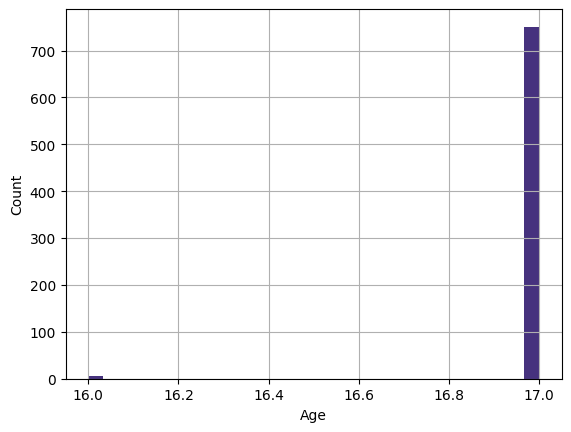

756


In [9]:
plt.hist(less_than_18["first_age_cred"], color = random.choice(sns.color_palette("viridis")), bins = 30)
plt.xlabel("Age")
plt.ylabel("Count")
plt.grid(True)
plt.show()

print(len(less_than_18))

According to most banks in most countries, **the minimum legal age to ask for a loan is 18 years old**. This dataset has **781** borrowers who started their first credit below the age of 18. These observations should be dropped to retain valid accuracy when it comes to predictions.

In [10]:
print(f"Data Lost {round((len(less_than_18)) / len(credit_df),2)}")
credit_df = credit_df.drop(credit_df[credit_df["first_age_cred"] < 18].index)

credit_df = credit_df.drop(["first_age_cred"], axis = 1)

credit_df.head()

Data Lost 0.02


person_age  person_income person_home_ownership  person_emp_length  \
0        22.0        59000.0                  RENT              123.0   
1        21.0         9600.0                   OWN                5.0   
2        25.0         9600.0              MORTGAGE                1.0   
3        23.0        65500.0                  RENT                4.0   
4        24.0        54400.0                  RENT                8.0   

  loan_intent loan_grade  loan_amnt  loan_int_rate  loan_status  \
0    PERSONAL          D    35000.0          16.02          1.0   
1   EDUCATION          B     1000.0          11.14          0.0   
2     MEDICAL          C     5500.0          12.87          1.0   
3     MEDICAL          C    35000.0          15.23          1.0   
4     MEDICAL          C    35000.0          14.27          1.0   

   loan_percent_income cb_person_default_on_file  cb_person_cred_hist_length  
0                 0.59                         Y                         3.0  
1                 0.10                         N                         2.0  
2                 0.57                         N                         3.0  
3                 0.53                         N                         2.0  
4                 0.55                         Y                         4.0

In [11]:
#ensuring the loan_percent_income has been calculated correctly
calculation_check= round(credit_df["loan_amnt"]/credit_df["person_income"], 2)

print(f"Total Incorrect loan_percent_income counts: {len(credit_df[credit_df["loan_percent_income"] != calculation_check])}")
#replace the loan_percent_income values with the calculation check values for accuracy 
credit_df["loan_percent_income"] = calculation_check

print(f"Total Incorrect loan_percent_income counts: {len(credit_df[credit_df["loan_percent_income"] != calculation_check])}")

Total Incorrect loan_percent_income counts: 977
Total Incorrect loan_percent_income counts: 0


## **Filling in the missing values of loan_int_rate with predictions section**

First we will explore the data without the missing loan interest rates because we will not be able to measure the skewness or kurtosis of a feature when missing values are present. Once we are done with the exploration and have a better understanding of the data, we will go back to the original dataset and apply what is needed before modeling our credit risk.

In [12]:
credit_new = credit_df.dropna()
display(credit_new.describe())
print(f"Total Data lost: {100 - (len(credit_new)/len(credit_df) * 100):.2f}%")

person_age  person_income  person_emp_length     loan_amnt  \
count  27950.000000   2.795000e+04       27950.000000  27950.000000   
mean      27.821753   6.691097e+04           4.805903   9681.169946   
std        6.340912   6.284459e+04           4.118126   6337.612818   
min       20.000000   4.000000e+03           0.000000    500.000000   
25%       23.000000   3.999600e+04           2.000000   5000.000000   
50%       26.000000   5.600000e+04           4.000000   8000.000000   
75%       30.000000   8.000000e+04           7.000000  12500.000000   
max      144.000000   6.000000e+06         123.000000  35000.000000   

       loan_int_rate   loan_status  loan_percent_income  \
count   27950.000000  27950.000000         27950.000000   
mean       11.038698      0.215671             0.169610   
std         3.230865      0.411294             0.106574   
min         5.420000      0.000000             0.000000   
25%         7.900000      0.000000             0.090000   
50%        10.990000      0.000000             0.150000   
75%        13.480000      0.000000             0.230000   
max        23.220000      1.000000             0.830000   

       cb_person_cred_hist_length  
count                27950.000000  
mean                     5.766691  
std                      4.056921  
min                      2.000000  
25%                      3.000000  
50%                      4.000000  
75%                      8.000000  
max                     30.000000

Total Data lost: 9.63%


In [13]:
#loop through the features that are not numerical and find out how many levels are there
for column in credit_new.columns:
    if credit_new[column].dtype not in ["int64", "float64"]:
        print(f"{column} levels: {len(credit_new[column].unique())}")

person_home_ownership levels: 4
loan_intent levels: 6
loan_grade levels: 7
cb_person_default_on_file levels: 2


In [14]:
print(nominal_features, ordinal_features, numeric_features, nominal_num_features)

['person_home_ownership', 'loan_intent', 'cb_person_default_on_file', 'loan_status'] ['loan_grade'] ['person_age', 'person_income', 'person_emp_length', 'loan_amnt', 'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length'] ['loan_status']


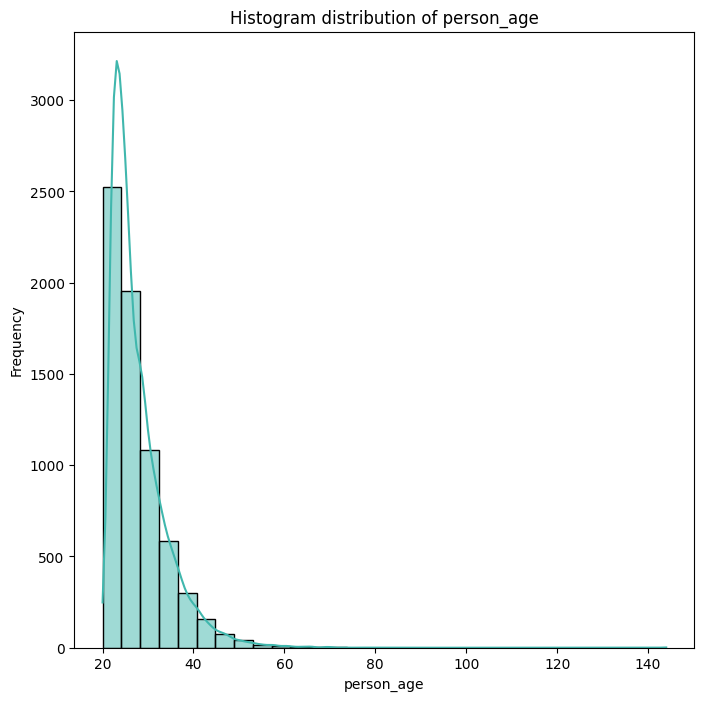

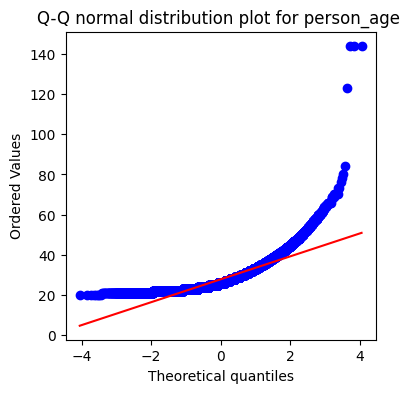

Skewness for person_age: 2.56
Kurtosis for person_age: 21.66


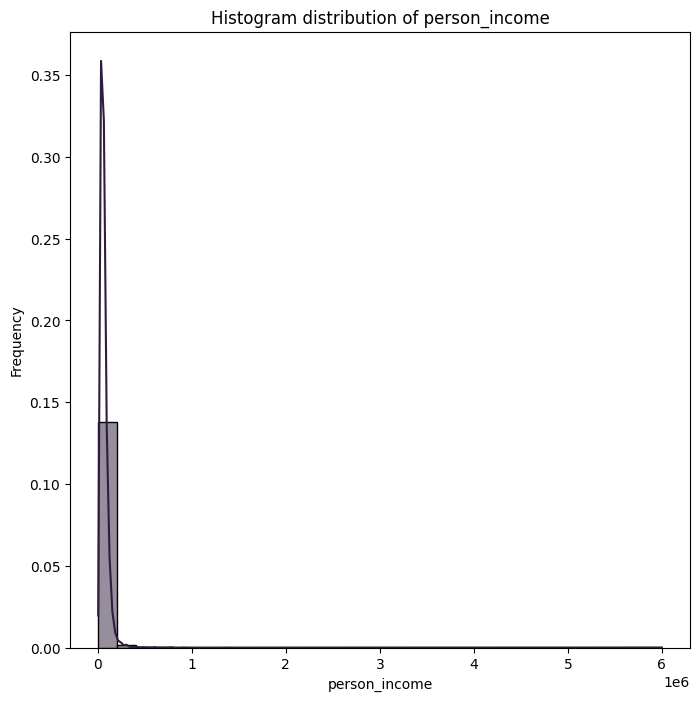

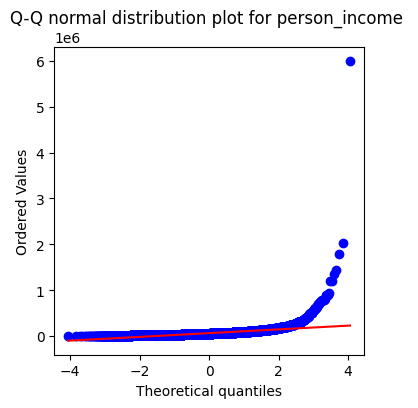

Skewness for person_income: 35.20
Kurtosis for person_income: 2938.21


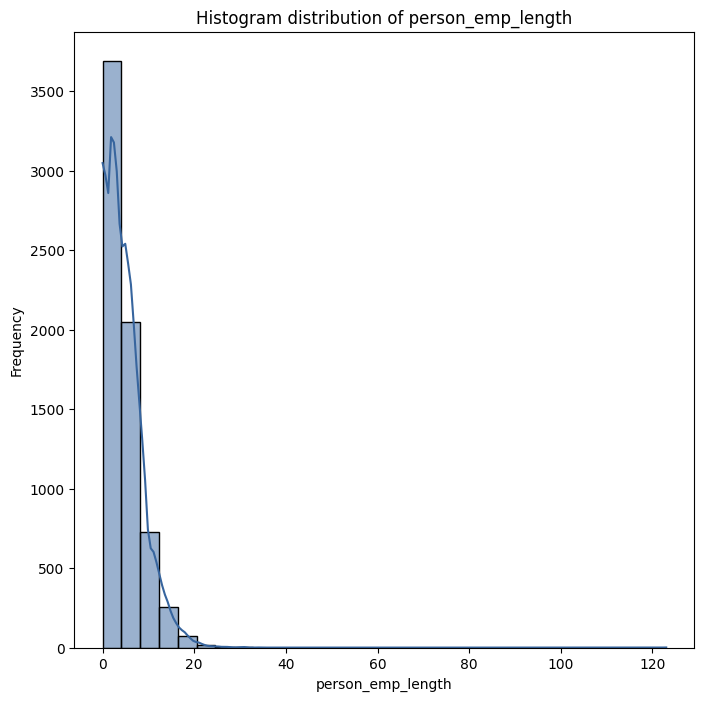

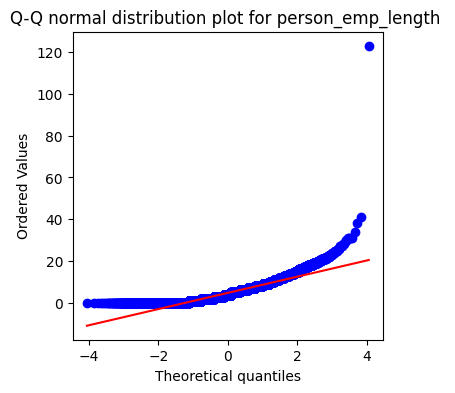

Skewness for person_emp_length: 2.04
Kurtosis for person_emp_length: 29.40


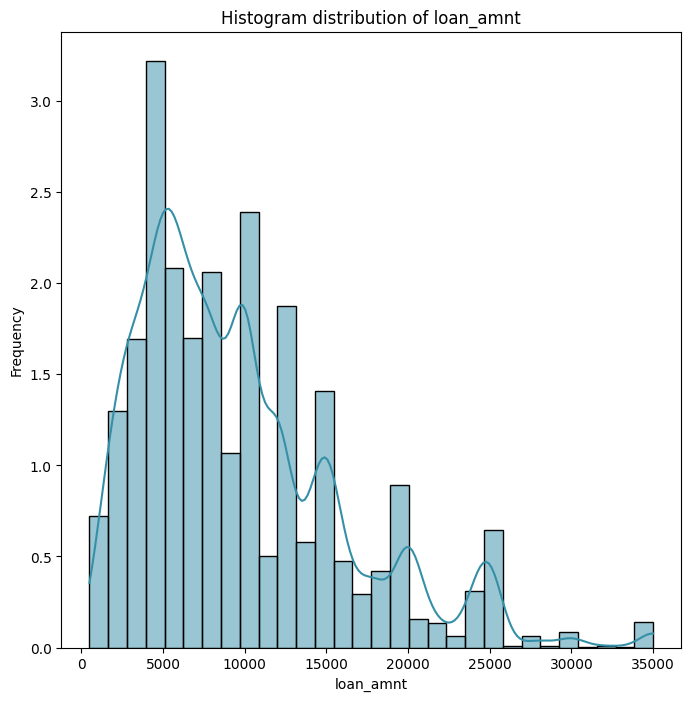

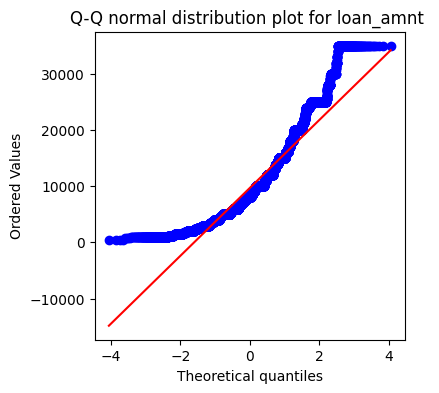

Skewness for loan_amnt: 1.17
Kurtosis for loan_amnt: 4.33


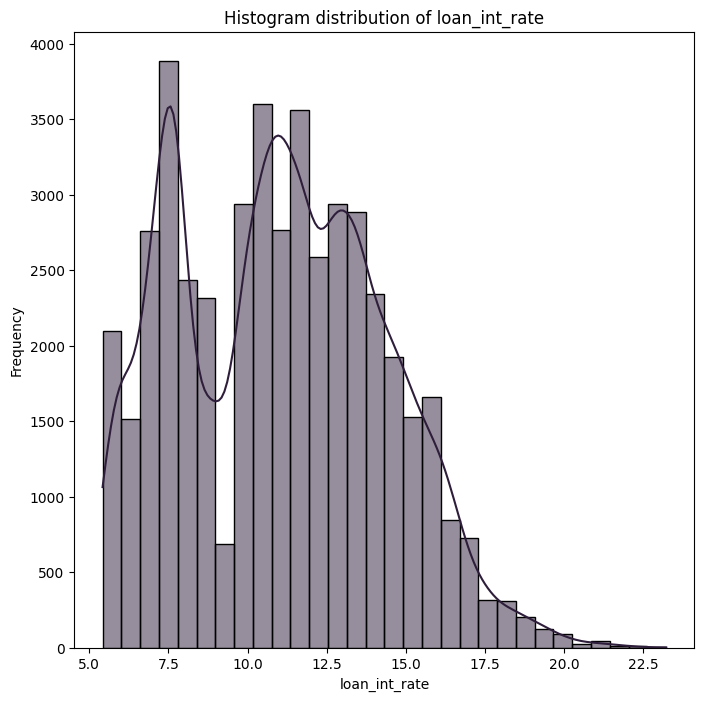

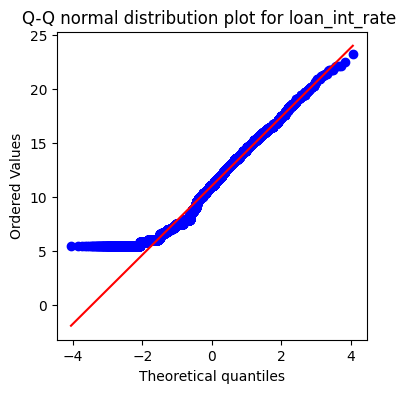

Skewness for loan_int_rate: 0.21
Kurtosis for loan_int_rate: 2.34


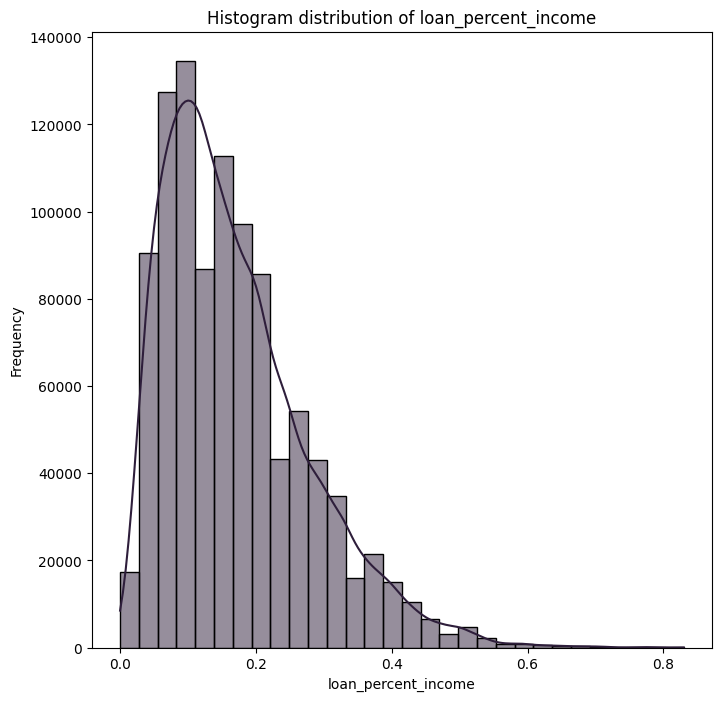

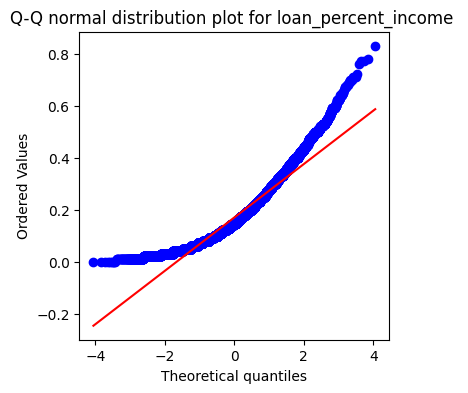

Skewness for loan_percent_income: 1.08
Kurtosis for loan_percent_income: 4.29


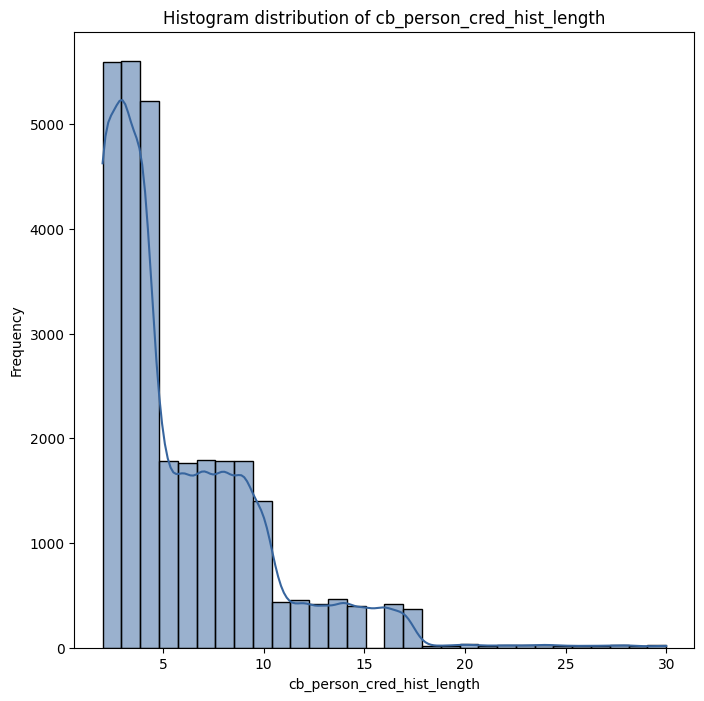

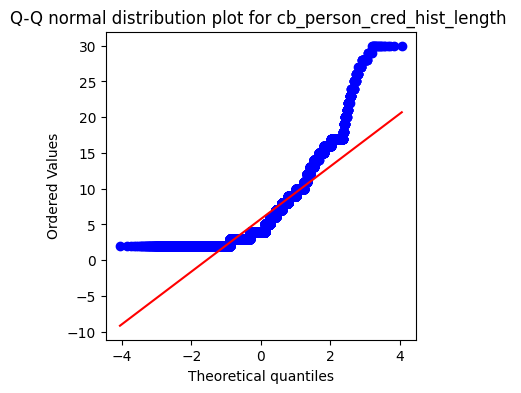

Skewness for cb_person_cred_hist_length: 1.69
Kurtosis for cb_person_cred_hist_length: 6.80


In [15]:
#plot the histograms for data exploration
for column in numeric_features:
    plot_distributions(credit_new, column, fisher = False)
    

#### **Dataset's Numerical Columns Distribution Results after dropping NaN values**

**person_age**: According to the distribution of the histogram, it appears that we have a unimodal histogram that is  **highly skewed to the right**, meaning that the mean of the borrower's age is larger than the median, and the median is larger than the mode. In other words, the average age of the borrower is larger than the mid age of the borrower, and the most frequent ages in the data is less than the mid age. The numerical skew stat for this feature is 2.72 and the kurtosis stat is 18.72, indicating  high leptokurtic distribution.

The feature's Q-Qplot shows us that the data points deviated from  the reference line and also it appears that we have outliers within the age feature due to the points being deviated far away from the reference line. 

**person_income**: According to the histogram distribution, the type of distribution is unimodal and the feature's data appears to be highly skewed to the right which means that the mean person's income is larger than the median person's income, and the median's person's income is larger than the mode of the person's income. That means that the average income of the borrower is larger than the mid person's income and the mid's person income is larger than the majority of the borrower's income. The skew and kurtosis tests for this feature respectively are 35.19 and 2956.06 indicating that the distribution has a high leptokurtic distribution.

The Q-Qplot shows us that the data followed the reference line until it reached a theoretical quantile of 2.5 it started to deviate from the reference line. Indicating that we have outliers within this feature.

**person_emp_length**: The distribution of the histogram is somewhat bimodal and is highly skewed to the right indicating that the mean is larger than the medians, and the median is larger than the mode. In other words, the average employment length is larger than the mid employment length, and most employment lengths are less than the mid employment length. The skew and kurtosis test respectively are 2.75 and 47.64, indicating a leptokurtic distribution.

The Q-Qplot shows us that some points at the end of the plot deviated away from the reference line, signaling potential outliers within the feature.

We may need to explore this feature with kmeans after cleaning and transforming our data because, the KDE plot appears to be either unimodal or bimodal, but KMeans will do the job for us.

**loan_amnt**: According the histogram distribution, it appears we have a multi-modal type of distribution and they are skewed to the right. To understand what a multi-modal histogram is, it basically means that the frequency distribution has multiple modes (peaks) that consists of several subgroups or clusters.

The presence of multiple modes suggests heterogeneity in the feature may be influenced by different underlying categories such as low borrowers, mid borrowers, and high borrowers. We may need to apply K-means to this feature to identify the range for each cluster of these modes so we can correctly identify which of these groups has a normal distribution.

**loan_int_rate**: According to the histogram distribution, it appears we have a trimodal. The peaks appears to be symmetrical. The trimodal nature indicates several distinct clusters within the data, Each mode represents a concentration of values, possibly corresponding to different categories.

The overall has thinner tails on both sides, with the bulk of the data leaning toward lowerand higher values. According to the skew test and kurtosis test, they are **0.20 and -0.66** and this verifies that the data is symmetrical but has a platykurtic distribution.

The platykurtic property suggests that the data is tightly clustered around each mode (sharp peaks) but also has a higher likelihood of extreme values on both ends. This indicates both concentration within subgroups and the presence of potential outliers.

**loan_percent_income**: The histogram is unimodal and is skewed to the right, meaning that the mean of the loan to income percentage is larger than the median of it, and the median of it is larger than the mode. In other words, the average percentage of loan to income is larger than the mid value, and the mid percentage is larger than the most common percentage of loan to income. This is then verified by the numeric stat of the skew test, which is **1.08**.

The Q-Qplot shows us that the ends of distribution has deviated from the reference line, indicating that we have potential outliers and when looking at the kurtosis stat, which is **1.29**, verifies that we have a leptokurtic distribution indicating that there is a slight chance of having outliers.

**cb_person_cred_hist_length**: According to the histogram of this feature, it appears to be some what unimodal or trimodal distribution, and it is highly skewed to the right. The multimodal nature indicates several distinct clusters within the data, Each mode represents a concentration of values, possibly corresponding to different categories such as low credit history, mid credit history, and high credit history.

The right skew for the third peak means that across the entire distribution or within the modes, there are more extreme values on the higher ends. They overall have longer or fatter right tails, with the bulk of the data leaning toward lower values.

The skew and kurtosis test proves that since their values respectively are **1.66 and 3.73**. The leptokurtic property suggests that the data is tightly clustered around each mode but also has a higher likelihood of extreme values particularly in the right tail due to skewness. This indicates concentration within subgroups.

Eventhough, we have found a trimodal distribution for the loan interest rates, we can not apply kmeans clustering to it because the original data contains missing values and i dont think it is appropriate to create another feature solely on loan interest rates.

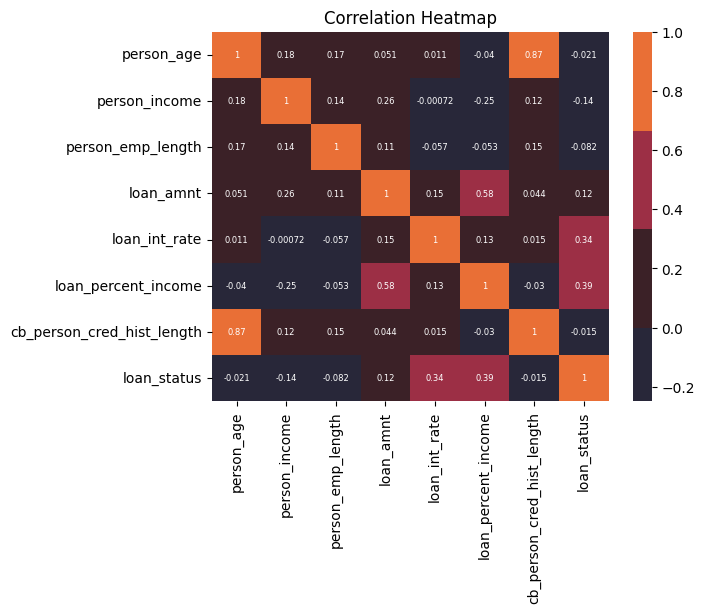

In [16]:
numeric_df = credit_new[numeric_features].copy()
numeric_df["loan_status"] = credit_new["loan_status"]

def plot_correlation(data: float):
    """This function plots a Correlation Heatmap"""
    correlation = data.corr()
    sns.heatmap(data = correlation, cmap = sns.color_palette("icefire"), center = 0, annot = True, annot_kws={"size":6})
    plt.title("Correlation Heatmap")
    plt.show()

#check the correlation heatmaps to identify multicollinearity
plot_correlation(numeric_df)

#### **Interpretation of Correlation Heatmap**

According to the Heatmap, **person_age** has **0.87** correlation between **cb_person_cred_hist_length** which is considered a high correlation. **person_income** has **0.26** correlation between **loan_amnt** which is a moderate correlation.  **person_income** however has a **-0.25** negative correlation between **loan_percent_income** which makes sense because the larger the income value is the less the percentage of the loan to income will be. **loan_amnt** on the other hand has a strong postive correlation of **0.58** between **loan_percent_income** because the larger the loan value is, the larger the percentage of the the loan to income will be. The rest of the features, compared to the other features have low correlation between each other.


Personally, i am unsure about the distribution analysis of **person_income** which is why i am going to apply KMeans to identify if there are clusters within this feature as well. 

In [17]:
def outlier_threshold(dataframe, column, q3 = 0.75, q1 = 0.25):
    """This Function identifies the upper_bounds and lower bounds of each numeric feature.
    Using 25% as the lower quantile and 75% as the upper quantile as the default values"""
    upper_quartile = dataframe[column].quantile(q3)
    lower_quartile = dataframe[column].quantile(q1)
    
    IQR = upper_quartile - lower_quartile

    upper_bound = upper_quartile + 1.5 * IQR
    lower_bound = lower_quartile - 1.5 * IQR

    return upper_bound, lower_bound 

def check_outliers(dataframe, column, q3 = 0.75, q1 = 0.25):
    """This function confirms if the value has exceeded the upper bound or receeded the lower bound of the feature"""
   
    upper_bound, lower_bound = outlier_threshold(dataframe, column, q3, q1)

    if dataframe[(dataframe[column] > upper_bound) | (dataframe[column] < lower_bound)].any(axis = None):
        return True
    return False

#we will call these functions later when we apply transformations after cleaning the data


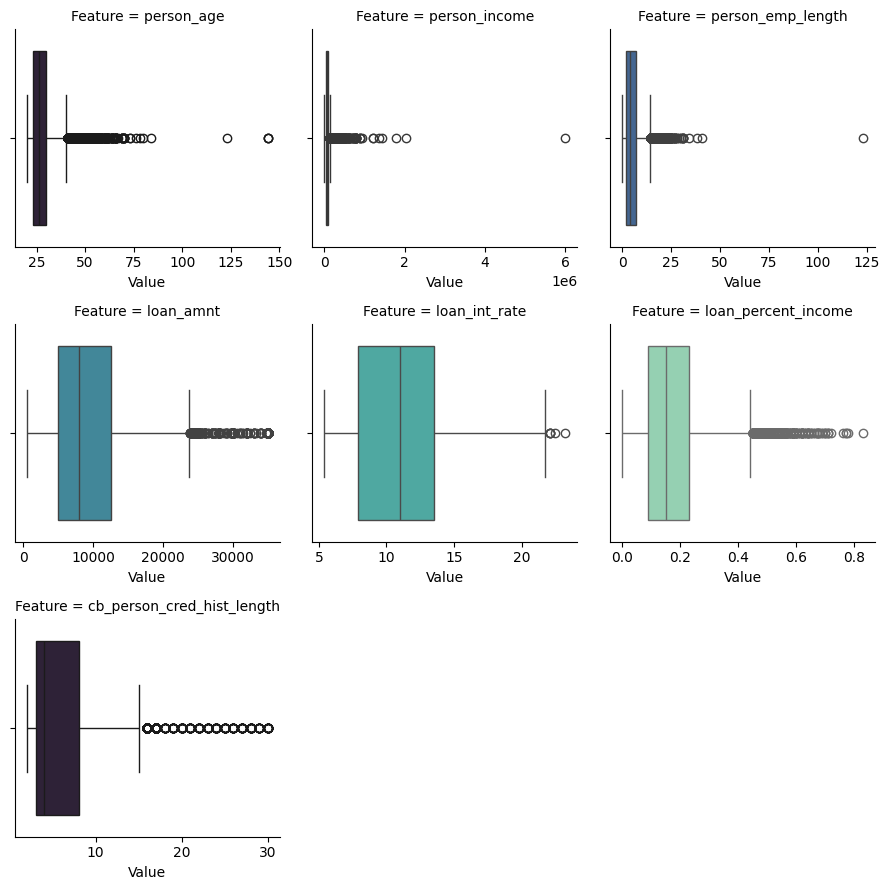

In [18]:
#check the outliers for each feature

def plot_boxplots(data, palette):
    """This function takes in numeric data and plots the box-whisker plots for each numeric feature in a grid"""

    data_melt = data.melt(var_name = "Feature", value_name = "Value")
    feature_list = data_melt["Feature"].unique()

    palette_map = {feature: palette[i % len(palette)] for i, feature in enumerate(feature_list)}

    def boxplot_colors(data, color, **kwargs):
        feature_name = data["Feature"].iloc[0]
        sns.boxplot(x = "Value", data = data, color = palette_map[feature_name], **kwargs)

    g = sns.FacetGrid(data_melt, col = "Feature", col_wrap = 3, sharex = False, sharey = False)
    g.map_dataframe(boxplot_colors)

    plt.tight_layout()
    plt.show()


plot_boxplots(credit_new[numeric_features], palette)


#### **Box-Whisker Plot Visual Analysis**


**person_age**: When observing the age feature, it seems that most of our outlying points are clustered together explaining that these age groups are older than the majority of the age groups given that our feature has only one peak(one mode). However, when looking at the last two outlying points, it seems that they are older than 100 years older and needs a quick investigation.

**person_income**: When observing the income feature, it appears that most outlying points are closely clustered next to each other with the exception of one outlier. This outlier appears to be the wealthiest of them all, which also requires a quick investigation.

**person_emp_length**: When obseving the employment length of the borrowers, it appears to have the same situation as the previous two features except that we do not know if this distribution is unimodal or trimodal. However, a borrower with more than a hundered years of work experience is unrealistic and should be considered as an anomaly.

**loan_amnt**: When observing this feature, it appears that all outliers are closely clustered together. In addition, this feature has a bimodal distribution, meaning that there are two peaks. Given that the outliers, are very closely clustered next to each other and the feature is a bimodal distribution, i dont think this feature has any outliers, however, it may require further transformations to address this issue before adding it into the KMeans model.

**loan_int_rate**: Same situation as the previous feature, only this time the data is symmetrical and has way less outliers compared to "loan_amnt", which is why we need to carefully investigate it.

**loan_percent_income**: I personally do not believe this feature has any outliers because it is heavily influenced by "person_income" and "loan_amnt".

**cb_person_cred_hist_length**: When observing this feature, it seems that all outlying points are all clustered together at a fixed distance. In addition, the distribution of this feature somewhat appears to have a unimodal distribution. This feature requires transformations to normalize the data within it.

Since i have mentioned that ill be applying transformations to these features, that does not include when it comes to imputing our missing loan interest rates because we the standard form of these features values are realistic and we want to avoid data leakage. However, ill be transforming these features after imputing the missing interest rates for KMeans.

In [19]:
#check the age of individuals older than 84+ 

display(credit_new[credit_new["person_age"] > 84])

#check the data point that has the highest income
display(credit_new[credit_new["person_income"] == credit_new["person_income"].max()])

person_age  person_income person_home_ownership  person_emp_length  \
81          144.0       250000.0                  RENT                4.0   
183         144.0       200000.0              MORTGAGE                4.0   
575         123.0        80004.0                  RENT                2.0   
32297       144.0      6000000.0              MORTGAGE               12.0   

      loan_intent loan_grade  loan_amnt  loan_int_rate  loan_status  \
81        VENTURE          C     4800.0          13.57          0.0   
183     EDUCATION          B     6000.0          11.86          0.0   
575     EDUCATION          B    20400.0          10.25          0.0   
32297    PERSONAL          C     5000.0          12.73          0.0   

       loan_percent_income cb_person_default_on_file  \
81                    0.02                         N   
183                   0.03                         N   
575                   0.25                         N   
32297                 0.00                         N   

       cb_person_cred_hist_length  
81                            3.0  
183                           2.0  
575                           3.0  
32297                        25.0

person_age  person_income person_home_ownership  person_emp_length  \
32297       144.0      6000000.0              MORTGAGE               12.0   

      loan_intent loan_grade  loan_amnt  loan_int_rate  loan_status  \
32297    PERSONAL          C     5000.0          12.73          0.0   

       loan_percent_income cb_person_default_on_file  \
32297                  0.0                         N   

       cb_person_cred_hist_length  
32297                        25.0

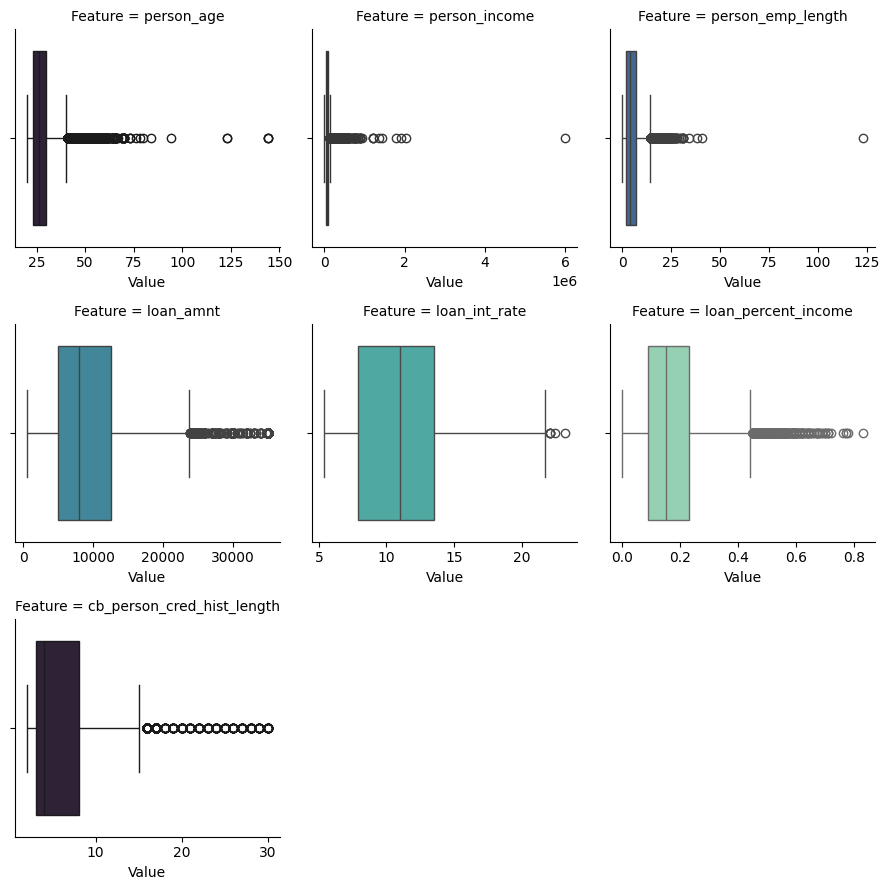

In [20]:
#check the original data for these outliers and if there are an additionals
plot_boxplots(credit_df[numeric_features], palette = palette)

In [21]:
display(credit_df[credit_df["person_age"] > 75])

person_age  person_income person_home_ownership  person_emp_length  \
81          144.0       250000.0                  RENT                4.0   
183         144.0       200000.0              MORTGAGE                4.0   
575         123.0        80004.0                  RENT                2.0   
747         123.0        78000.0                  RENT                7.0   
32297       144.0      6000000.0              MORTGAGE               12.0   
32355        78.0        48000.0                  RENT               41.0   
32416        94.0        24000.0                  RENT                1.0   
32422        80.0        64000.0                  RENT                7.0   
32506        84.0        94800.0              MORTGAGE                2.0   
32534        76.0        75000.0                  RENT               23.0   

      loan_intent loan_grade  loan_amnt  loan_int_rate  loan_status  \
81        VENTURE          C     4800.0          13.57          0.0   
183     EDUCATION          B     6000.0          11.86          0.0   
575     EDUCATION          B    20400.0          10.25          0.0   
747       VENTURE          B    20000.0            NaN          0.0   
32297    PERSONAL          C     5000.0          12.73          0.0   
32355     MEDICAL          A     3000.0           7.51          0.0   
32416     MEDICAL          C     6500.0            NaN          0.0   
32422     MEDICAL          B     6800.0          11.71          0.0   
32506    PERSONAL          A    10000.0           7.51          0.0   
32534     MEDICAL          A    15000.0           8.94          0.0   

       loan_percent_income cb_person_default_on_file  \
81                    0.02                         N   
183                   0.03                         N   
575                   0.25                         N   
747                   0.26                         N   
32297                 0.00                         N   
32355                 0.06                         N   
32416                 0.27                         N   
32422                 0.11                         N   
32506                 0.11                         N   
32534                 0.20                         N   

       cb_person_cred_hist_length  
81                            3.0  
183                           2.0  
575                           3.0  
747                           4.0  
32297                        25.0  
32355                        25.0  
32416                        27.0  
32422                        25.0  
32506                        24.0  
32534                        25.0

When observing the borrowers that are older than the age of 75, most of them appear to have a good credit history length. However, some borrower's data appear to not be realistic and anomalous instead because the global maximum life expectancy is 122 years old and the borrowers that are older than 122 years have very good loan to income ratio which is why it is best to believe that these data points are anomalous and should be removed.

In [22]:
credit_df = credit_df.drop(credit_df[credit_df["person_age"] > 122].index)
credit_new = credit_new.drop(credit_new[credit_new["person_age"] > 122].index)
#just noticed that there is a point where the employment length of a borrower in years is much more than their age, which is an anomaly.

#they also happen to have the highest income of every borrower.
credit_df = credit_df.drop(credit_df[credit_df["person_emp_length"] > credit_df["person_age"]].index)
credit_new = credit_new.drop(credit_new[credit_new["person_emp_length"] > credit_new["person_age"]].index)

/tmp/ipykernel_235484/1974946023.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  numeric_df["loan_status"] = credit_df["loan_status"]


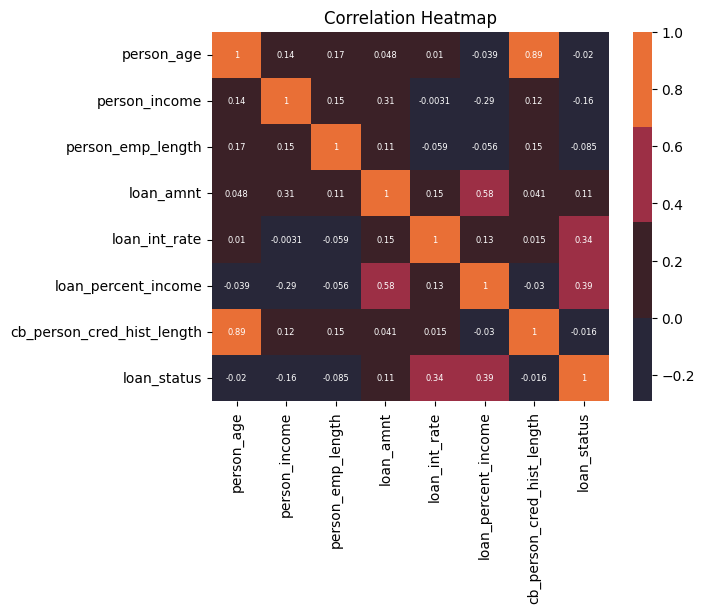

In [23]:
numeric_df = credit_df[numeric_features]
numeric_df["loan_status"] = credit_df["loan_status"]
plot_correlation(numeric_df)

Correlation between `person_income` and `loan_amnt` has increased slightly after dropping several anomalies from our data.

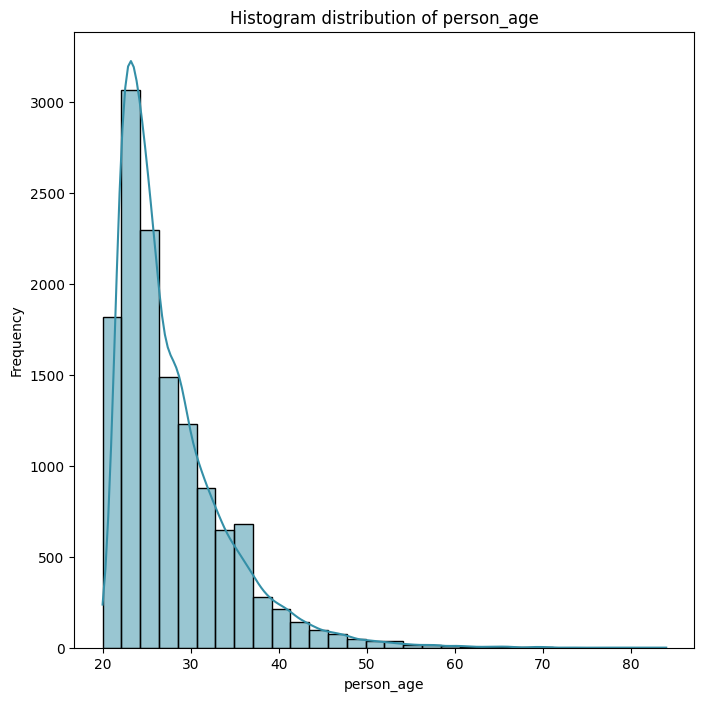

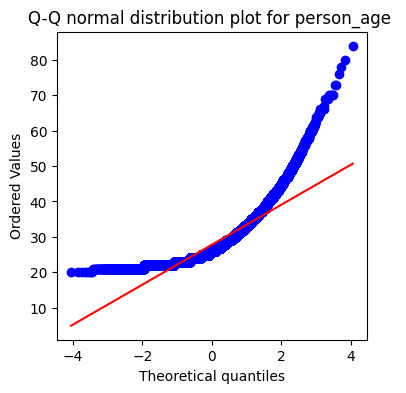

Skewness for person_age: 1.91
Kurtosis for person_age: 8.49


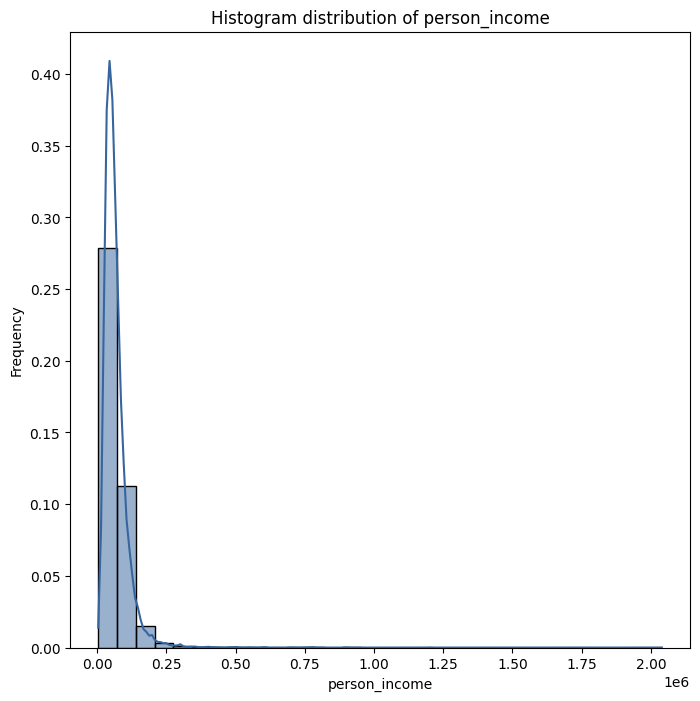

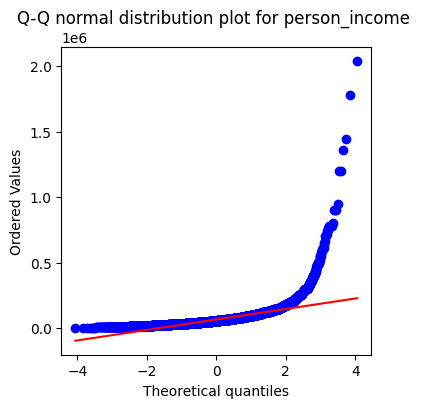

Skewness for person_income: 9.09
Kurtosis for person_income: 205.61


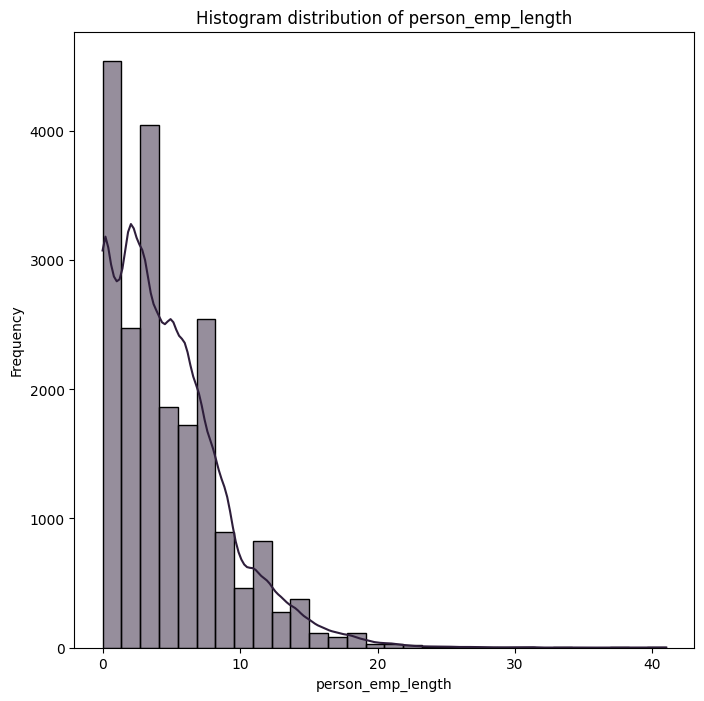

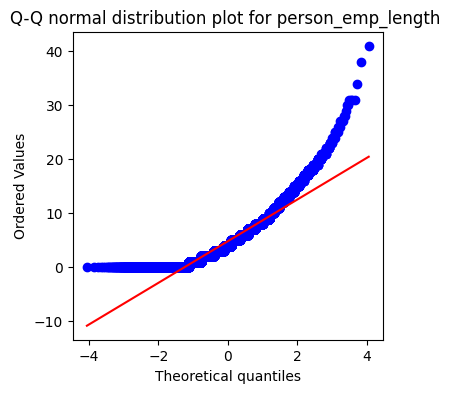

Skewness for person_emp_length: 1.25
Kurtosis for person_emp_length: 5.44


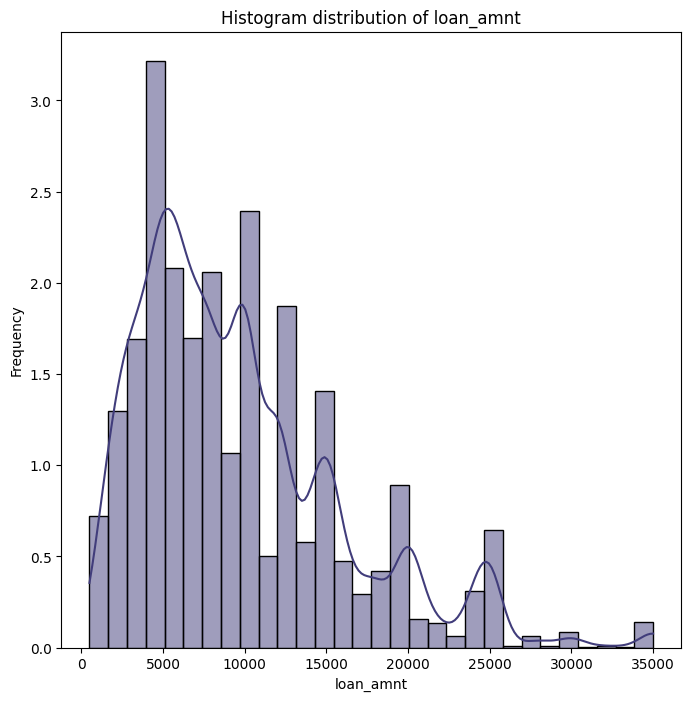

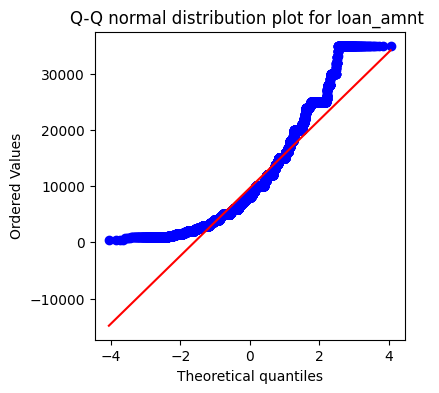

Skewness for loan_amnt: 1.17
Kurtosis for loan_amnt: 4.33


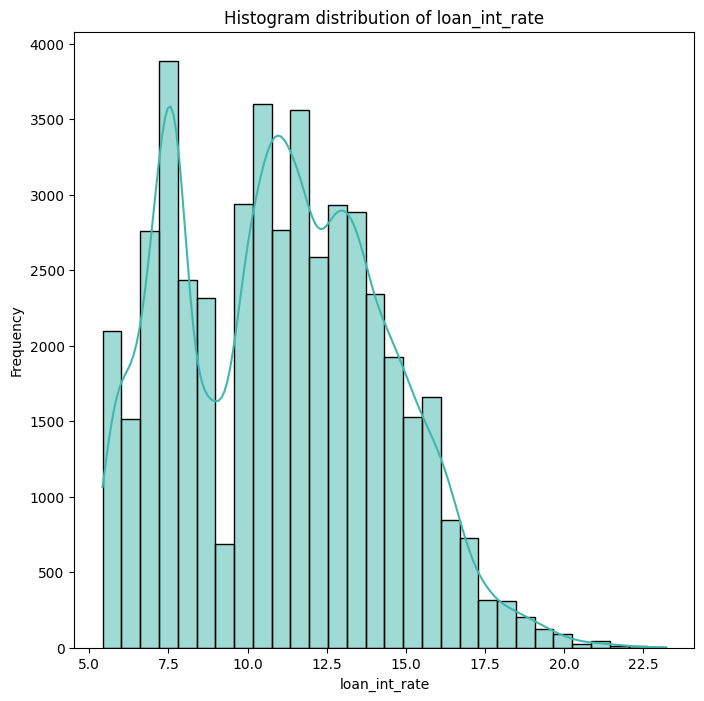

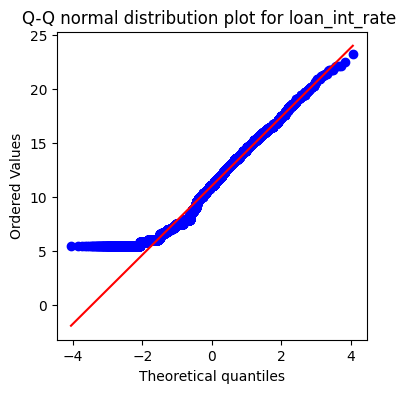

Skewness for loan_int_rate: 0.21
Kurtosis for loan_int_rate: 2.34


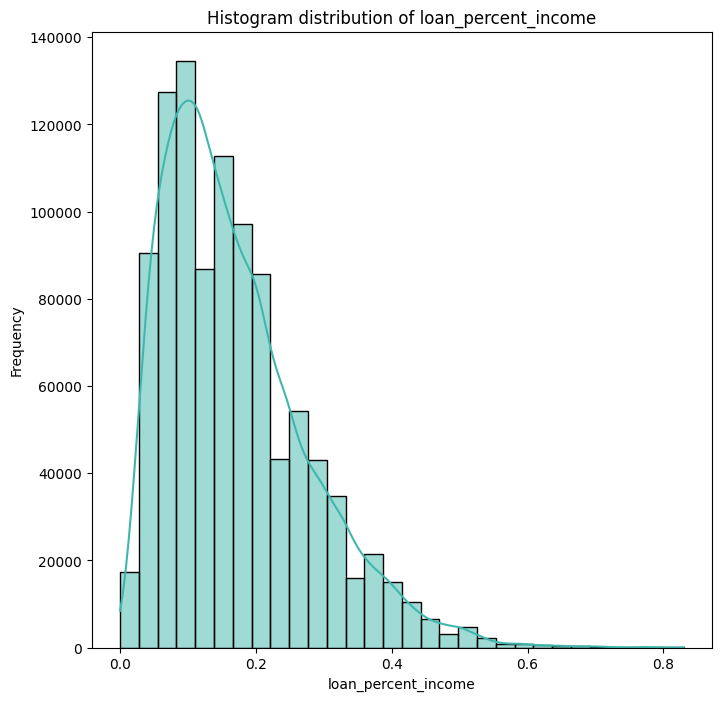

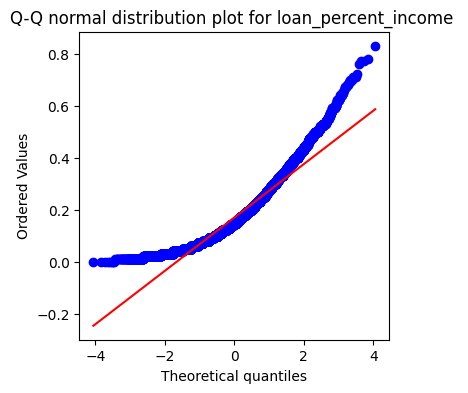

Skewness for loan_percent_income: 1.08
Kurtosis for loan_percent_income: 4.29


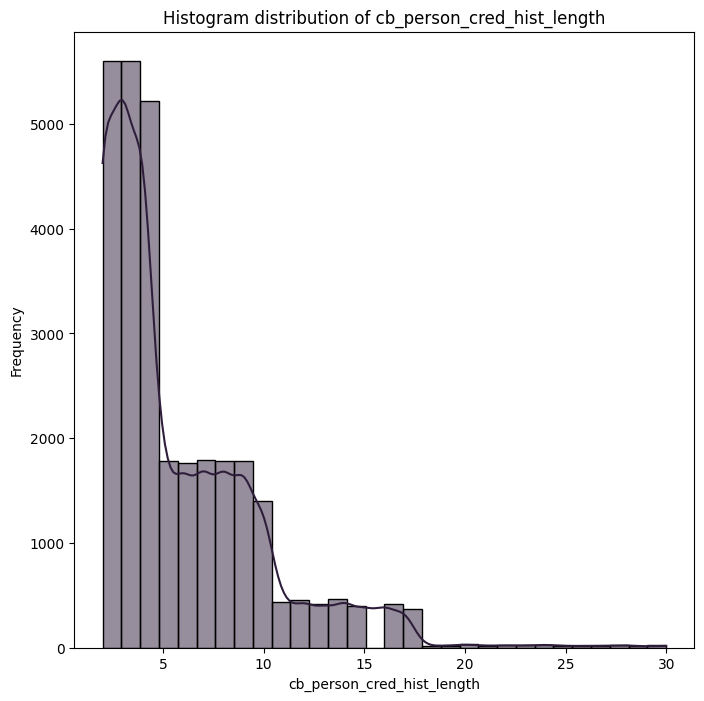

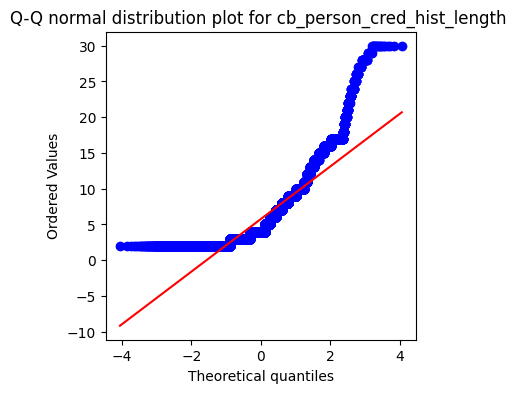

Skewness for cb_person_cred_hist_length: 1.69
Kurtosis for cb_person_cred_hist_length: 6.80


In [24]:
for feature in numeric_features:
    plot_distributions(credit_new, feature, fisher = False)

with nan values


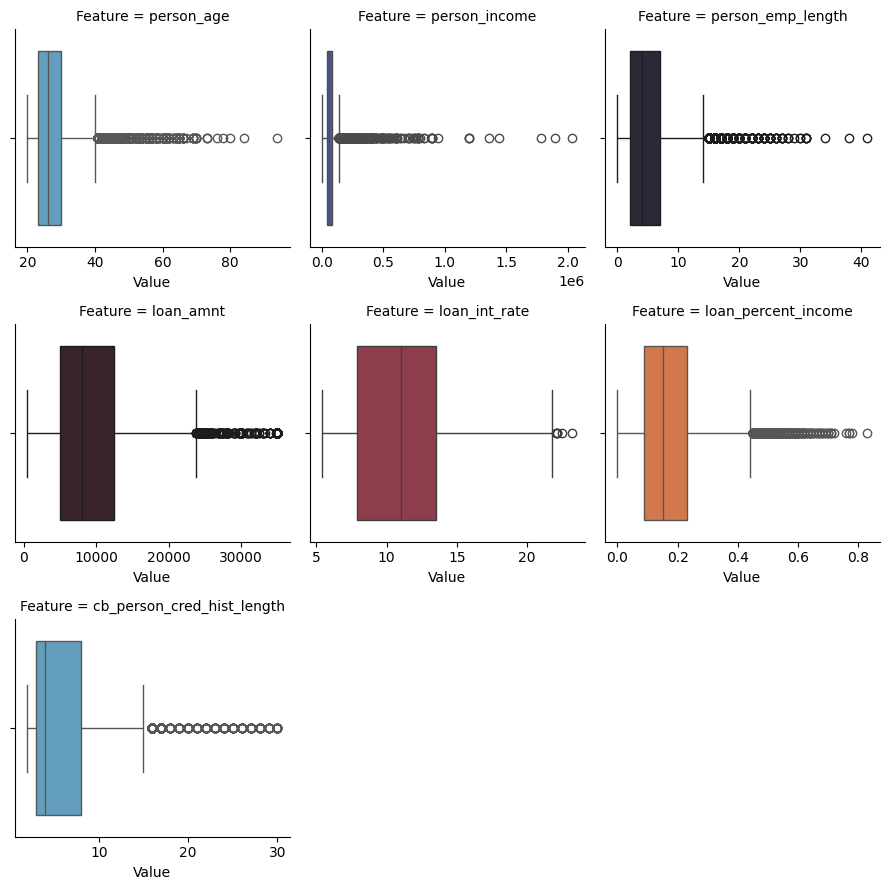

--------------------------------------------------------------------------------
without nan values


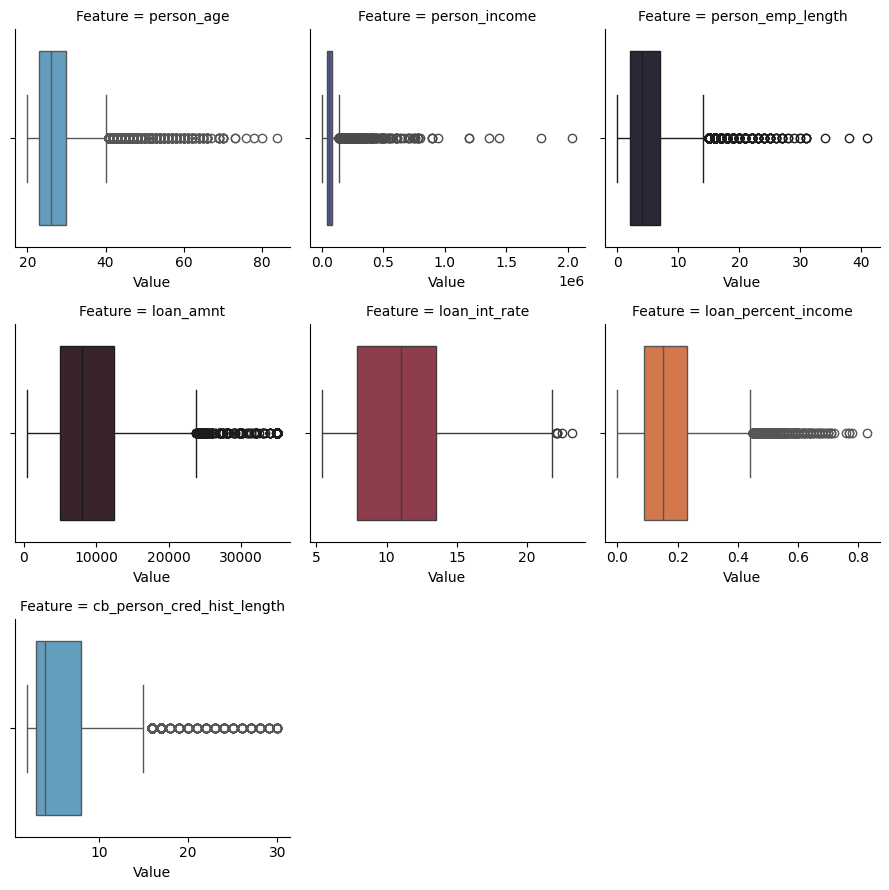

In [25]:
print("with nan values")
plot_boxplots(credit_df[numeric_features], palette=sns.color_palette("icefire").as_hex())
print("-"*80)
print("without nan values")
plot_boxplots(credit_new[numeric_features], palette=sns.color_palette("icefire").as_hex())

It appears that the outlying points appear to be more clustered closely to the other outlier points in the original dataset after removing the anomalous data points from the dataset. This means that we can proceed with transforming our data for KMeans clustering.

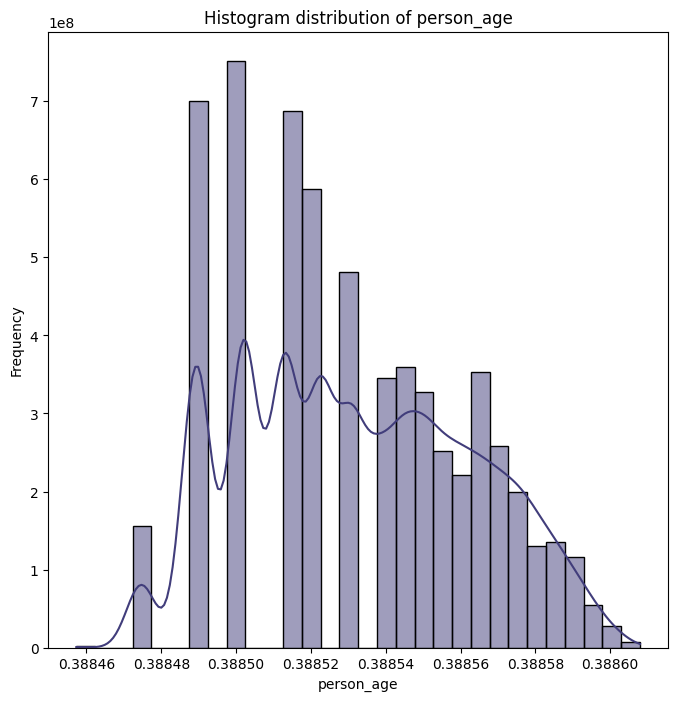

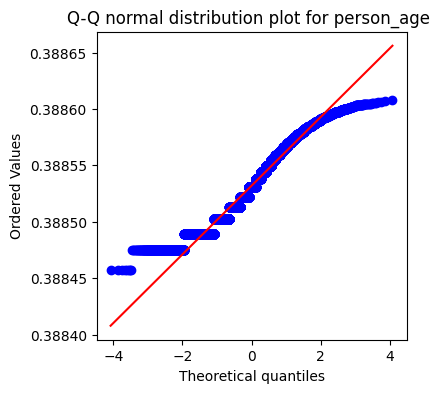

Skewness for person_age: 0.17
Kurtosis for person_age: -0.93


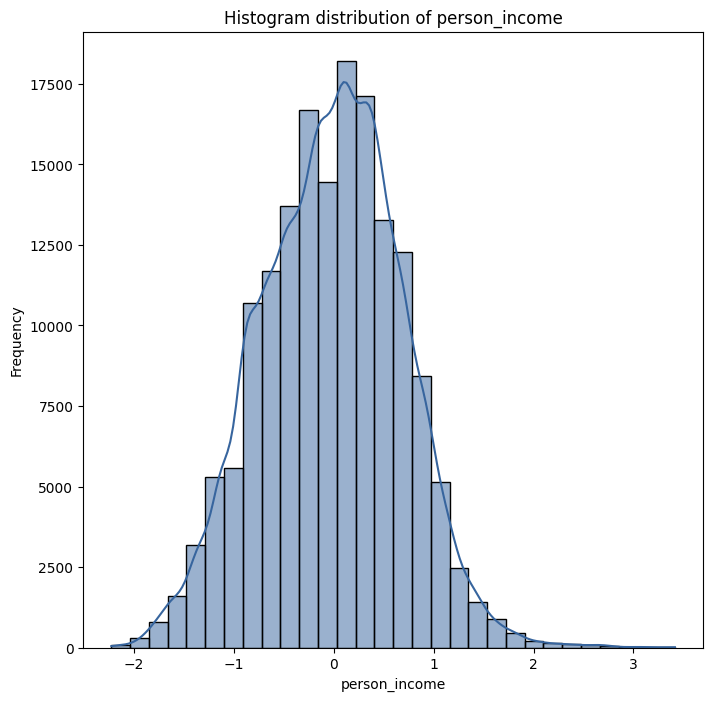

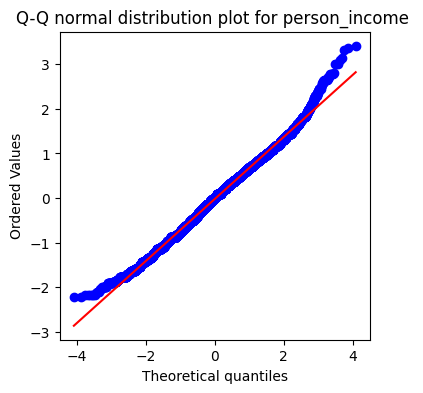

Skewness for person_income: 0.02
Kurtosis for person_income: 0.01


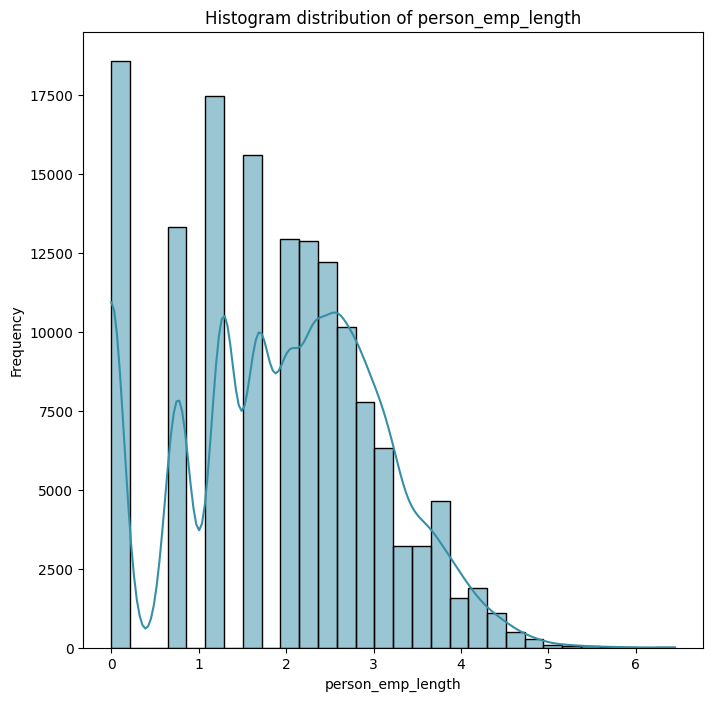

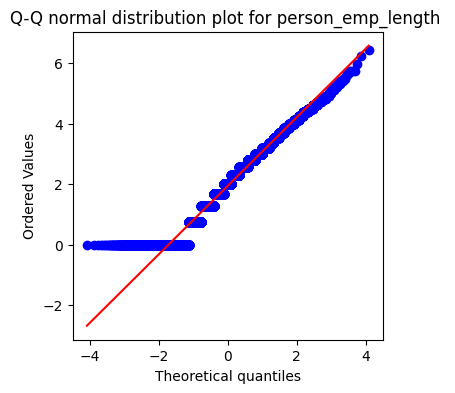

Skewness for person_emp_length: -0.05
Kurtosis for person_emp_length: -0.61


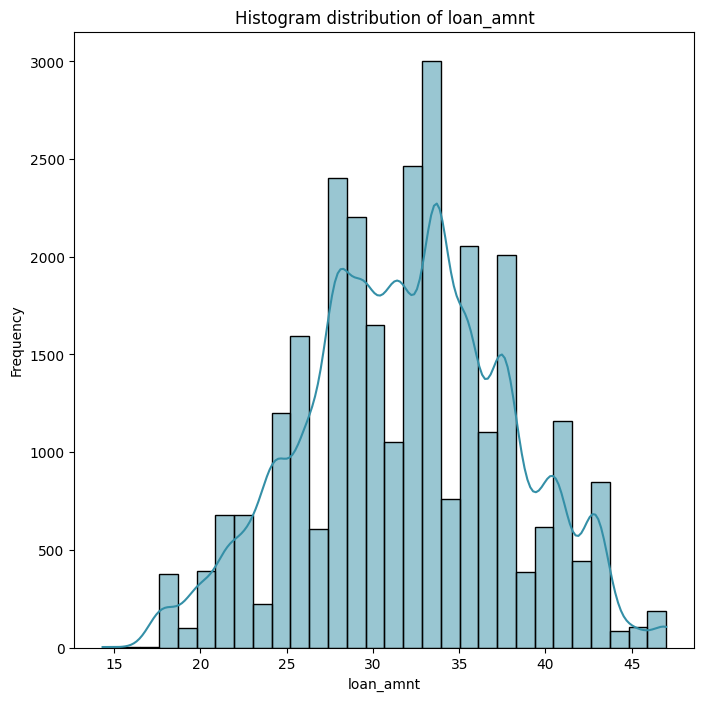

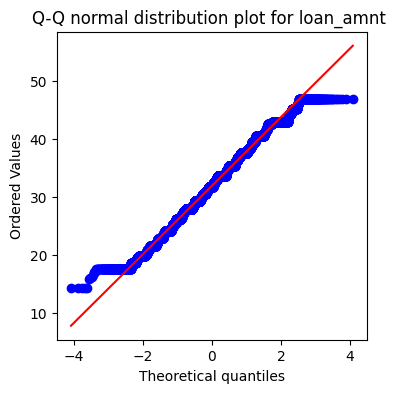

Skewness for loan_amnt: -0.02
Kurtosis for loan_amnt: -0.37


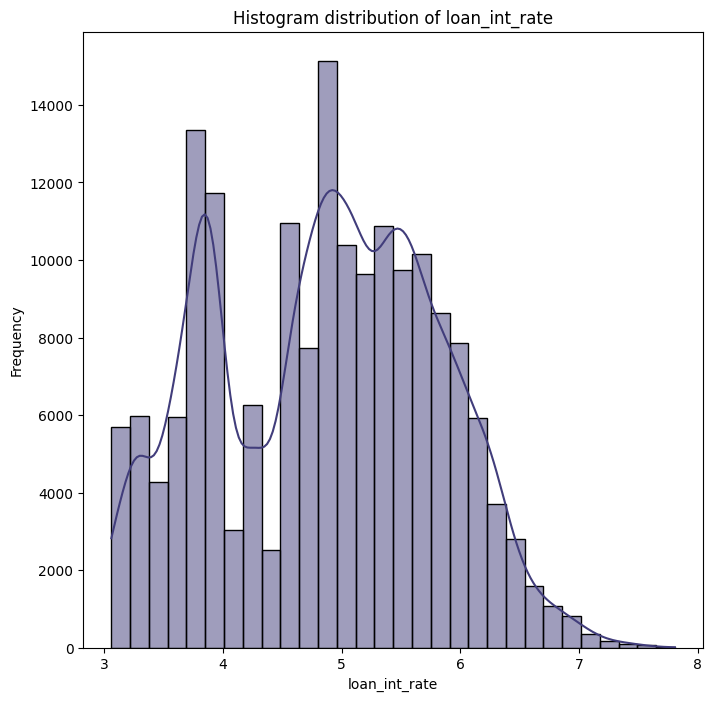

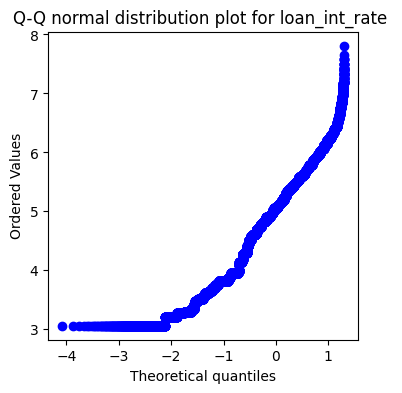

Skewness for loan_int_rate: nan
Kurtosis for loan_int_rate: nan


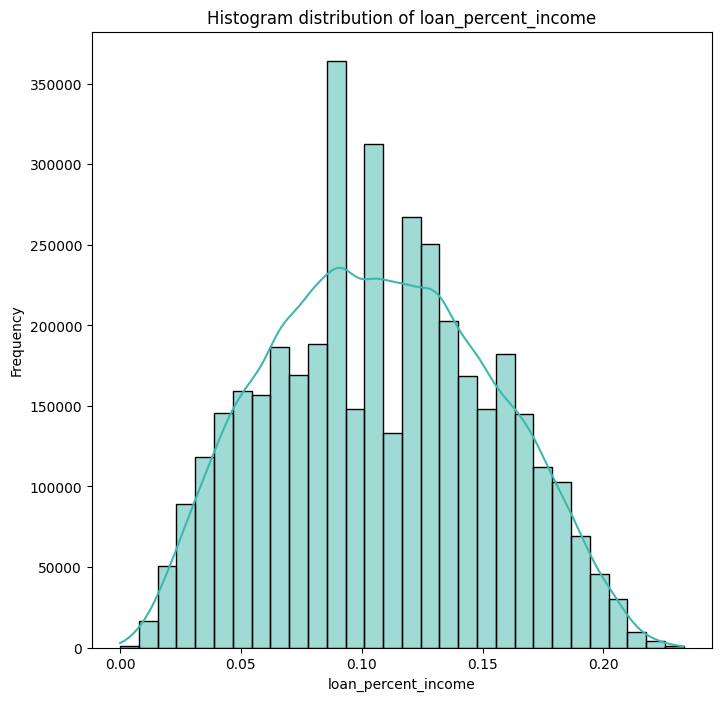

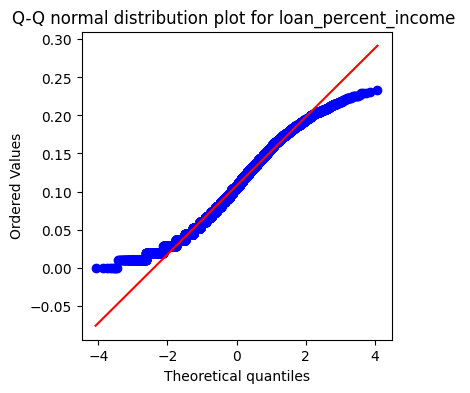

Skewness for loan_percent_income: 0.09
Kurtosis for loan_percent_income: -0.75


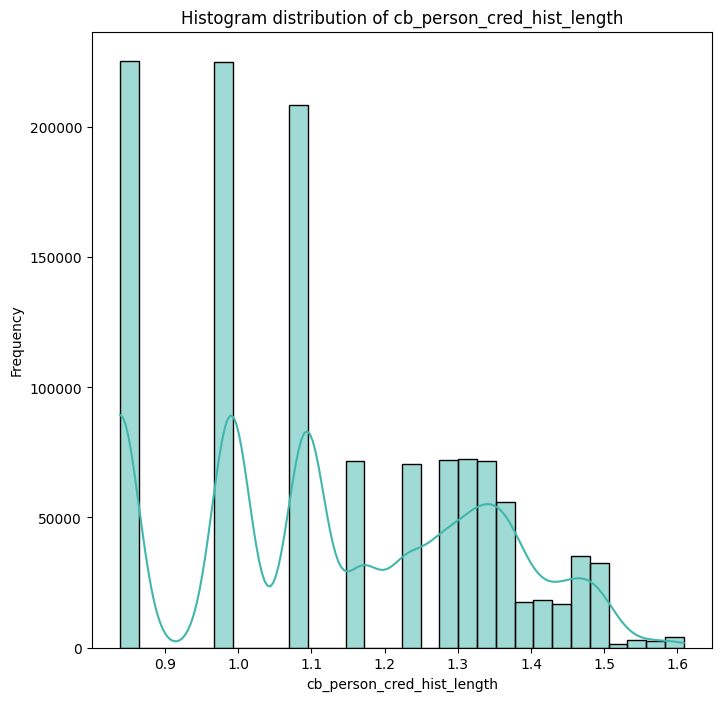

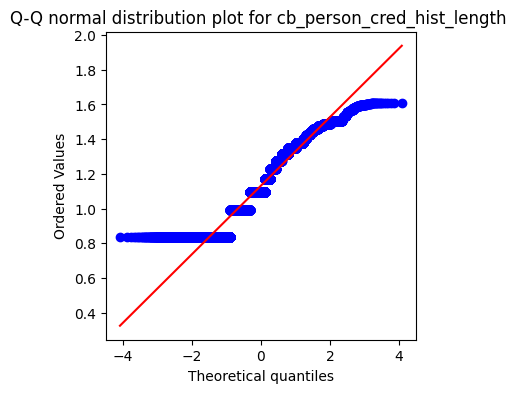

Skewness for cb_person_cred_hist_length: 0.10
Kurtosis for cb_person_cred_hist_length: -1.09


In [26]:
from sklearn.preprocessing import PowerTransformer, RobustScaler

pt = PowerTransformer(standardize=False, method="yeo-johnson")
robust = RobustScaler()
X_scale = credit_df.copy()
X_scale["person_income"] = robust.fit_transform(X_scale[["person_income"]])
X_scale[numeric_features] = pt.fit_transform(X_scale[numeric_features])

for feature in numeric_features:
    plot_distributions(X_scale, feature)

### **Reducing dimensions with Principal Component Analysis**

**What is Principal Component Analysis?**

Principal Components analysis or PCA is an unsuperivsed dimension reduction algorithim that reduces the dimension of datasets. When you input too many features into an algorithim like KMeans, it tends to have a harder time seperating the data because of too much noise. This is often referred as the curse of dimensions because when you have too many features, it becomes harder to seperate each group of the feature. This is where PCA comes in handy because PCA's main purpose is to reduce the number of dimensions while retaining the most variance of the data. 

PCA reduces the dimensions by the following steps:

1. Centers the data:

$$
\tilde{X} = {X} - \bar{X}
$$

- Where:

    $\tilde{X}$: The data center.

    X: The original data matrix.

    $\bar{X}$: The mean vector of each feature.

2. After centering the data, it computes the covariance matrix:

$$
\Sigma = \frac{1}{n - 1} \tilde{X}^T \tilde{X}
$$

3. It then performs the eigen decomposition by finding the eigenvalues λi such that:

$$
\Sigma \mathbf{v}_i = \lambda_i \mathbf{v}_i
$$

- Each eigenvector $\mathbf{v}_i$ is the principal component.
- Each eigenvalue $\lambda_i$ tells how much variance is captured along  $\mathbf{v}_i$.


4. Sorts and select the top k components:

It sorts the eigenvalues in descending order and select the top k eigenvectors:

$$
V_k = [\mathbf{v}_1, \mathbf{v}_2, \dots, \mathbf{v}_k]
$$

5. Projects the data onto the new subspace:

$$
Z = \tilde{X} V_k
$$​

In order for PCA to determine the optimal number of components, it finds out the explained variance ratio of each component:

$$
\text{Explained Variance Ratio}_i = \frac{\lambda_i}{\sum_{j=1}^d \lambda_j}
$$

Where:

$\lambda_i$ is the eigenvalue of the i-th component and <em>d</em> is the total number of features.

It then finds the cumulative explained variance by summing them up:

$$
\text{Cumulative Variance}_k = \sum_{i=1}^{k} \frac{\lambda_i}{\sum_{j=1}^d \lambda_j}
$$

In practice, we create a scree plot by plotting each $\lambda_i$ (or explained variance ratio) against the component number. The "elbow point" (where the slope flattens) helps us choose the optimal number of components.

In [27]:
from sklearn.decomposition import PCA

pca = PCA(random_state = 42)

#exclude loan_int_rate
multimodals = [feature for feature in numeric_features if feature != "loan_int_rate"]
X_pca = pca.fit_transform(X_scale[multimodals])

principalComponents = pd.DataFrame(X_pca)

display(principalComponents)

0         1         2         3         4         5
0     -14.375005  0.496879 -1.251666 -0.247148 -0.016275 -0.000017
1      -3.416850 -1.349859 -1.536972 -0.072470  0.033292  0.000014
2      15.009985 -0.353438 -0.481161 -0.298416 -0.001908  0.000006
3      15.020054  0.587200 -0.865479 -0.050570 -0.003474 -0.000015
4      -9.048346 -0.672446 -1.336228 -0.232520  0.013520 -0.000016
...          ...       ...       ...       ...       ...       ...
30919  -2.906066 -1.092013  0.259519  0.494761 -0.002594  0.000010
30920   7.303988 -0.011052  0.598719  0.366811 -0.006149  0.000015
30921  15.012974 -0.643593 -0.227639  0.459121 -0.001948  0.000013
30922   5.679551  0.357140  0.866753  0.415239 -0.009659  0.000008
30923  -2.023621 -0.655502 -0.190004  0.497038 -0.004970  0.000014

[30924 rows x 6 columns]

In [28]:
print(f"Intial eigenvalues:\n{list(np.round(pca.explained_variance_, decimals =  5))}")

Intial eigenvalues:
[np.float64(35.24994), np.float64(1.32941), np.float64(0.38163), np.float64(0.04097), np.float64(7e-05), np.float64(0.0)]


In [29]:
for pc, vector in enumerate(pca.explained_variance_ratio_):
    print(f"The Explained variance ratio of PCA_{pc} is {vector:.5f}")

The Explained variance ratio of PCA_0 is 0.95265
The Explained variance ratio of PCA_1 is 0.03593
The Explained variance ratio of PCA_2 is 0.01031
The Explained variance ratio of PCA_3 is 0.00111
The Explained variance ratio of PCA_4 is 0.00000
The Explained variance ratio of PCA_5 is 0.00000


According to the variation of our 6 components, it seems that the first 3 components contain the most variation. Let us check the screeplot to see if my observation is correct.

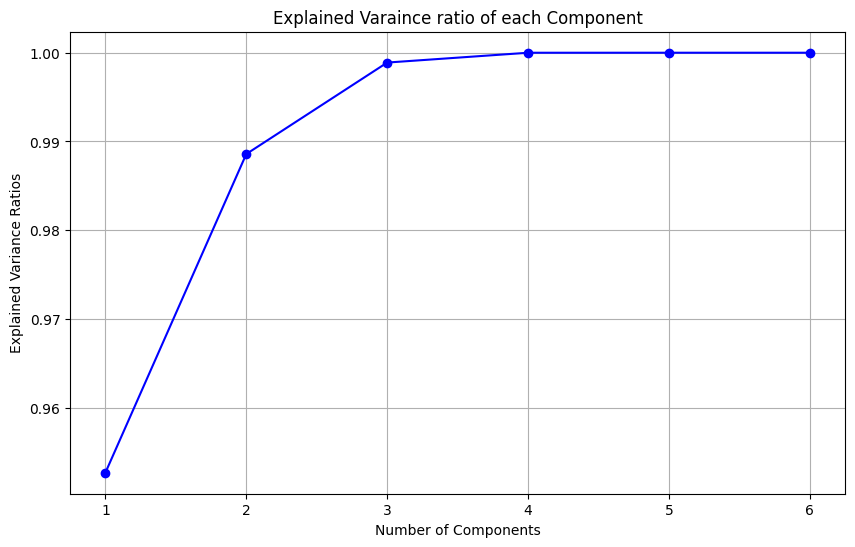

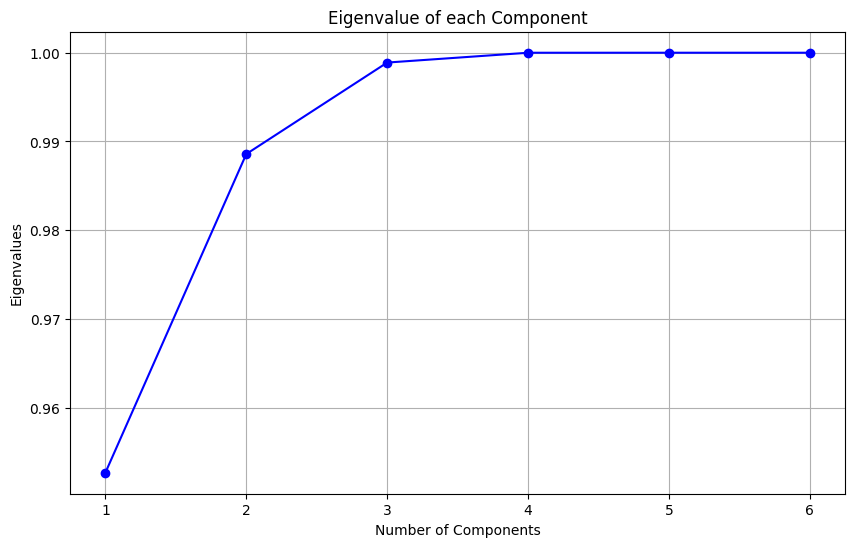

In [30]:
K = range(1, 7)
explained_variance_ratios = []
eigenvalues = []

for k in K:
    pca = PCA(n_components=k, random_state=42).fit(X_scale[multimodals])
    exp_var = np.sum(pca.explained_variance_ratio_)
    explained_variance_ratios.append(exp_var)

    eigenvalue = np.sum(pca.explained_variance_)
    eigenvalues.append(eigenvalue)



plt.figure(figsize = (10, 6))
plt.plot(K, explained_variance_ratios, "bo-")
plt.title("Explained Varaince ratio of each Component")
plt.xlabel("Number of Components")
plt.ylabel("Explained Variance Ratios")
plt.grid(True)
plt.show()


plt.figure(figsize = (10, 6))
plt.plot(K, explained_variance_ratios, "bo-")
plt.title("Eigenvalue of each Component")
plt.xlabel("Number of Components")
plt.ylabel("Eigenvalues")
plt.grid(True)
plt.show()

It seems that our intial observation was  almost correct but the optimal number of components for our current situation is 2 components.

In [31]:
pca = PCA(n_components=2, random_state = 42)

X_pca = pca.fit_transform(X_scale[multimodals])

X_pca = pd.DataFrame(X_pca)

print(f"The initial eigenvalues are:\n{list(np.round(pca.explained_variance_, decimals = 5))}")

for pc, vector in enumerate(pca.explained_variance_ratio_):
    print(f"The explained varaince ratio of PCA_{pc} is {vector}")

The initial eigenvalues are:
[np.float64(35.24994), np.float64(1.32941)]
The explained varaince ratio of PCA_0 is 0.9526492321180801
The explained varaince ratio of PCA_1 is 0.03592801507574817


### **Clustering with KMeans**

**What is KMeans?**

**KMeans** is another unsupervised algorithim the clusters data into different groups based on their similarities. As we observed from earlier from our features, some of our features do contain more than one modal and KMeans is here to confirm that.

**How does KMeans cluster our data?**

KMeans clusters our data by using inertia. KMeans main goal is to Partition a dataset into K clusters such that the within-cluster variance (inertia) is minimized. In other words, its main goal is to use inertia as it's objective function for minimization to determine the optimal number of clusters when we reach the elbow point.

Inertia's formula:

$$
\text{Inertia} = \sum_{i=1}^{n} \lVert X_i - C_i \rVert^2
$$

Objective function:

$$
\text{Inertia} = \sum_{k=1}^{K} \sum_{x_i \in C_k} \lVert x_i - \mu_k \rVert^2
$$

Where:

$\lVert x_i - \mu_k \rVert^2$ is the squared **Eucilidean distance** between a datapoint $x_i$ and the centroid of it's assigned cluster.

Algorithm Steps:

1. Initialization: Choose K nitial centroids (can be random or via KMeans++).

2. Assignment Step: For each data point 𝑥𝑖, assign it to the nearest centroid:

$$
C_k = \left\{ x_i : \lVert x_i - \mu_k \rVert^2 \leq \lVert x_i - \mu_j \rVert^2, \forall j = 1, \dots, K \right\}
$$

3. Update Step: Recalculate each centroid 𝜇𝑘 as the mean of all points in its cluster:

$$
\mu_k = \frac{1}{|C_k|} \sum_{x_i \in C_k} x_i
$$


4. Repeat: Steps 2 and 3 until convergence (e.g., no change in assignments or centroids).

K-Means is guaranteed to converge to a local minimum of the inertia function, but not necessarily the global minimum.

The elbow point in KMeans is considered the best **K** because it represents a **balance between model complexity and performance**.

As K Increases, the **inertia** (within cluster sum of squares) always decreases, but the rate of decrease starts to slow down after a certain point which is the elbow point. The elbow point is optimal because before the elbow point is where the data is underfit due to clusters being coarse, at the elbow you are capturing the natural structure of the data, after the elbow point is where the data is overfit because clusters are too fine and may capture noise.

In order to find out the seperation rating for each cluster, the silhouette score shines in that regard because it scores the seperability of each cluster whether they overlap or not.





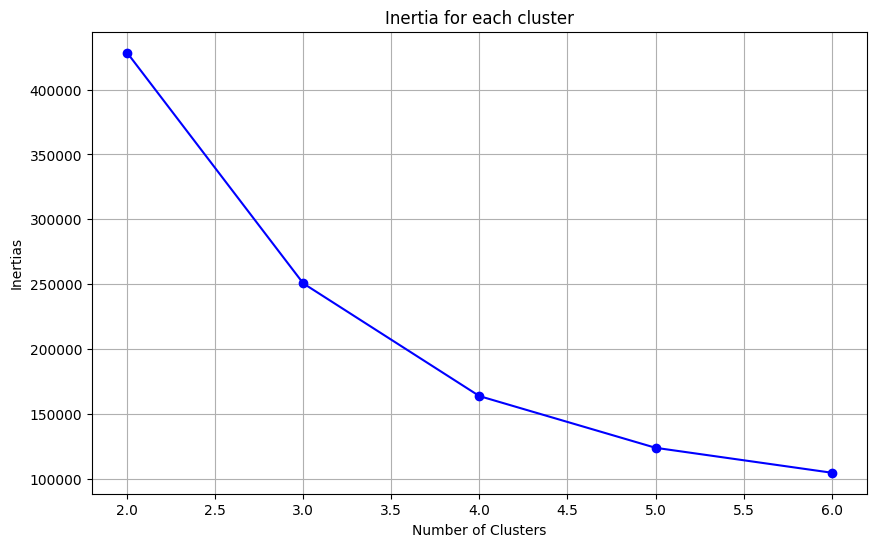

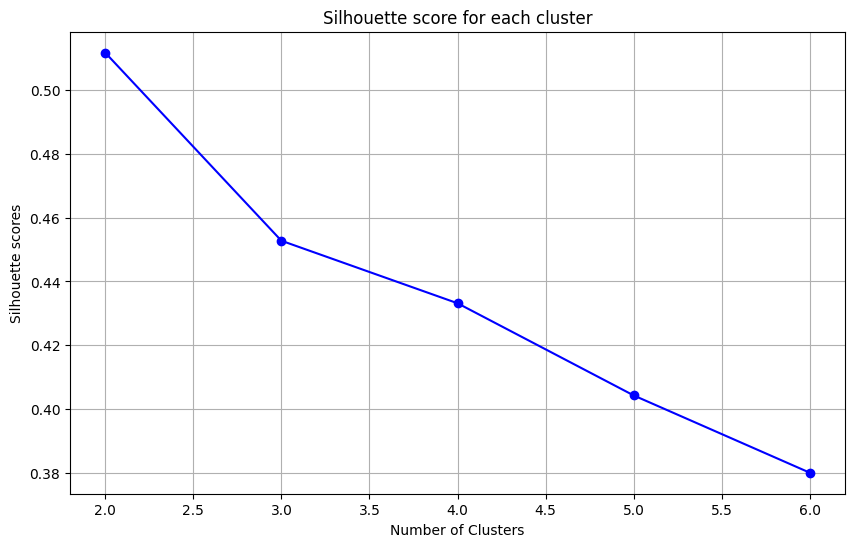

In [32]:
from sklearn.metrics import silhouette_score
K = range(2, 7)
inertias = []
silhouette_scores = []

for k in K:
    kmeans = KMeans(n_clusters=k, random_state = 42, init = "k-means++").fit(X_scale[multimodals])
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scale[multimodals], kmeans.labels_))


#plot the inertias of each cluster
plt.figure(figsize = (10, 6))
plt.plot(K, inertias, "bo-")
plt.title("Inertia for each cluster")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertias")
plt.grid(True)
plt.show()

#plot the silhouette score of each cluster
plt.figure(figsize = (10, 6))
plt.plot(K, silhouette_scores, "bo-")
plt.title("Silhouette score for each cluster")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette scores")
plt.grid(True)
plt.show()

According to the scree plot visulizations, it appears the elbow point for both visuals is at cluster 4. It's silhouette score is slightly smaller than 0.44 which is considered good in the financial field because a lot of randomness are introduced.

/tmp/ipykernel_235484/2381979143.py:10: UserWarning: The palette list has more values (6) than needed (4), which may not be intended.
  sns.scatterplot(x = X_pca[0], y = X_pca[1], hue = X_pca["clusters"], palette = sns.color_palette("viridis"))


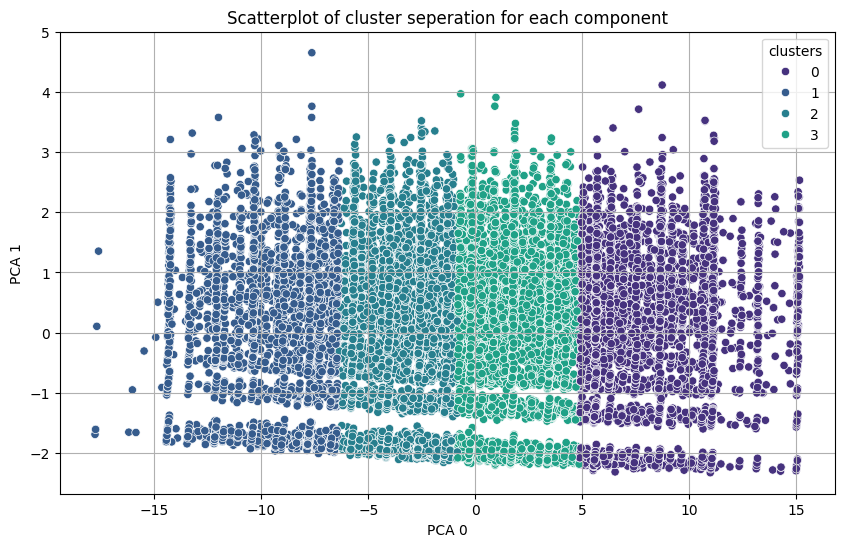

In [33]:
kmeans = KMeans(n_clusters=4, random_state=42).fit(X_scale[multimodals])

X_scale["clusters"] = kmeans.labels_
X_pca["clusters"] = kmeans.labels_


#plot the clusters to check the seperation

plt.figure(figsize = (10, 6))
sns.scatterplot(x = X_pca[0], y = X_pca[1], hue = X_pca["clusters"], palette = sns.color_palette("viridis"))
plt.title("Scatterplot of cluster seperation for each component")
plt.xlabel("PCA 0")
plt.ylabel("PCA 1")
plt.grid(True)
plt.show()

According to the PCA plot, we can clearly see that there are 3 seperations between each cluster indicating subgroups between features. The first seperation started at the y-axis between -1 and -1.5, the second seperation on the y-axis is between -0.75 and -1.25 and the third seperation is from 3 to -0.75.

In [34]:
from scipy.stats import mode
#map the clusters onto the original dataframe

credit_df["clusters"] = X_scale["clusters"]

def summarize_data(dataframe, features, stat, target_feature):
    """This function groups the data by the targeted feature and summarizes its statistics"""

    print(f"{stat.capitalize()} summary of clusters")
    print("-"*80)

    if stat == "mode":
        clusters_summary = dataframe.groupby(target_feature).agg({feature: lambda x: mode(x, keepdims=True)[0][0] for feature in features})
        display(clusters_summary)
    else:
        clusters_summary = dataframe.groupby(target_feature).agg({feature: stat for feature in features})
        display(clusters_summary)
        


statistics = ["mean", "median", "mode", "max", "min"]

for stat in statistics:
    summarize_data(credit_df, multimodals, stat, "clusters")

Mean summary of clusters
--------------------------------------------------------------------------------


person_age  person_income  person_emp_length     loan_amnt  \
clusters                                                               
0          28.298869   91361.254475           5.497780  19260.983818   
1          27.537053   49188.307323           4.277245   2464.249128   
2          27.595167   56380.482070           4.487146   5512.785501   
3          27.837123   67022.982216           4.846647  10080.490768   

          loan_percent_income  cb_person_cred_hist_length  
clusters                                                   
0                    0.259045                    6.037806  
1                    0.068895                    5.600262  
2                    0.128402                    5.672073  
3                    0.190530                    5.792809

Median summary of clusters
--------------------------------------------------------------------------------


person_age  person_income  person_emp_length  loan_amnt  \
clusters                                                            
0               26.0        76000.0                5.0    18000.0   
1               25.0        42000.0                3.0     2500.0   
2               26.0        49000.0                4.0     5500.0   
3               26.0        57500.0                4.0    10000.0   

          loan_percent_income  cb_person_cred_hist_length  
clusters                                                   
0                        0.24                         4.0  
1                        0.06                         4.0  
2                        0.11                         4.0  
3                        0.17                         4.0

Mode summary of clusters
--------------------------------------------------------------------------------


person_age  person_income  person_emp_length  loan_amnt  \
clusters                                                            
0               23.0        60000.0                2.0    15000.0   
1               23.0        30000.0                0.0     3000.0   
2               23.0        30000.0                0.0     5000.0   
3               23.0        60000.0                0.0    10000.0   

          loan_percent_income  cb_person_cred_hist_length  
clusters                                                   
0                        0.25                         3.0  
1                        0.04                         2.0  
2                        0.08                         3.0  
3                        0.15                         2.0

Max summary of clusters
--------------------------------------------------------------------------------


person_age  person_income  person_emp_length  loan_amnt  \
clusters                                                            
0               76.0       900000.0               38.0    35000.0   
1               78.0      1900000.0               41.0     3675.0   
2               94.0      1440000.0               27.0     7500.0   
3               84.0      2039784.0               34.0    14000.0   

          loan_percent_income  cb_person_cred_hist_length  
clusters                                                   
0                        0.83                        30.0  
1                        0.65                        30.0  
2                        0.71                        30.0  
3                        0.78                        30.0

Min summary of clusters
--------------------------------------------------------------------------------


person_age  person_income  person_emp_length  loan_amnt  \
clusters                                                            
0               20.0        19500.0                0.0    13900.0   
1               20.0         4000.0                0.0      500.0   
2               20.0         8000.0                0.0     3650.0   
3               20.0        12000.0                0.0     7400.0   

          loan_percent_income  cb_person_cred_hist_length  
clusters                                                   
0                        0.02                         2.0  
1                        0.00                         2.0  
2                        0.00                         2.0  
3                        0.00                         2.0

### 📊 Cluster Analysis of `loan_amnt` Using KMeans

#### 1. Clear Separation in Central Tendencies
- **Median Loan Amounts**:
  - Cluster 0: **$18,000** (High)
  - Cluster 3: **$10,000**
  - Cluster 2: **$5,500**
  - Cluster 1: **$2,500** (Low)

- **Mean Loan Amounts**:
  - Cluster 0: **$19,260.98**
  - Cluster 3: **$10,080.49**
  - Cluster 2: **$5,512.79**
  - Cluster 1: **$2,464.31**

> ✅ The medians and means increase logically across clusters, suggesting meaningful segmentation by loan size.

---

#### 2. Well-Separated Min/Max Ranges
- **Cluster 0**:  
  - Min: **$13,900**, Max: **$35,000**  
  - ↳ Clearly represents higher-value loans.

- **Cluster 1**:  
  - Min: **$500**, Max: **$3,675**  
  - ↳ Isolated cluster of small loans.

- **Cluster 2**:  
  - Min: **$3,650**, Max: **$7,500**  
  - ↳ Mid-range, leaning toward lower loans.

- **Cluster 3**:  
  - Min: **$7,400**, Max: **$14,000**  
  - ↳ Mid-high tier of borrowing.

> ✅ Min/max ranges are distinct, supporting the idea of non-overlapping and interpretable clusters.

---

#### 3. Distinct Loan Amount Modes
- **Cluster 0**: Mode = **$15,000**
- **Cluster 1**: Mode = **$3,000**
- **Cluster 2**: Mode = **$5,000**
- **Cluster 3**: Mode = **$10,000**

> ✅ Each cluster has a unique most frequent loan value, reinforcing their individuality.

---

### ✅ Conclusion
KMeans appears to have **separated `loan_amnt` effectively**, forming well-defined clusters by loan size bands:
- **Cluster 0**: High-value loans  
- **Cluster 1**: Very low-value loans  
- **Cluster 2**: Low-to-mid-value loans  
- **Cluster 3**: Mid-range loans

### 📊 Cluster Analysis of `person_income` Using KMeans

#### 1. Median Incomes Show Tiered Grouping
- **Cluster 0**: Median = **$76,000** (Highest)
- **Cluster 3**: Median = **$57,500**
- **Cluster 2**: Median = **$49,000**
- **Cluster 1**: Median = **$42,000** (Lowest)

> ✅ Medians follow a logical upward trend across clusters, indicating good stratification by income levels.

---

#### 2. Mean Incomes Confirm Group Spread
- **Cluster 0**: Mean = **$91,361.25**
- **Cluster 3**: Mean = **$67,022.98**
- **Cluster 2**: Mean = **$56,380.48**
- **Cluster 1**: Mean = **$49,188.31**

> ✅ Cluster 0 clearly represents higher-income individuals, while Clusters 1 and 2 reflect lower to middle incomes.

---

#### 3. Min and Max Ranges Show Skewness & Outliers
- **Minimum Incomes**:
  - Cluster 1: **$4,000**
  - Cluster 2: **$8,000**
  - Cluster 3: **$12,000**
  - Cluster 0: **$19,500**

- **Maximum Incomes**:
  - Cluster 0: **$900,000**
  - Cluster 1: **$1,900,000**
  - Cluster 2: **$1,440,000**
  - Cluster 3: **$2,039,784**

> ⚠️ All clusters contain high outliers. The wide spread of max incomes—especially in Clusters 1 and 3—suggests right skewness and potential cluster overlap.

---

#### 4. Mode Incomes Indicate Common Earning Levels
- **Cluster 0**: Mode = **$60,000**
- **Cluster 1**: Mode = **$30,000**
- **Cluster 2**: Mode = **$60,000**
- **Cluster 3**: Mode = **$60,000**

> ℹ️ Mode values around $60,000 dominate most clusters, except Cluster 1, which further supports its distinction as a lower-income group.

---

### ✅ Conclusion
KMeans clustering shows:
- **Cluster 0**: High-income group
- **Cluster 1**: Lower-income earners
- **Cluster 2**: Mid-range earners
- **Cluster 3**: Upper-mid earners

However, **extreme income outliers** lead to **wide ranges and potential overlap**.

In [35]:
credit_df = credit_df.rename(columns = {"clusters": "loan_clusters"})
print(credit_df["loan_clusters"].value_counts())
display(credit_df.head())

loan_clusters
3    10290
2     9063
0     6983
1     4588
Name: count, dtype: int64


person_age  person_income person_home_ownership  person_emp_length  \
1        21.0         9600.0                   OWN                5.0   
2        25.0         9600.0              MORTGAGE                1.0   
3        23.0        65500.0                  RENT                4.0   
4        24.0        54400.0                  RENT                8.0   
5        21.0         9900.0                   OWN                2.0   

  loan_intent loan_grade  loan_amnt  loan_int_rate  loan_status  \
1   EDUCATION          B     1000.0          11.14          0.0   
2     MEDICAL          C     5500.0          12.87          1.0   
3     MEDICAL          C    35000.0          15.23          1.0   
4     MEDICAL          C    35000.0          14.27          1.0   
5     VENTURE          A     2500.0           7.14          1.0   

   loan_percent_income cb_person_default_on_file  cb_person_cred_hist_length  \
1                 0.10                         N                         2.0   
2                 0.57                         N                         3.0   
3                 0.53                         N                         2.0   
4                 0.64                         Y                         4.0   
5                 0.25                         N                         2.0   

   loan_clusters  
1              1  
2              2  
3              0  
4              0  
5              1

In [36]:
kmeans = KMeans(n_clusters = 3, init="k-means++", random_state = 42).fit(X_scale[["cb_person_cred_hist_length"]])

X_scale["clusters"] = kmeans.labels_

credit_df["clusters"] = X_scale["clusters"]

for stat in statistics:
    summarize_data(credit_df, ["cb_person_cred_hist_length"], stat = stat, target_feature="clusters")

Mean summary of clusters
--------------------------------------------------------------------------------


cb_person_cred_hist_length
clusters                            
0                           3.696212
1                           9.805667
2                           2.000000

Median summary of clusters
--------------------------------------------------------------------------------


cb_person_cred_hist_length
clusters                            
0                                4.0
1                                9.0
2                                2.0

Mode summary of clusters
--------------------------------------------------------------------------------


cb_person_cred_hist_length
clusters                            
0                                3.0
1                                8.0
2                                2.0

Max summary of clusters
--------------------------------------------------------------------------------


cb_person_cred_hist_length
clusters                            
0                                5.0
1                               30.0
2                                2.0

Min summary of clusters
--------------------------------------------------------------------------------


cb_person_cred_hist_length
clusters                            
0                                3.0
1                                6.0
2                                2.0

In [37]:
def borrower_type(credit_history):
    if credit_history >= 0 and credit_history <= 2:
        return "Fresh"
    elif credit_history >= 3 and credit_history <= 10:
        return "Established"
    else:
        return "Veteran"


credit_df["borrower_type"] = credit_df["cb_person_cred_hist_length"].apply(borrower_type) 

print(credit_df["borrower_type"].value_counts())
display(credit_df.head())


borrower_type
Established    21765
Fresh           5786
Veteran         3373
Name: count, dtype: int64


person_age  person_income person_home_ownership  person_emp_length  \
1        21.0         9600.0                   OWN                5.0   
2        25.0         9600.0              MORTGAGE                1.0   
3        23.0        65500.0                  RENT                4.0   
4        24.0        54400.0                  RENT                8.0   
5        21.0         9900.0                   OWN                2.0   

  loan_intent loan_grade  loan_amnt  loan_int_rate  loan_status  \
1   EDUCATION          B     1000.0          11.14          0.0   
2     MEDICAL          C     5500.0          12.87          1.0   
3     MEDICAL          C    35000.0          15.23          1.0   
4     MEDICAL          C    35000.0          14.27          1.0   
5     VENTURE          A     2500.0           7.14          1.0   

   loan_percent_income cb_person_default_on_file  cb_person_cred_hist_length  \
1                 0.10                         N                         2.0   
2                 0.57                         N                         3.0   
3                 0.53                         N                         2.0   
4                 0.64                         Y                         4.0   
5                 0.25                         N                         2.0   

   loan_clusters  clusters borrower_type  
1              1         2         Fresh  
2              2         0   Established  
3              0         2         Fresh  
4              0         0   Established  
5              1         2         Fresh

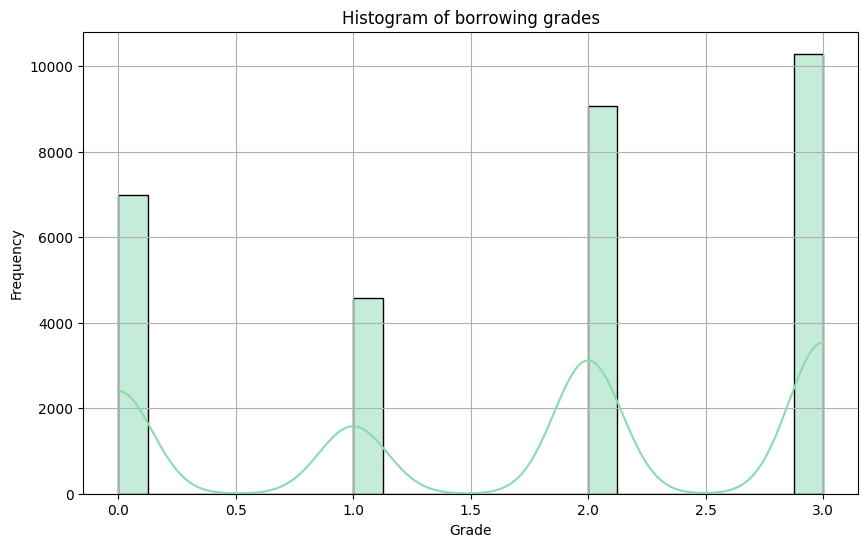

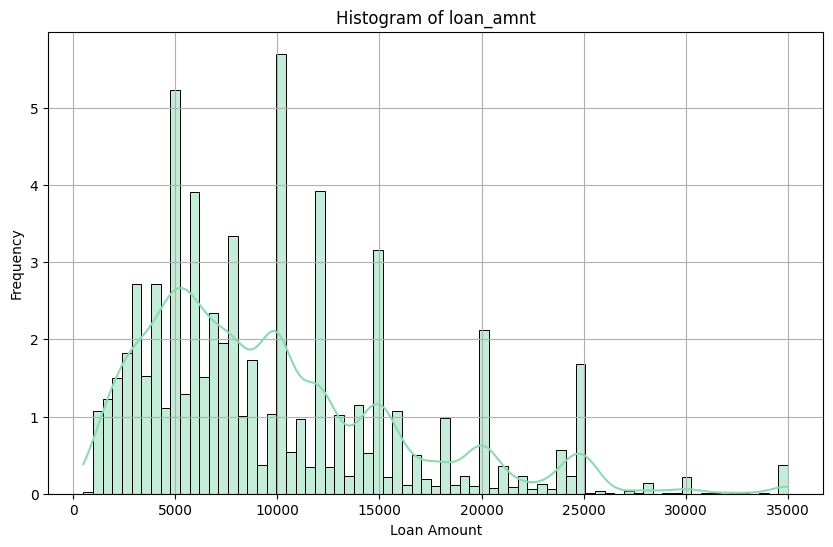

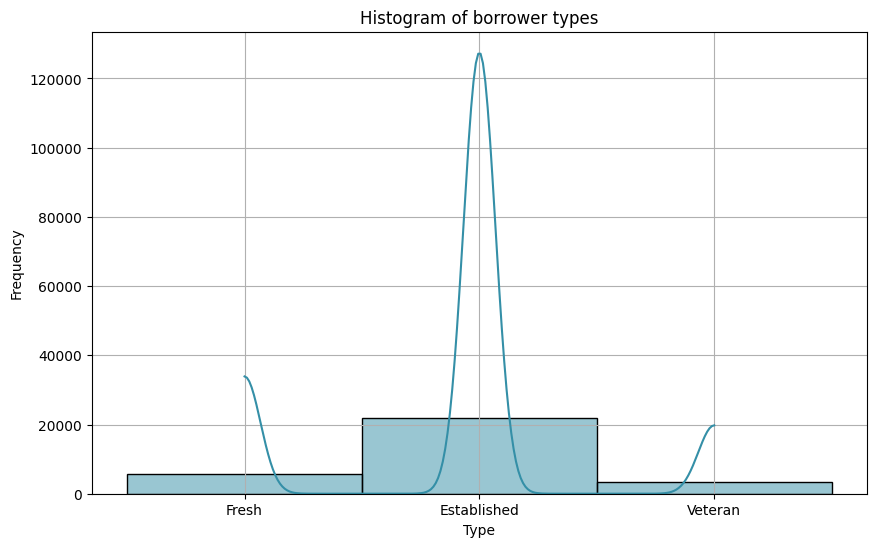

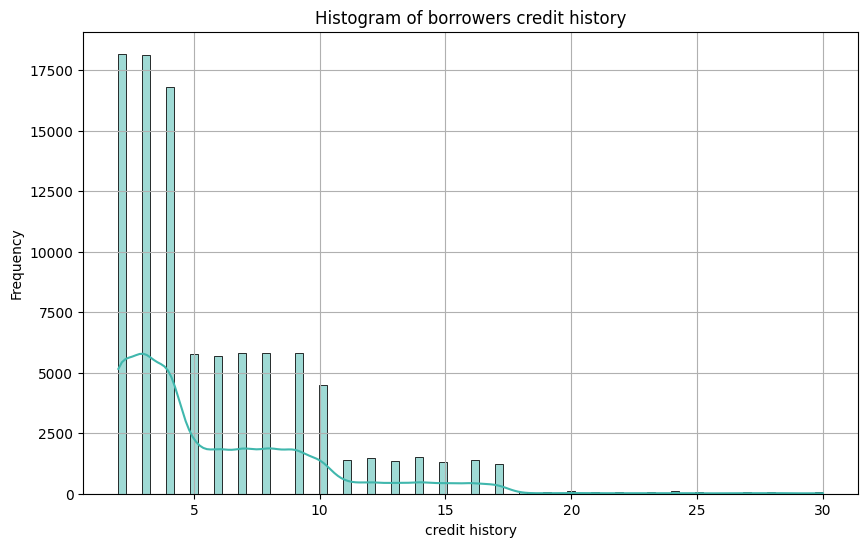

In [38]:
#comparing the new features with their original counterparts

plt.figure(figsize = (10, 6))
sns.histplot(x = credit_df["loan_clusters"], kde = True, stat = "count", color = random.choice(palette))
plt.title("Histogram of borrowing grades")
plt.xlabel("Grade")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


plt.figure(figsize = (10, 6))
sns.histplot(x = credit_df["loan_amnt"], kde = True, stat = "frequency", color = random.choice(palette))
plt.title("Histogram of loan_amnt")
plt.xlabel("Loan Amount")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


plt.figure(figsize = (10, 6))
sns.histplot(x = credit_df["borrower_type"], kde = True, stat = "frequency", color = random.choice(palette))
plt.title("Histogram of borrower types")
plt.xlabel("Type")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

plt.figure(figsize = (10, 6))
sns.histplot(x = credit_df["cb_person_cred_hist_length"], kde = True, stat = "frequency", color = random.choice(palette))
plt.title("Histogram of borrowers credit history")
plt.xlabel("credit history")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


In [39]:
credit_df = credit_df.drop(["clusters"], axis = 1)
ordinal_features

['loan_grade']

In [40]:
#we do not have to append the loan_clusters because they are already in ordinal form
ordinal_features.append("borrower_type")

In [41]:
from sklearn.preprocessing import LabelEncoder
def one_hot_encoder(dataframe, nominal_columns, drop_first = False):
    dataframe = pd.get_dummies(dataframe, columns = nominal_columns, drop_first=drop_first)
    return dataframe

label = LabelEncoder()

credit_train = credit_df.copy()


credit_train = one_hot_encoder(credit_train, nominal_features, drop_first=True)
credit_train[ordinal_features] = credit_train[ordinal_features]
for feature in ordinal_features:
    credit_train[feature] = label.fit_transform(credit_train[feature])
credit_train.head()

person_age  person_income  person_emp_length  loan_grade  loan_amnt  \
1        21.0         9600.0                5.0           1     1000.0   
2        25.0         9600.0                1.0           2     5500.0   
3        23.0        65500.0                4.0           2    35000.0   
4        24.0        54400.0                8.0           2    35000.0   
5        21.0         9900.0                2.0           0     2500.0   

   loan_int_rate  loan_percent_income  cb_person_cred_hist_length  \
1          11.14                 0.10                         2.0   
2          12.87                 0.57                         3.0   
3          15.23                 0.53                         2.0   
4          14.27                 0.64                         4.0   
5           7.14                 0.25                         2.0   

   loan_clusters  borrower_type  person_home_ownership_OTHER  \
1              1              1                        False   
2              2              0                        False   
3              0              1                        False   
4              0              0                        False   
5              1              1                        False   

   person_home_ownership_OWN  person_home_ownership_RENT  \
1                       True                       False   
2                      False                       False   
3                      False                        True   
4                      False                        True   
5                       True                       False   

   loan_intent_EDUCATION  loan_intent_HOMEIMPROVEMENT  loan_intent_MEDICAL  \
1                   True                        False                False   
2                  False                        False                 True   
3                  False                        False                 True   
4                  False                        False                 True   
5                  False                        False                False   

   loan_intent_PERSONAL  loan_intent_VENTURE  cb_person_default_on_file_Y  \
1                 False                False                        False   
2                 False                False                        False   
3                 False                False                        False   
4                 False                False                         True   
5                 False                 True                        False   

   loan_status_1.0  
1            False  
2             True  
3             True  
4             True  
5             True

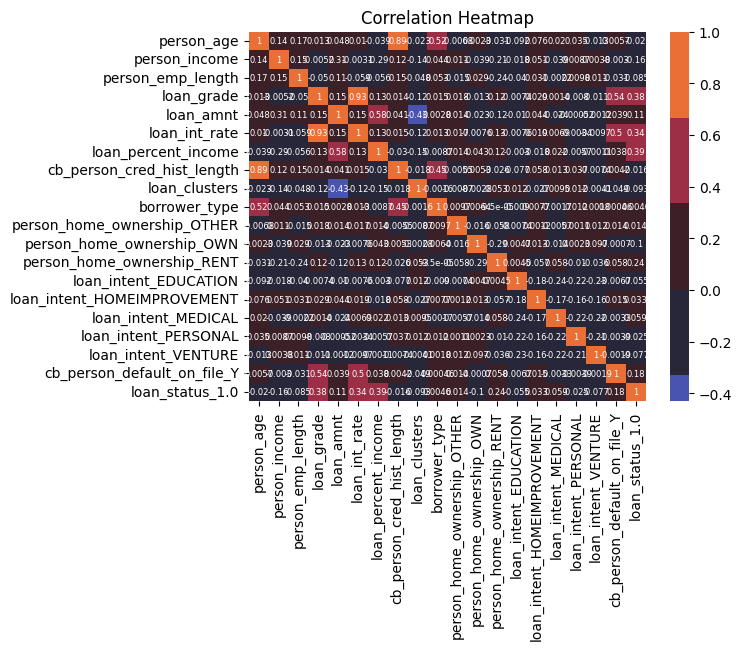

In [42]:
#check the correlations 
credit_training = credit_train.dropna()
plot_correlation(credit_train)

According to the correlations that we just printed above, the newly created features have no correlation with the interest rate compared to their original counterparts with the target feature. They are also not correlated with `loan_status` which is why i believe that it is best to drop them. However, we do have a better understanding of our data thanks to kmeans.

In [43]:
credit_training = credit_training.drop(["borrower_type", "loan_clusters"], axis = 1)

### **Linear Regression**


Linear Regression is a method used to model the relationship between a dependent variable (dependent feature) **${y}$** and one or more independent variables (independent features) **${x}$**. It assumes the relationship between the independent and dependent features are linear.

Linear Regression formula:

$$
{y} = \beta_{0} + \beta_{1}{x} + \epsilon
$$

Where:

$\beta_{x}$: Is the slope.

$\beta_{0}$: Is the intercept.

${x}$: Independent feature

${y}$: Dependent feature.

$\epsilon$: error term (residuals)


### **Multiple Linear Regression**

Multiple Linear Regression on the other hand has similar properties to the standard Linear Regression. It's only difference is that there are more than one independent features.

Multiple Regression formula:

$$
{y} = \beta_{0} + \beta_{1}{x}_{1} +  \beta_{2}{x}_{2} + ... + \beta_{n}{x}_{n}
$$

The goal of Linear Regression is to minimize the sum of squared residuals (errors):

$$
\min_{\boldsymbol{\beta}} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2
$$

so basically if we have 1000 data points, we plug those data points into this formula **${y} = \beta_{0} + \beta_{1}{x}_{1} +  \beta_{2}{x}_{2} + ... + \beta_{n}{x}_{n}$** to get the predicted values for each data point, and then plug it into this **minimum loss function: $\min_{\boldsymbol{\beta}} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2$**.


The loss function is called Oridnary Least Squares. The problem with Ordinary Least Squares (OLS) is the prescence of multicollinearity between independent features which leads to unstable and reliable coefficients(independent features coefficients).

1. High Variance of Coefficients: Small changes in the data can lead to large data swings in the OLS estimates.

2. Insignificant t-tests: Coefficients may appear statistically insignificant (high p-values), even when they are truly important.

3. Difficulty in interpreting Coefficients: It's hard to assess the individual effect of correlated predictors (independent coefficients).

4. Inflated Standard Errors: This Weakens the power of hypothesis tests.

**Mathematical Reasoning:**

OLS estimates coefficients using: 

$$
\hat{\beta} = (X^TX)^{-1}X^Ty
$$

If the matrix ${X}$ has highly correlated independent features, the matrix ${X^TX}$ becomes nearly singular, and it's inverse is unstable, leading to unreliable $\hat{\beta}$.

Luckily, our dataset does not contain multicollinearity which is why we do not have to introduce regularization methods such as **Ridge Regression (L2), Lasso Regression (L1), or ElasticNet Regression** (which is a combination of both ridge and lasso) because their predictive power will not be as strong as Linear Regression due to the abscence of multicollinearity.

**Ridge Regression (L2)** is recommended when multicollinearity is present, and you want to retain all features, even those correlated with each other. Ridge Regression is useful when all features are related to the target feature, and you wish to shrink their coefficients rather than eliminate them. **Lasso Regression (L1)** is ideal when the dataset contains many irrelevant features that are not correlated with the target feature but are highly correlated with other independent features. Lasso automatically performs feature selection by shrinking the coefficients of irrelevant features to zero, thereby simplifying the model.

Which leaves us with one question... "**What if our data are non-linear? Wouldn't Linear Regression be not as powerful?**"

The answer to this question is **No**, Linear Regression would not be as powerful as one would think it would be when non-linear data is present and evenfurther, heteroscedasticity will be present, within our data. This is where the power of **Decision Trees** comes in handy.

### **Decision Trees**

In mathematics and machine learning, **Decision Trees** are a type of supervised learning algorithm used for classification and regression. They represent decisions and their possible consequences as a tree-like model of choices. It does that by splitting data into subsets based on feature values, forming a tree-like structure of deciisons. Each tree contains leaves (nodes). At each leaf node, the algorithm selects the best feature and threshold that optimally splits the data to improve predicition accuracy.

Each internal leaf node, represents a test on a feature, each branch represents the outcome of a test. The outcomes leads to two directions in a branch, right and left. In classification, if the outcome is True, the test continues on the right and if the outcome is False, the test continues to the left until there are no more branches to run through. In regression however, a specific threshold between values are set for both right and left leaf nodes, for example, let us say we have a threshold of interest rates being **Interest Rate >= 20%**  on the left and **Interest Rate <= 15%** on the right, if the interest rate is higher or equals to 20%, the test continues to the left and if the interest rate is less than or equals to 15%, the test continues to the right.

**Image illustration:**

<img src = "unnamed.jpg" width = 900px, height = 500px>


**Mathematical Breakdown:**

At Each split, the algorithm tries to minimize impurity (classification) or minimize variance (regression).

- **Classification:**
    1. **Gini Impurity:**

    $$
    {Gini} = 1 - \sum_{i=1}^{C}{p}_{i}^2 
    $$

    Where ${p}_{i}$ is the probability of class i at the node.

    2. **Entropy (information gain):**

    $$
    {Entropy} = - \sum_{i=1}^{C}{p}_{i}{log}_{2}({p}_{i})
    $$

    **Information Gain** is the reduction in entropy:

    $$
    {IG} = {Entropy}_{parent} - \sum_{k}({N}_{k}/{N}){Entropy}
    $$


- **Regression:**

    The algorithm aims to minimize mean squared error (MSE) at each split:

    $$
    {MSE} = 1/n \sum_{i=1}^{n}({y}_{i} - \bar{y})^2
    $$

    Where $\bar{y}$ is the mean of the target in that node.

    The best split is the one that minimizes the weighted average of MSE of the resulting child nodes.


#### **Predicting loan_int_rate with Multiple Regression Models**

In [44]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error

X_lr = credit_training.drop(["loan_int_rate"], axis = 1)
Y_lr = credit_training["loan_int_rate"]


X_train, X_test, y_train, y_test = train_test_split(X_lr, Y_lr, test_size = 0.2, random_state = 42, shuffle = True)

linear_reg = LinearRegression().fit(X_train, y_train)


def model_training(X_train, X_test, y_train, y_test, model):

    y_pred_train = model.predict(X_train)

    y_pred_test = model.predict(X_test)

    MSE_train = mean_squared_error(y_train, y_pred_train) 
    RMSE_train = np.sqrt(MSE_train)
    MAE_train = mean_absolute_error(y_train, y_pred_train)
    r_square_train = model.score(X_train, y_train) 

    MSE_test = mean_squared_error(y_test, y_pred_test)
    RMSE_test = np.sqrt(MSE_test)
    MAE_test = mean_absolute_error(y_test, y_pred_test)
    r_square_test = model.score(X_test, y_test)

    

    print(f"Mean Squared Error training set {MSE_train:.2f}")
    print(f"Root Mean Squared Error training set {RMSE_train:.2f}")
    print(f"Mean Absolute Error training set {MAE_train:.2f}")
    print(f"R-Squared training set {r_square_train:.2f}")

    print(""*80)

    print(f"Mean Squared Error testing set {MSE_test:.2f}")
    print(f"Root Mean Squared Error testing set {RMSE_test:.2f}")
    print(f"Mean Absolute Error testing set {MAE_test:.2f}")
    print(f"R-Squared testing set {r_square_test:.2f}")

    model_metrics = {}
    #some models do not have the coefficient and intercept attribute because they are not linear models
    if hasattr(model, "coef_"):
        coefficients = model.coef_
        intercept = model.intercept_
        
        model_metrics = {"coefficients": coefficients,
                         "intercept": intercept,
                         "X_train" : X_train,
                         "X_test": X_test,
                         "y_train": y_train,
                         "y_test": y_test,
                         "y_pred_train": y_pred_train,
                         "y_pred_test": y_pred_test}

        return model_metrics
    
    elif hasattr(model, "oob_score_"):
        print(""*80)
        print(f"Out of Bag Score: {model.oob_score_:.2f}")
        model_metrics = {
                         "X_train" : X_train,
                         "X_test": X_test,
                         "y_train": y_train,
                         "y_test": y_test,
                         "y_pred_train": y_pred_train,
                         "y_pred_test": y_pred_test
                         }
        return model_metrics
    
    else:
        model_metrics = {
                         "X_train" : X_train,
                         "X_test": X_test,
                         "y_train": y_train,
                         "y_test": y_test,
                         "y_pred_train": y_pred_train,
                         "y_pred_test": y_pred_test
                         }
        return model_metrics

        

        
print("-"*80)
lr_model_metrics = model_training(X_train, X_test, y_train, y_test, linear_reg)

--------------------------------------------------------------------------------
Mean Squared Error training set 1.32
Root Mean Squared Error training set 1.15
Mean Absolute Error training set 0.90
R-Squared training set 0.87

Mean Squared Error testing set 1.36
Root Mean Squared Error testing set 1.16
Mean Absolute Error testing set 0.91
R-Squared testing set 0.87


In [45]:
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.tree import DecisionTreeRegressor

ridge = Ridge(random_state=42).fit(X_train, y_train)
lasso = Lasso(random_state=42).fit(X_train, y_train)
elastic = ElasticNet(random_state=42).fit(X_train, y_train)
xgb = XGBRegressor(random_state = 42).fit(X_train, y_train)
cat = CatBoostRegressor(random_state = 42).fit(X_train, y_train)
lgb = LGBMRegressor(random_state = 42).fit(X_train, y_train)
tree = DecisionTreeRegressor(random_state=42).fit(X_train, y_train)



ridge_model_metrics = model_training(X_train, X_test, y_train, y_test, ridge)

print("-"*80)

lasso_model_metrics = model_training(X_train, X_test, y_train, y_test, lasso)

print("-"*80)

elastic_model_metrics = model_training(X_train, X_test, y_train, y_test, elastic)

print("-"*80)

xgb_metrics = model_training(X_train, X_test, y_train, y_test, xgb)

print("-"*80)

cat_metrics = model_training(X_train, X_test, y_train, y_test, cat)

print("-"*80)

lgb_metrics = model_training(X_train, X_test, y_train, y_test, lgb)

print("-"*80)

tree_metrics = model_training(X_train, X_test, y_train, y_test, tree)

print("-"*80)

X_rf = credit_training.drop(["loan_int_rate"], axis = 1)
y_rf = credit_training["loan_int_rate"]

X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(X_rf, y_rf, random_state=42, shuffle = True, test_size = 0.2)

rf_regress = RandomForestRegressor(random_state=42, bootstrap = True, oob_score=True).fit(X_train_rf, y_train_rf)

rf_model_metrics = model_training(X_train_rf, X_test_rf, y_train_rf, y_test_rf, rf_regress)

Learning rate set to 0.066893
0:	learn: 3.0453249	total: 59ms	remaining: 58.9s
1:	learn: 2.8659801	total: 62.8ms	remaining: 31.3s
2:	learn: 2.6998297	total: 65.3ms	remaining: 21.7s
3:	learn: 2.5489141	total: 67.7ms	remaining: 16.9s
4:	learn: 2.4112129	total: 70.3ms	remaining: 14s
5:	learn: 2.2836106	total: 74.5ms	remaining: 12.3s
6:	learn: 2.1625465	total: 76.8ms	remaining: 10.9s
7:	learn: 2.0514027	total: 79ms	remaining: 9.79s
8:	learn: 1.9494313	total: 81.1ms	remaining: 8.93s
9:	learn: 1.8554787	total: 83.5ms	remaining: 8.27s
10:	learn: 1.7712206	total: 85.7ms	remaining: 7.71s
11:	learn: 1.6926513	total: 90.2ms	remaining: 7.43s
12:	learn: 1.6230056	total: 91.7ms	remaining: 6.96s
13:	learn: 1.5578199	total: 93.7ms	remaining: 6.6s
14:	learn: 1.4986365	total: 96.2ms	remaining: 6.32s
15:	learn: 1.4450755	total: 98.3ms	remaining: 6.05s
16:	learn: 1.3978245	total: 100ms	remaining: 5.81s
17:	learn: 1.3553713	total: 105ms	remaining: 5.71s
18:	learn: 1.3156710	total: 107ms	remaining: 5.52s
19

# 📊 Model Performance Comparison

## 🔢 Metrics Summary

| Model                    | Dataset | R²   | MAE  | MSE  | RMSE | OOB  |
|--------------------------|---------|------|------|------|------|------|
| **Linear Regression**    | Train   | 0.87 | 0.90 | 1.32 | 1.15 | -    |
|                          | Test    | 0.87 | 0.90 | 1.36 | 1.16 | -    |
| **Ridge Regression**     | Train   | 0.87 | 0.90 | 1.32 | 1.15 | -    |
|                          | Test    | 0.87 | 0.91 | 1.36 | 1.16 | -    |
| **Lasso Regression**     | Train   | 0.80 | 1.17 | 2.06 | 1.43 | -    |
|                          | Test    | 0.79 | 1.19 | 2.12 | 1.46 | -    |
| **ElasticNet Regression**| Train   | 0.75 | 1.32 | 2.58 | 1.60 | -    |
|                          | Test    | 0.74 | 1.34 | 2.64 | 1.62 | -    |
| **Random Forest**        | Train   | 0.99 | 0.29 | 0.14 | 0.37 | -    |
|                          | Test    | 0.90 | 0.78 | 1.02 | 1.01 | 0.91 |
| **XGBoost**              | Train   | 0.93 | 0.64 | 0.68 | 0.82 | -    |
|                          | Test    | 0.90 | 0.80 | 1.07 | 1.03 | -    |
| **CatBoost**             | Train   | 0.92 | 0.71 | 0.81 | 0.90 | -    |
|                          | Test    | 0.90 | 0.79 | 1.03 | 1.01 | -    |
| **LightGBM**             | Train   | 0.92 | 0.73 | 0.87 | 0.93 | -    |
|                          | Test    | 0.90 | 0.79 | 1.02 | 1.01 | -    |
| **Tree Regressor**       | Train   | 1.00 | 0.00 | 0.00 | 0.01 | -    |
|                          | Test    | 0.81 | 1.06 | 1.95 | 1.40 | -    |


---

## Definitions

**Mean Squared Error (MSE):**  The MSE is averaged squared difference of error between the actual values and the predicted values.

**Root Mean Squared Error (RMSE):** The RMSE is the square root of MSE with its main purpose being easier to interpret.

**Mean Absolute Error (MAE):** The MAE is the mean absolute difference of error between the actual and predicited values without taking direction into account.

**R-Squared (R²):** The R² is the score of how well the data is fitted in a linear line.

**Out of Bag Score (oob):** The out of bag score is a performence metric for a machine learning model, specifically for ensemble models such as random forests. It is calculated using the samples that are not used in the training of the model, which is called out of bag samples. These samples are used to provide an unbiased estimate of the model's performance, which is known as the OOB score.

## 📌 Observations

- **Linear Regression**:
  - Well-balanced, interpretable model.
  - Equal R² on train/test (0.87) → great generalization.
  - MAE ≈ 0.90 on both sets indicates stable prediction accuracy.

- **Ridge Regression**:
  - Same results as Linear Regression except RMSE being 1.17 in ridge

- **Lasso Regression**
    - worse than ridge regression
    - possibly due to dropping coefficients

- **Elastic-Net Regression**
    - Worst Performance
    - Lower R² (0.75 to 0.74)
    - possibly due to the combination of shrinking and dropping coefficients

- **XGBoost**
    - 2nd Best Model, with less overfitting compared to random forests


- **CatBoost**
    - 3rd Best Model, less overfit than XGBoost.

- **LightGBM**
    - Tied with CatBoost

- **Decision Tree Regressor**
    - Most overfit model.

- **Random Forest Regressor**:
  - Best test set R² (0.90) and lowest test MAE (0.78).
  - Slight overfitting: Train R² = 0.99, MAE = 0.29 | Test R² = 0.90, MAE = 0.78.
  - Less interpretable but powerful if prediction matters more.
  - The out of bag score is 0.91 for this random forest regressor, which means that the out of bag error is 0.09 which is relatively small.

---

### **Checking for Heteroscedastcity/Homogeneous patterns.**

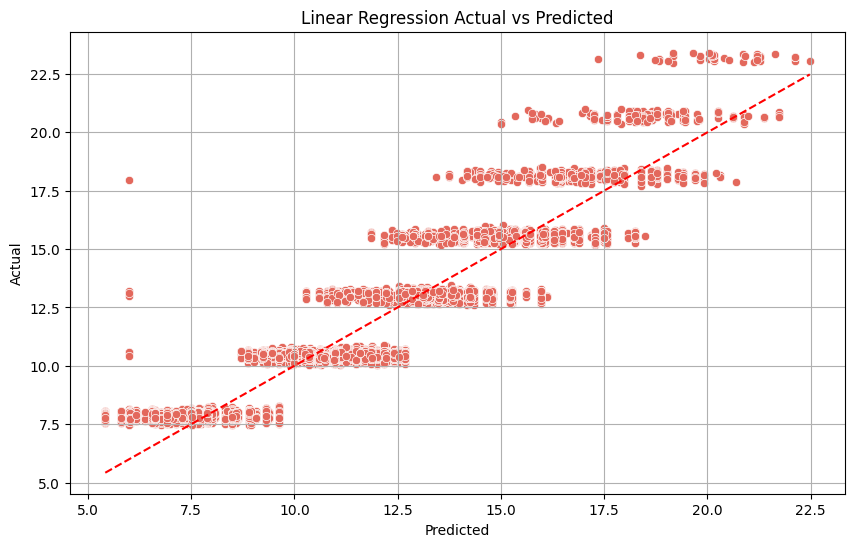

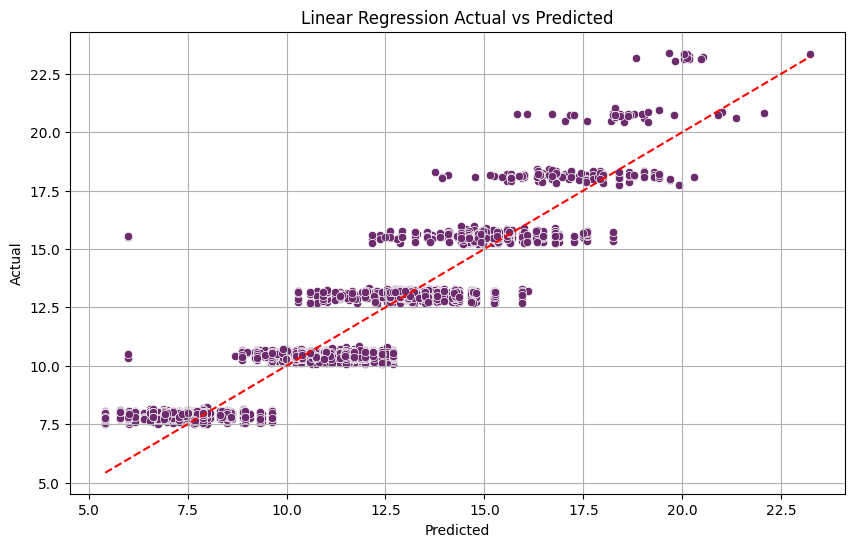

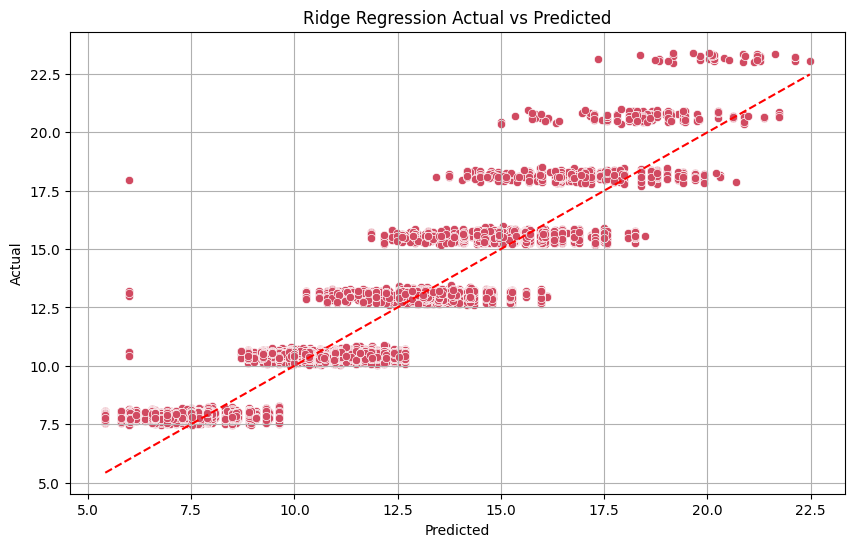

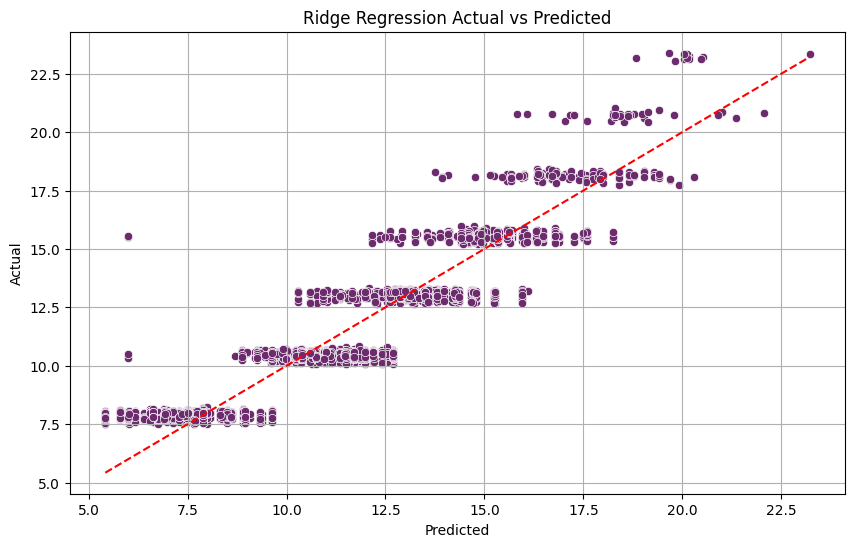

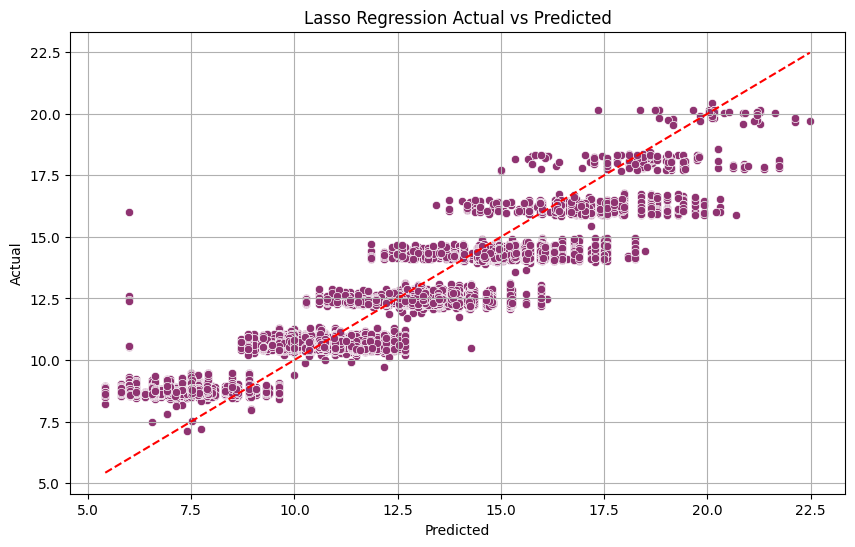

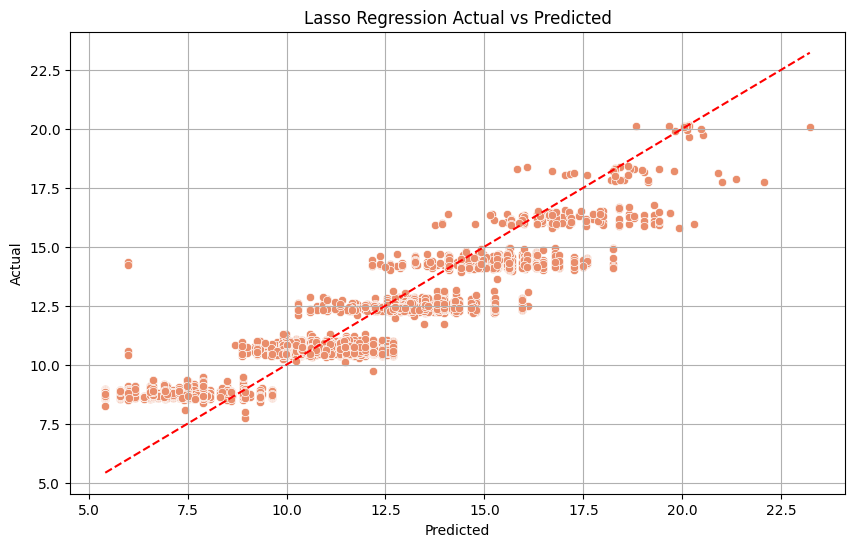

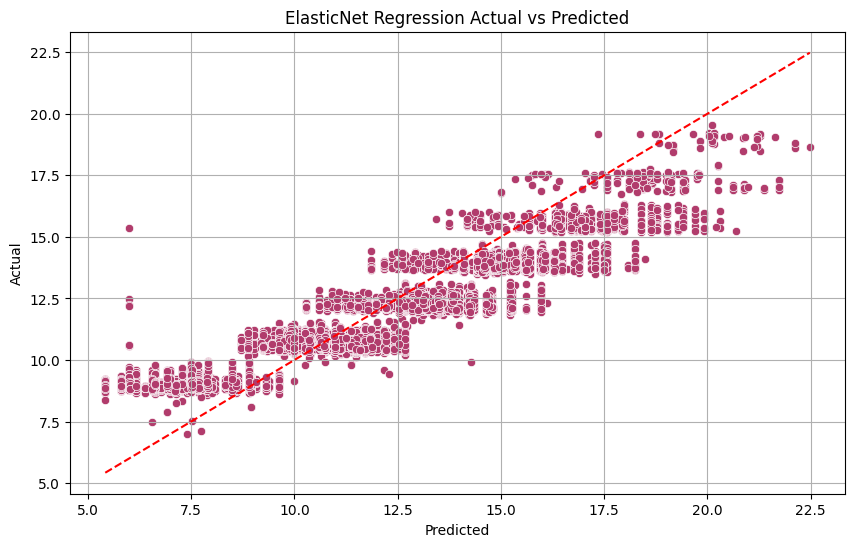

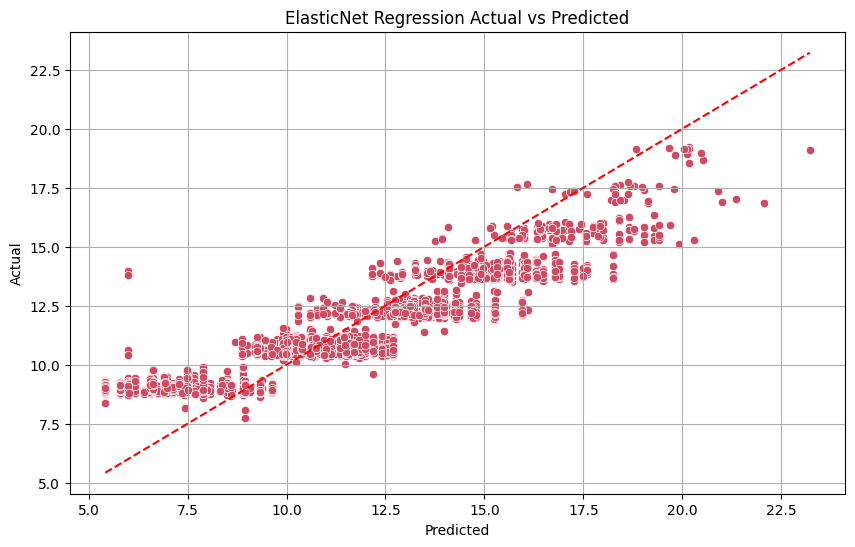

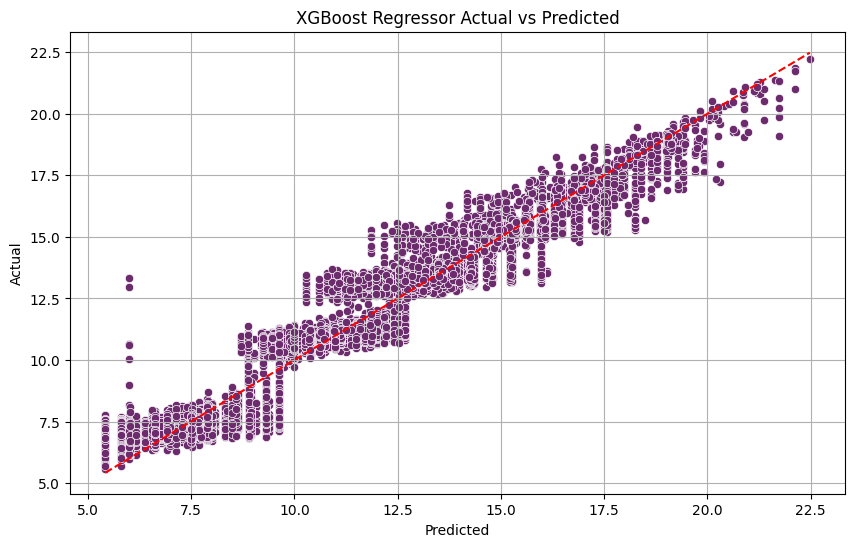

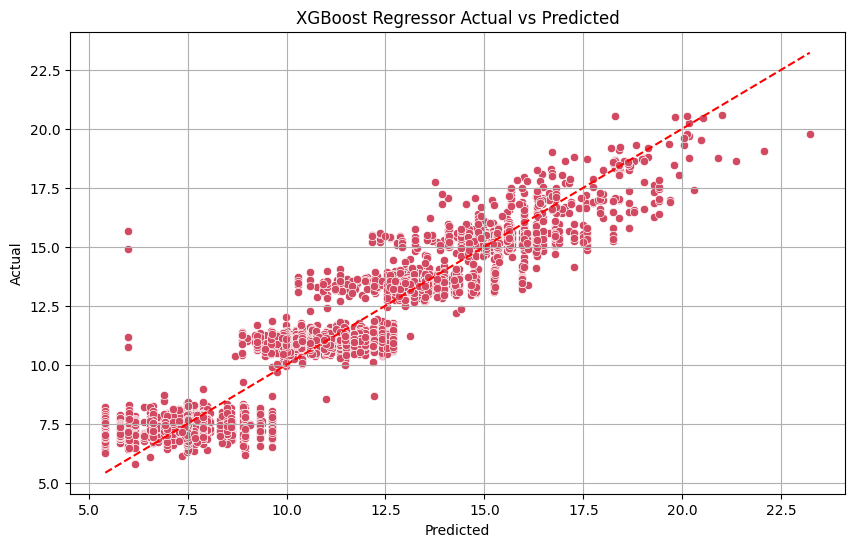

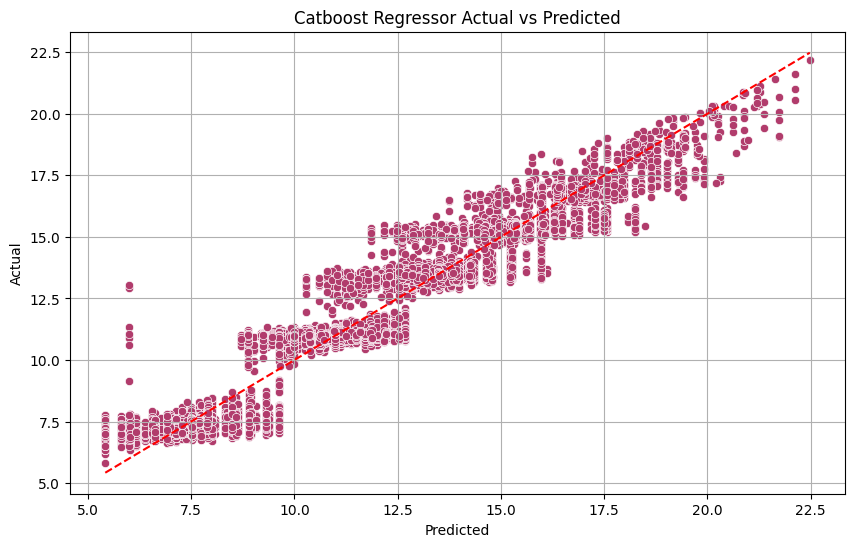

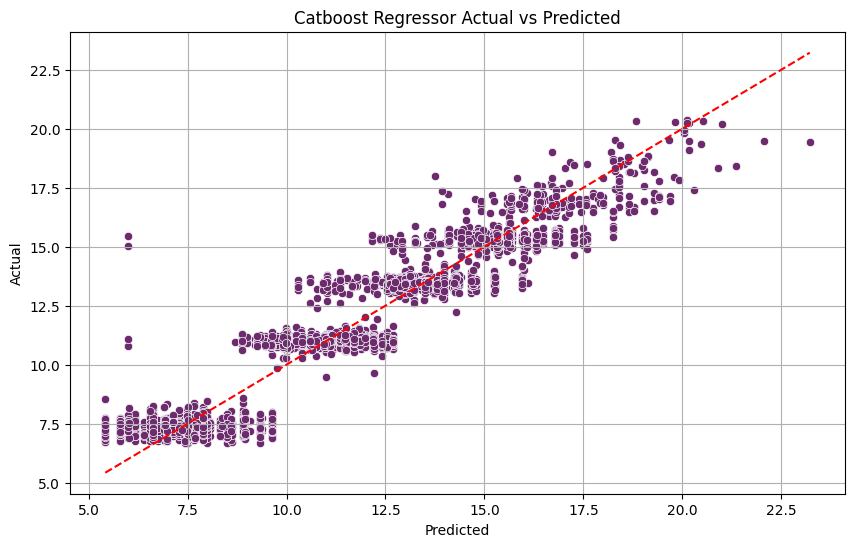

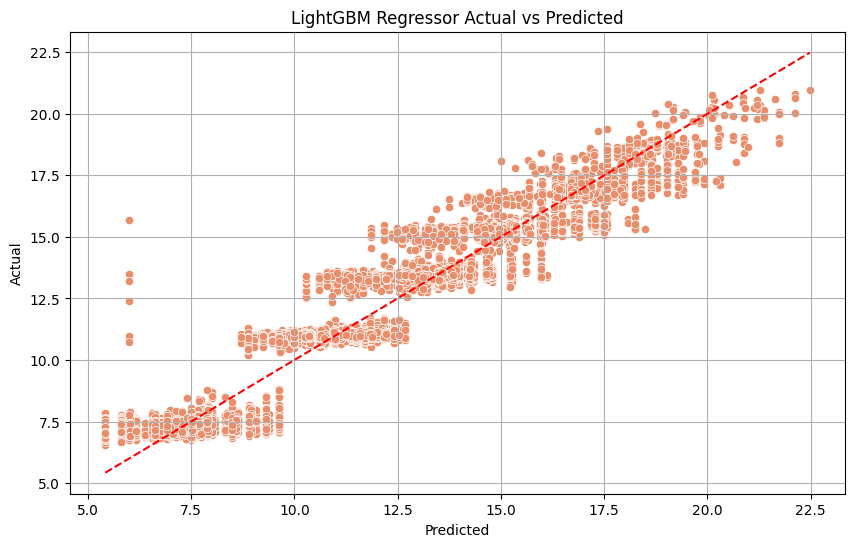

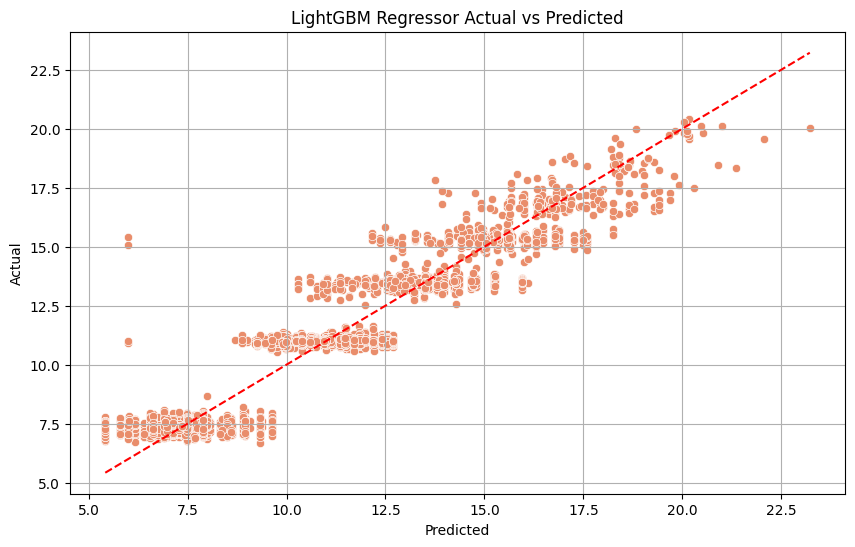

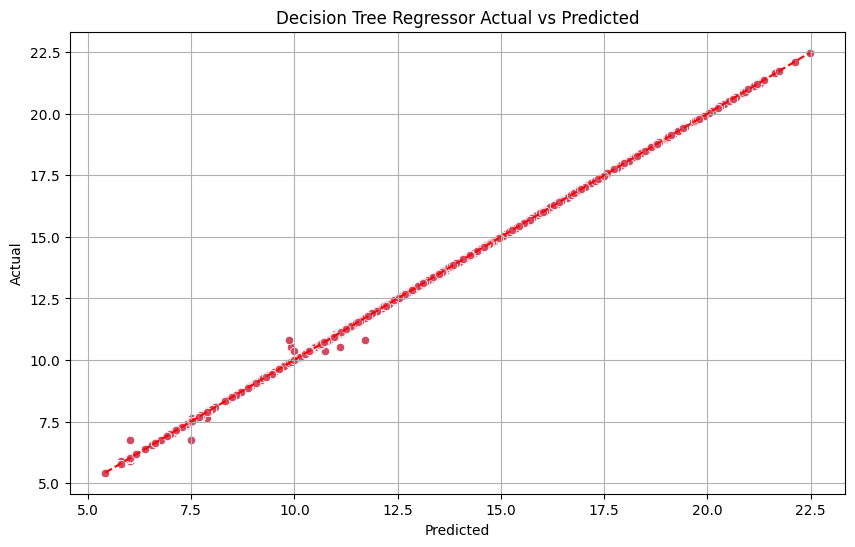

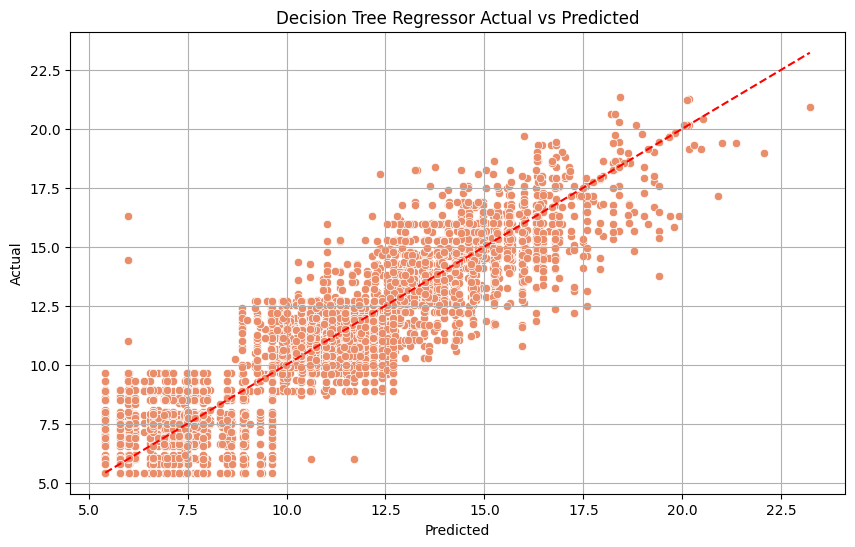

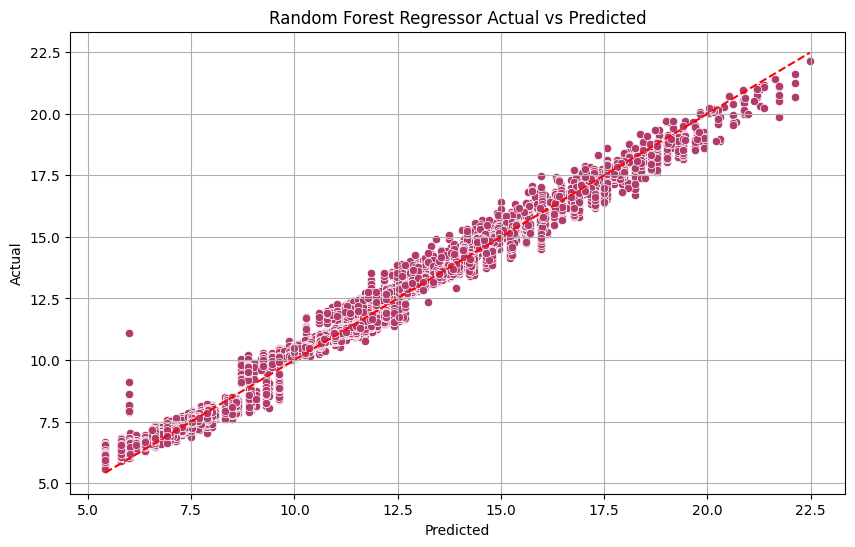

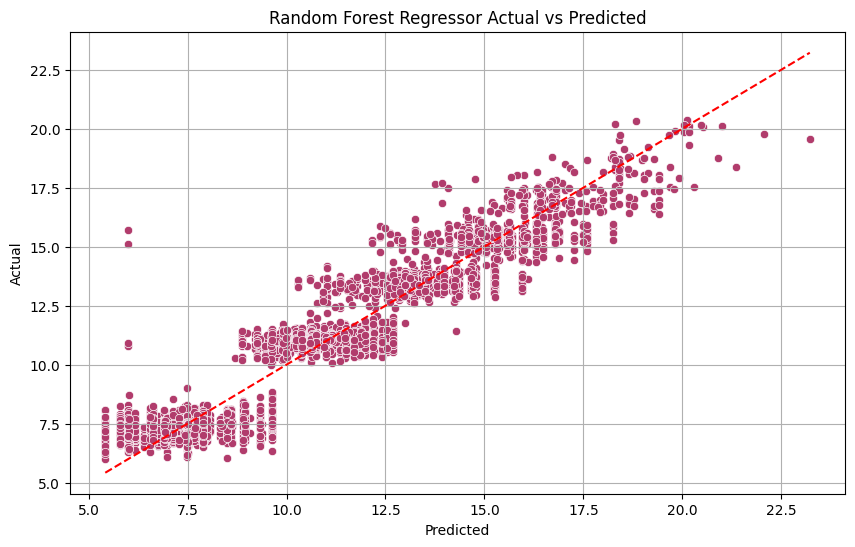

In [46]:
#Linear Regression
plt.figure(figsize = (10, 6))
sns.scatterplot(x = lr_model_metrics["y_train"], y = lr_model_metrics["y_pred_train"], color = random.choice(sns.color_palette("flare")))
plt.plot([lr_model_metrics["y_train"].min(), lr_model_metrics["y_train"].max()], [lr_model_metrics["y_train"].min(), lr_model_metrics["y_train"].max()], "r--")
plt.title("Linear Regression Actual vs Predicted")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.grid(True)
plt.show()

plt.figure(figsize = (10, 6))
sns.scatterplot(x = lr_model_metrics["y_test"], y = lr_model_metrics["y_pred_test"], color = random.choice(sns.color_palette("flare")))
plt.plot([lr_model_metrics["y_test"].min(), lr_model_metrics["y_test"].max()], [lr_model_metrics["y_test"].min(), lr_model_metrics["y_test"].max()], "r--")
plt.title("Linear Regression Actual vs Predicted")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.grid(True)
plt.show()


#Ridge Regression
plt.figure(figsize = (10, 6))
sns.scatterplot(x = ridge_model_metrics["y_train"], y = ridge_model_metrics["y_pred_train"],  color = random.choice(sns.color_palette("flare")))
plt.plot([ridge_model_metrics["y_train"].min(), ridge_model_metrics["y_train"].max()], [ridge_model_metrics["y_train"].min(), ridge_model_metrics["y_train"].max()], "r--")
plt.title("Ridge Regression Actual vs Predicted")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.grid(True)
plt.show()

plt.figure(figsize = (10, 6))
sns.scatterplot(x = ridge_model_metrics["y_test"], y = ridge_model_metrics["y_pred_test"],  color = random.choice(sns.color_palette("flare")))
plt.plot([ridge_model_metrics["y_test"].min(), ridge_model_metrics["y_test"].max()], [ridge_model_metrics["y_test"].min(), ridge_model_metrics["y_test"].max()], "r--")
plt.title("Ridge Regression Actual vs Predicted")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.grid(True)
plt.show()

#Lasso Regression
plt.figure(figsize = (10, 6))
sns.scatterplot(x = lasso_model_metrics["y_train"], y = lasso_model_metrics["y_pred_train"],  color = random.choice(sns.color_palette("flare")))
plt.plot([lasso_model_metrics["y_train"].min(), lasso_model_metrics["y_train"].max()], [lasso_model_metrics["y_train"].min(), lasso_model_metrics["y_train"].max()], "r--")
plt.title("Lasso Regression Actual vs Predicted")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.grid(True)
plt.show()

plt.figure(figsize = (10, 6))
sns.scatterplot(x = lasso_model_metrics["y_test"], y = lasso_model_metrics["y_pred_test"],  color = random.choice(sns.color_palette("flare")))
plt.plot([lasso_model_metrics["y_test"].min(), lasso_model_metrics["y_test"].max()], [lasso_model_metrics["y_test"].min(), lasso_model_metrics["y_test"].max()], "r--")
plt.title("Lasso Regression Actual vs Predicted")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.grid(True)
plt.show()

#ElasticNet Regression
plt.figure(figsize = (10, 6))
sns.scatterplot(x = elastic_model_metrics["y_train"], y = elastic_model_metrics["y_pred_train"],  color = random.choice(sns.color_palette("flare")))
plt.plot([elastic_model_metrics["y_train"].min(), elastic_model_metrics["y_train"].max()], [elastic_model_metrics["y_train"].min(), elastic_model_metrics["y_train"].max()], "r--")
plt.title("ElasticNet Regression Actual vs Predicted")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.grid(True)
plt.show()

plt.figure(figsize = (10, 6))
sns.scatterplot(x = elastic_model_metrics["y_test"], y = elastic_model_metrics["y_pred_test"],  color = random.choice(sns.color_palette("flare")))
plt.plot([elastic_model_metrics["y_train"].min(), elastic_model_metrics["y_test"].max()], [elastic_model_metrics["y_test"].min(), elastic_model_metrics["y_test"].max()], "r--")
plt.title("ElasticNet Regression Actual vs Predicted")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.grid(True)
plt.show()


#XGBRegressor
plt.figure(figsize = (10, 6))
sns.scatterplot(x = xgb_metrics["y_train"], y = xgb_metrics["y_pred_train"],  color = random.choice(sns.color_palette("flare")))
plt.plot([xgb_metrics["y_train"].min(), xgb_metrics["y_train"].max()], [xgb_metrics["y_train"].min(), xgb_metrics["y_train"].max()], "r--")
plt.title("XGBoost Regressor Actual vs Predicted")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.grid(True)
plt.show()

plt.figure(figsize = (10, 6))
sns.scatterplot(x = xgb_metrics["y_test"], y = xgb_metrics["y_pred_test"],  color = random.choice(sns.color_palette("flare")))
plt.plot([xgb_metrics["y_train"].min(), xgb_metrics["y_test"].max()], [xgb_metrics["y_test"].min(), xgb_metrics["y_test"].max()], "r--")
plt.title("XGBoost Regressor Actual vs Predicted")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.grid(True)
plt.show()

#Catboost
plt.figure(figsize = (10, 6))
sns.scatterplot(x = cat_metrics["y_train"], y = cat_metrics["y_pred_train"],  color = random.choice(sns.color_palette("flare")))
plt.plot([cat_metrics["y_train"].min(), cat_metrics["y_train"].max()], [cat_metrics["y_train"].min(), cat_metrics["y_train"].max()], "r--")
plt.title("Catboost Regressor Actual vs Predicted")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.grid(True)
plt.show()

plt.figure(figsize = (10, 6))
sns.scatterplot(x = cat_metrics["y_test"], y = cat_metrics["y_pred_test"],  color = random.choice(sns.color_palette("flare")))
plt.plot([cat_metrics["y_train"].min(), cat_metrics["y_test"].max()], [cat_metrics["y_test"].min(), cat_metrics["y_test"].max()], "r--")
plt.title("Catboost Regressor Actual vs Predicted")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.grid(True)
plt.show()

#LightGBM
plt.figure(figsize = (10, 6))
sns.scatterplot(x = lgb_metrics["y_train"], y = lgb_metrics["y_pred_train"],  color = random.choice(sns.color_palette("flare")))
plt.plot([lgb_metrics["y_train"].min(), lgb_metrics["y_train"].max()], [lgb_metrics["y_train"].min(), lgb_metrics["y_train"].max()], "r--")
plt.title("LightGBM Regressor Actual vs Predicted")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.grid(True)
plt.show()

plt.figure(figsize = (10, 6))
sns.scatterplot(x = lgb_metrics["y_test"], y = lgb_metrics["y_pred_test"],  color = random.choice(sns.color_palette("flare")))
plt.plot([lgb_metrics["y_train"].min(), lgb_metrics["y_test"].max()], [lgb_metrics["y_test"].min(), lgb_metrics["y_test"].max()], "r--")
plt.title("LightGBM Regressor Actual vs Predicted")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.grid(True)
plt.show()

#Decision Tree Regressor
plt.figure(figsize = (10, 6))
sns.scatterplot(x = tree_metrics["y_train"], y = tree_metrics["y_pred_train"],  color = random.choice(sns.color_palette("flare")))
plt.plot([tree_metrics["y_train"].min(), tree_metrics["y_train"].max()], [tree_metrics["y_train"].min(), tree_metrics["y_train"].max()], "r--")
plt.title("Decision Tree Regressor Actual vs Predicted")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.grid(True)
plt.show()

plt.figure(figsize = (10, 6))
sns.scatterplot(x = tree_metrics["y_test"], y = tree_metrics["y_pred_test"],  color = random.choice(sns.color_palette("flare")))
plt.plot([tree_metrics["y_train"].min(), tree_metrics["y_test"].max()], [tree_metrics["y_test"].min(), tree_metrics["y_test"].max()], "r--")
plt.title("Decision Tree Regressor Actual vs Predicted")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.grid(True)
plt.show()

#Random Forest Regressor
plt.figure(figsize = (10, 6))
sns.scatterplot(x = rf_model_metrics["y_train"], y = rf_model_metrics["y_pred_train"],  color = random.choice(sns.color_palette("flare")))
plt.plot([rf_model_metrics["y_train"].min(), rf_model_metrics["y_train"].max()], [rf_model_metrics["y_train"].min(), rf_model_metrics["y_train"].max()], "r--")
plt.title("Random Forest Regressor Actual vs Predicted")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.grid(True)
plt.show()

plt.figure(figsize = (10, 6))
sns.scatterplot(x = rf_model_metrics["y_test"], y = rf_model_metrics["y_pred_test"],  color = random.choice(sns.color_palette("flare")))
plt.plot([rf_model_metrics["y_test"].min(), rf_model_metrics["y_test"].max()], [rf_model_metrics["y_test"].min(), rf_model_metrics["y_test"].max()], "r--")
plt.title("Random Forest Regressor Actual vs Predicted")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.grid(True)
plt.show()

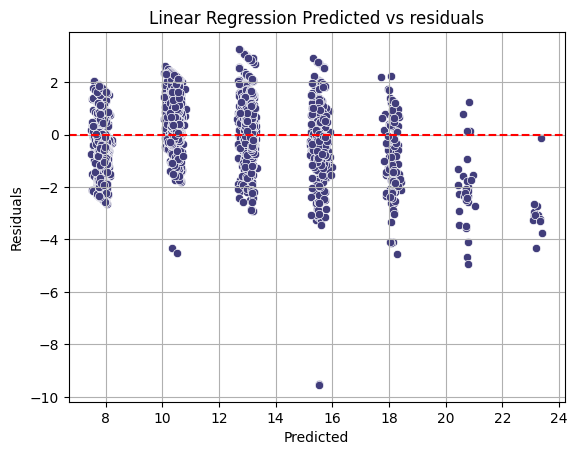

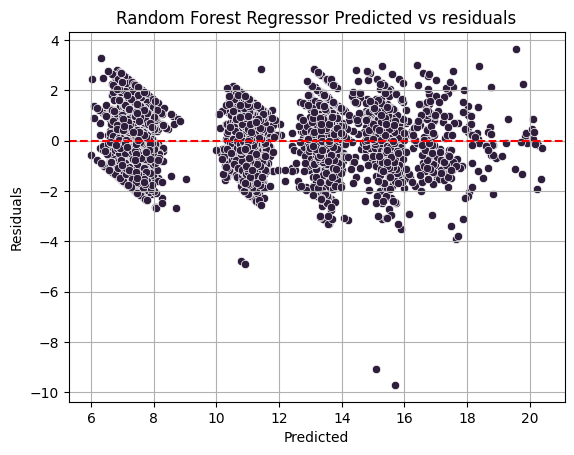

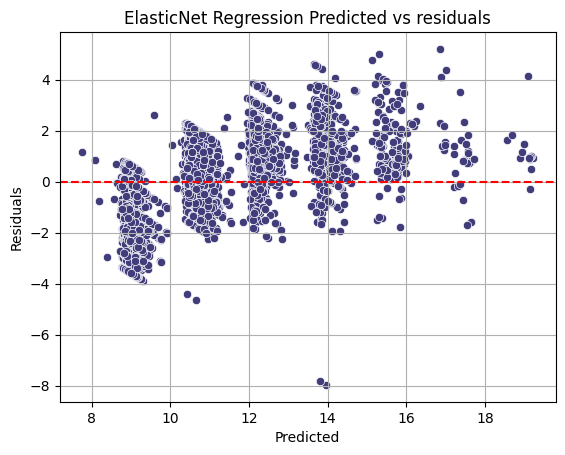

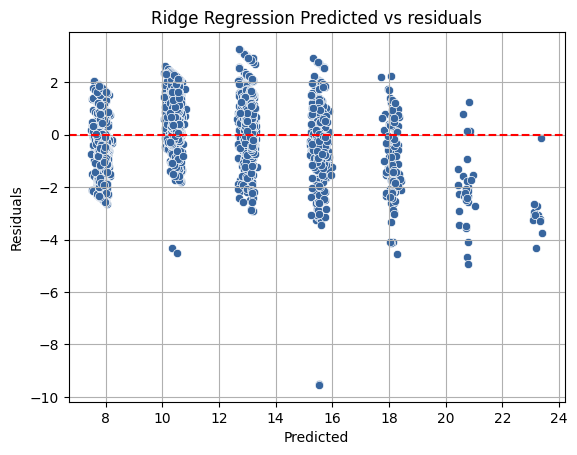

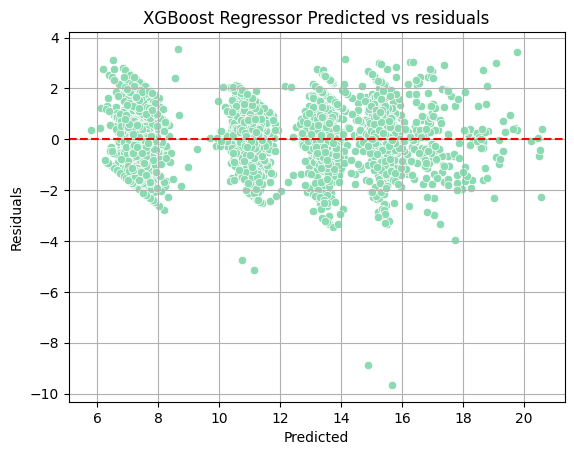

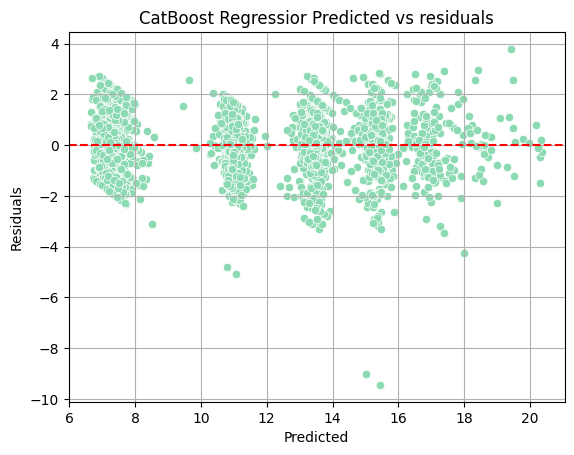

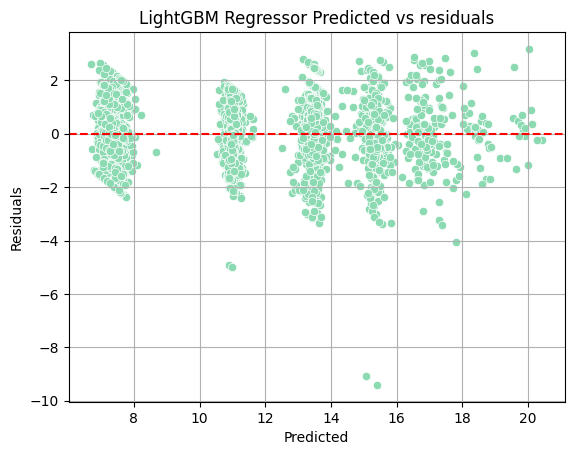

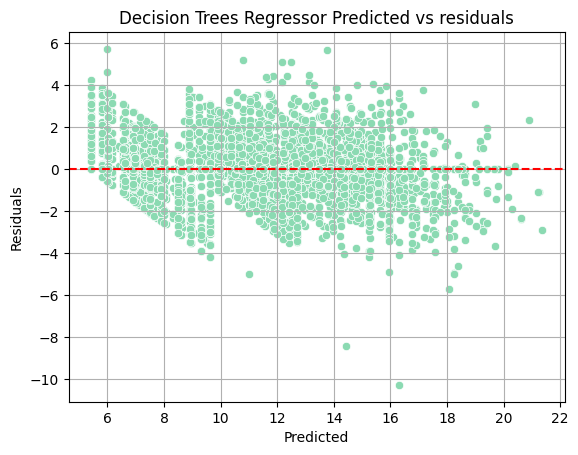

In [47]:
residuals_lr = lr_model_metrics["y_test"] - lr_model_metrics["y_pred_test"]
sns.scatterplot(x = lr_model_metrics["y_pred_test"], y = residuals_lr, color = random.choice(palette))
plt.axhline(0, color = "red", linestyle = "--")
plt.xlabel("Predicted")
plt.ylabel("Residuals")
plt.title("Linear Regression Predicted vs residuals")
plt.grid(True)
plt.show()


residuals_lr = rf_model_metrics["y_test"] - rf_model_metrics["y_pred_test"]
sns.scatterplot(x = rf_model_metrics["y_pred_test"], y = residuals_lr, color = random.choice(palette))
plt.axhline(0, color = "red", linestyle = "--")
plt.xlabel("Predicted")
plt.ylabel("Residuals")
plt.title("Random Forest Regressor Predicted vs residuals")
plt.grid(True)
plt.show()


residuals_lr = elastic_model_metrics["y_test"] - elastic_model_metrics["y_pred_test"]
sns.scatterplot(x = elastic_model_metrics["y_pred_test"], y = residuals_lr, color = random.choice(palette))
plt.axhline(0, color = "red", linestyle = "--")
plt.xlabel("Predicted")
plt.ylabel("Residuals")
plt.title("ElasticNet Regression Predicted vs residuals")
plt.grid(True)
plt.show()

residuals_lr = ridge_model_metrics["y_test"] - ridge_model_metrics["y_pred_test"]
sns.scatterplot(x = ridge_model_metrics["y_pred_test"], y = residuals_lr, color = random.choice(palette))
plt.axhline(0, color = "red", linestyle = "--")
plt.xlabel("Predicted")
plt.ylabel("Residuals")
plt.title("Ridge Regression Predicted vs residuals")
plt.grid(True)
plt.show()

residuals_lr = xgb_metrics["y_test"] - xgb_metrics["y_pred_test"]
sns.scatterplot(x = xgb_metrics["y_pred_test"], y = residuals_lr, color = random.choice(palette))
plt.axhline(0, color = "red", linestyle = "--")
plt.xlabel("Predicted")
plt.ylabel("Residuals")
plt.title("XGBoost Regressor Predicted vs residuals")
plt.grid(True)
plt.show()

residuals_lr = cat_metrics["y_test"] - cat_metrics["y_pred_test"]
sns.scatterplot(x = cat_metrics["y_pred_test"], y = residuals_lr, color = random.choice(palette))
plt.axhline(0, color = "red", linestyle = "--")
plt.xlabel("Predicted")
plt.ylabel("Residuals")
plt.title("CatBoost Regressior Predicted vs residuals")
plt.grid(True)
plt.show()

residuals_lr = lgb_metrics["y_test"] - lgb_metrics["y_pred_test"]
sns.scatterplot(x = lgb_metrics["y_pred_test"], y = residuals_lr, color = random.choice(palette))
plt.axhline(0, color = "red", linestyle = "--")
plt.xlabel("Predicted")
plt.ylabel("Residuals")
plt.title("LightGBM Regressor Predicted vs residuals")
plt.grid(True)
plt.show()

residuals_lr = tree_metrics["y_test"] - tree_metrics["y_pred_test"]
sns.scatterplot(x = tree_metrics["y_pred_test"], y = residuals_lr, color = random.choice(palette))
plt.axhline(0, color = "red", linestyle = "--")
plt.xlabel("Predicted")
plt.ylabel("Residuals")
plt.title("Decision Trees Regressor Predicted vs residuals")
plt.grid(True)
plt.show()

### **Visualization Results**

When observing the Fitted Lines, heteroscedasticity patterns, and residuals, Its clear to me that **Decision Trees and XGBoost** are the clear winners. However, **Decision Trees are overfit** because they have perfect prediction patterns on the training set but poor predictive power on the testing set which is why we need to carefully tune in the hyperparameters in cross-validation to reduce overfitting and if possible improve it's predictive power on unseen data. **XGBoost** is slightly overfit mainly due to the built in regularization methods but has significantly better scoring metrics than Decision Trees, which is why we need to carefully tune in lambda to reduce regularization since our data does not contain **multicollinearity**. The reason why i picked Decision Trees to tune in alongside XGBoost eventhough it has the third worst performence metrics on the testing sets was because Decision trees had the least and if not signs of heteroscedasticity compared to other models (XGBoost is the second least), and i definitely believe that tuning it carefully by pruning is worth the trouble.

In [48]:
from sklearn.model_selection import cross_val_score

def cross_validate_model(model, model_metrics, cv = 5):

    scoring_metrics = ["explained_variance", "neg_mean_squared_error",
                   "neg_root_mean_squared_error", "neg_mean_absolute_error",
                   "r2"]

    for scoring in scoring_metrics:
        result = cross_val_score(model, model_metrics["X_train"], model_metrics["y_train"], cv = cv, scoring = scoring)
        print(f"Cross Validation Scores for {scoring} is: {result}. Mean Score: {result.mean():.2f}")
        print(""*80)

models = {
    tree: tree_metrics,
    xgb: xgb_metrics
}

for model, metrics in models.items():
    display(model)
    cross_validate_model(model, metrics, cv = 10)

DecisionTreeRegressor(random_state=42)

Cross Validation Scores for explained_variance is: [0.82169977 0.82826651 0.82112434 0.81867931 0.82039857 0.81426627
 0.8168401  0.80740911 0.83205822 0.82524206]. Mean Score: 0.82

Cross Validation Scores for neg_mean_squared_error is: [-1.85985484 -1.83726509 -1.8952572  -1.8979399  -1.89519383 -1.96146145
 -1.88417719 -1.95937906 -1.79508139 -1.79259196]. Mean Score: -1.88

Cross Validation Scores for neg_root_mean_squared_error is: [-1.36376495 -1.35545752 -1.37668341 -1.37765739 -1.37666039 -1.40052185
 -1.37265334 -1.39977822 -1.33980647 -1.33887713]. Mean Score: -1.37

Cross Validation Scores for neg_mean_absolute_error is: [-1.03794499 -1.04013864 -1.04794723 -1.04766696 -1.03595707 -1.06600179
 -1.0287047  -1.05257271 -1.01863535 -1.03061969]. Mean Score: -1.04

Cross Validation Scores for r2 is: [0.82149498 0.82818093 0.82109095 0.81864708 0.82034809 0.8142556
 0.81680381 0.80730036 0.83205396 0.82522124]. Mean Score: 0.82



XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=None, num_parallel_tree=None, ...)

Cross Validation Scores for explained_variance is: [0.90302073 0.9079578  0.90577167 0.89613289 0.9052009  0.90247954
 0.89806566 0.89770536 0.90900475 0.90194756]. Mean Score: 0.90

Cross Validation Scores for neg_mean_squared_error is: [-1.01047761 -0.98433037 -0.99846753 -1.08714271 -1.00143216 -1.03016058
 -1.04839719 -1.04042941 -0.97321729 -1.00646086]. Mean Score: -1.02

Cross Validation Scores for neg_root_mean_squared_error is: [-1.00522515 -0.99213425 -0.99923347 -1.04266136 -1.00071582 -1.01496827
 -1.02391268 -1.02001441 -0.98651776 -1.00322523]. Mean Score: -1.01

Cross Validation Scores for neg_mean_absolute_error is: [-0.78712156 -0.78374172 -0.78826834 -0.81984017 -0.78712612 -0.8050945
 -0.79772136 -0.79901771 -0.77652371 -0.79011959]. Mean Score: -0.79

Cross Validation Scores for r2 is: [0.90301645 0.90794647 0.90574637 0.89612079 0.90507082 0.90244694
 0.89806566 0.89767658 0.90894675 0.90186948]. Mean Score: 0.90



In [49]:
tree.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'random_state': 42,
 'splitter': 'best'}

In [50]:
from sklearn.model_selection import RandomizedSearchCV

tree_param_grid = {
    "max_depth": [None, 20, 50, 100],
    "max_features": [0.5, 0.7, 1.0],
    "max_leaf_nodes": [20, 50, 100],
    "min_samples_split": [2, 5, 7, 10],
    "criterion": ["squared_error"],
    "min_samples_leaf": [1, 2, 4]
            
}



grid_search = RandomizedSearchCV(
    estimator = DecisionTreeRegressor(random_state=42),
    param_distributions=  tree_param_grid,
    scoring = "neg_mean_squared_error",
    cv = 10,
    random_state= 42,
    verbose = 2,
    n_jobs = -1
)

best_params_fitted = grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_

print(f"Best Model: {grid_search.best_estimator_}")
print(f"Best Parameters are: {grid_search.best_params_}")

Fitting 10 folds for each of 10 candidates, totalling 100 fits
[CV] END criterion=squared_error, max_depth=100, max_features=1.0, max_leaf_nodes=100, min_samples_leaf=2, min_samples_split=2; total time=   0.2s[CV] END criterion=squared_error, max_depth=100, max_features=1.0, max_leaf_nodes=100, min_samples_leaf=2, min_samples_split=2; total time=   0.2s

[CV] END criterion=squared_error, max_depth=100, max_features=1.0, max_leaf_nodes=100, min_samples_leaf=2, min_samples_split=2; total time=   0.2s
[CV] END criterion=squared_error, max_depth=100, max_features=1.0, max_leaf_nodes=100, min_samples_leaf=2, min_samples_split=2; total time=   0.2s
[CV] END criterion=squared_error, max_depth=100, max_features=1.0, max_leaf_nodes=100, min_samples_leaf=2, min_samples_split=2; total time=   0.2s
[CV] END criterion=squared_error, max_depth=100, max_features=1.0, max_leaf_nodes=100, min_samples_leaf=2, min_samples_split=2; total time=   0.2s
[CV] END criterion=squared_error, max_depth=100, max_fe

In [51]:
best_tree = DecisionTreeRegressor(max_features = 1.0, max_leaf_nodes = 20, min_samples_split = 10,
                                         random_state = 42, max_depth = None, min_samples_leaf = 1).fit(X_train, y_train)

best_tree = model_training(X_train, X_test, y_train, y_test, best_tree)

Mean Squared Error training set 0.99
Root Mean Squared Error training set 0.99
Mean Absolute Error training set 0.78
R-Squared training set 0.91

Mean Squared Error testing set 1.03
Root Mean Squared Error testing set 1.01
Mean Absolute Error testing set 0.79
R-Squared testing set 0.90


In [52]:
tree_param_grid

{'max_depth': [None, 20, 50, 100],
 'max_features': [0.5, 0.7, 1.0],
 'max_leaf_nodes': [20, 50, 100],
 'min_samples_split': [2, 5, 7, 10],
 'criterion': ['squared_error'],
 'min_samples_leaf': [1, 2, 4]}

In [53]:
tree_params = {
    "max_depth": [None],
    "max_features": [0.7, 1.0],
    "max_leaf_nodes": [20, 30, 50],
    "min_samples_split": [10, 15],
    "min_samples_leaf": [1, 2],
    "criterion" : ["squared_error"]
}

tree_grid_search = GridSearchCV(
    estimator = DecisionTreeRegressor(
        max_features = 1.0, max_leaf_nodes = 20, min_samples_split = 10,
                                         random_state = 42, max_depth = None, min_samples_leaf = 1
    ),
    param_grid= tree_params,
    cv = 10,
    n_jobs = -1,
    verbose = 2,
    scoring = "neg_mean_squared_error"
).fit(X_train, y_train)


best_tree = tree_grid_search.best_estimator_

print(f"Best Model: {tree_grid_search.best_estimator_}")
print(f"Best Parameters are: {tree_grid_search.best_params_}")


Fitting 10 folds for each of 24 candidates, totalling 240 fits
[CV] END criterion=squared_error, max_depth=None, max_features=0.7, max_leaf_nodes=20, min_samples_leaf=1, min_samples_split=10; total time=   0.1s
[CV] END criterion=squared_error, max_depth=None, max_features=0.7, max_leaf_nodes=20, min_samples_leaf=1, min_samples_split=10; total time=   0.1s
[CV] END criterion=squared_error, max_depth=None, max_features=0.7, max_leaf_nodes=20, min_samples_leaf=1, min_samples_split=10; total time=   0.0s
[CV] END criterion=squared_error, max_depth=None, max_features=0.7, max_leaf_nodes=20, min_samples_leaf=1, min_samples_split=10; total time=   0.1s
[CV] END criterion=squared_error, max_depth=None, max_features=0.7, max_leaf_nodes=20, min_samples_leaf=1, min_samples_split=10; total time=   0.0s
[CV] END criterion=squared_error, max_depth=None, max_features=0.7, max_leaf_nodes=20, min_samples_leaf=1, min_samples_split=10; total time=   0.1s
[CV] END criterion=squared_error, max_depth=None,

In [54]:
best_tree = DecisionTreeRegressor(max_depth=None, max_leaf_nodes=30, min_samples_split=10,
                      min_samples_leaf = 1 , max_features = 1.0).fit(X_train, y_train)
treeMetrics = model_training(X_train, X_test, y_train, y_test, best_tree)

Mean Squared Error training set 0.98
Root Mean Squared Error training set 0.99
Mean Absolute Error training set 0.78
R-Squared training set 0.91

Mean Squared Error testing set 1.03
Root Mean Squared Error testing set 1.01
Mean Absolute Error testing set 0.79
R-Squared testing set 0.90


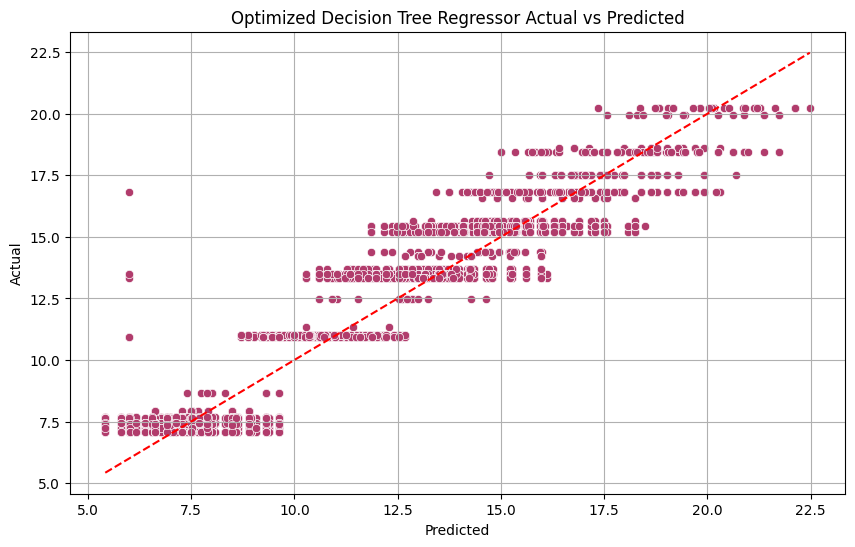

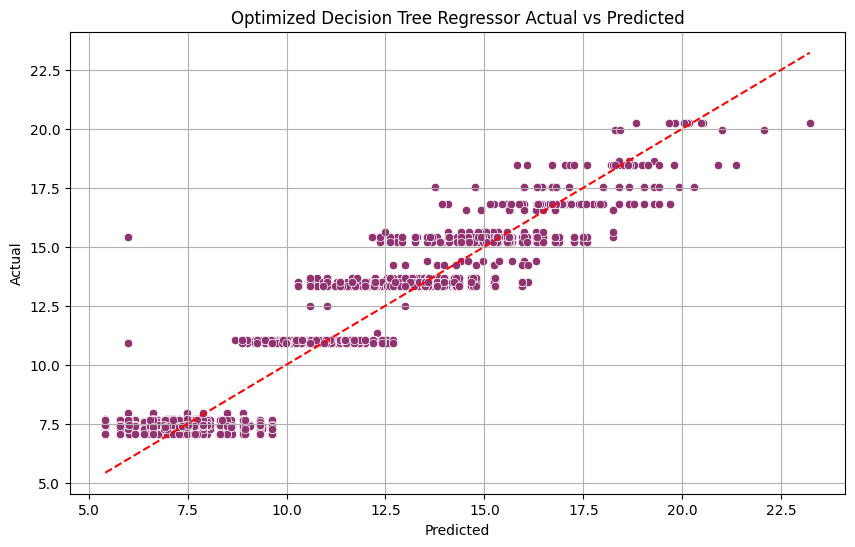

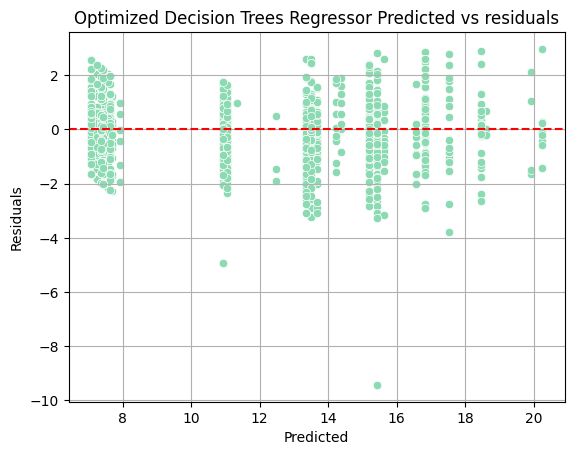

In [55]:
plt.figure(figsize = (10, 6))
sns.scatterplot(x = treeMetrics["y_train"], y = treeMetrics["y_pred_train"],  color = random.choice(sns.color_palette("flare")))
plt.plot([treeMetrics["y_train"].min(), treeMetrics["y_train"].max()], [treeMetrics["y_train"].min(), treeMetrics["y_train"].max()], "r--")
plt.title("Optimized Decision Tree Regressor Actual vs Predicted")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.grid(True)
plt.show()

plt.figure(figsize = (10, 6))
sns.scatterplot(x = treeMetrics["y_test"], y = treeMetrics["y_pred_test"],  color = random.choice(sns.color_palette("flare")))
plt.plot([treeMetrics["y_train"].min(), treeMetrics["y_test"].max()], [treeMetrics["y_test"].min(), treeMetrics["y_test"].max()], "r--")
plt.title("Optimized Decision Tree Regressor Actual vs Predicted")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.grid(True)
plt.show()



residuals = treeMetrics["y_test"] - treeMetrics["y_pred_test"]
sns.scatterplot(x = treeMetrics["y_pred_test"], y = residuals, color = random.choice(palette))
plt.axhline(0, color = "red", linestyle = "--")
plt.xlabel("Predicted")
plt.ylabel("Residuals")
plt.title("Optimized Decision Trees Regressor Predicted vs residuals")
plt.grid(True)
plt.show()


In [56]:
xgb.get_params()

{'objective': 'reg:squarederror',
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'device': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'feature_weights': None,
 'gamma': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': None,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_estimators': None,
 'n_jobs': None,
 'num_parallel_tree': None,
 'random_state': 42,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

In [ ]:
xgb_params = {
    "learning_rate" : [0.01, 0.07, 0.1],
    "max_depth": [10, 50, 80],
    "reg_lambda": [None, 0.01],
    "reg_alpha": [None, 0.01],
    "scale_pos_weight": [1, 3, 5],
}

xgb_random_search = RandomizedSearchCV(
    estimator=XGBRegressor(
                           seed = 42),
    cv = 10,
    verbose = 2,
    n_jobs = -1,
    param_distributions=xgb_params,
    scoring = "neg_mean_squared_error",
    ).fit(X_train_rf, y_train_rf)

xgb_new_model = xgb_random_search.best_estimator_

print(f"XGBoost Best model: {xgb_new_model}")
print(f"XGBoost Best params: {xgb_random_search.best_params_}")

Fitting 10 folds for each of 10 candidates, totalling 100 fits
[CV] END learning_rate=0.01, max_depth=50, reg_alpha=None, reg_lambda=None, scale_pos_weight=5; total time=  19.2s
[CV] END learning_rate=0.01, max_depth=50, reg_alpha=None, reg_lambda=None, scale_pos_weight=5; total time=  19.2s
[CV] END learning_rate=0.01, max_depth=50, reg_alpha=None, reg_lambda=None, scale_pos_weight=5; total time=  19.2s
[CV] END learning_rate=0.01, max_depth=50, reg_alpha=None, reg_lambda=None, scale_pos_weight=5; total time=  19.2s
[CV] END learning_rate=0.01, max_depth=50, reg_alpha=None, reg_lambda=None, scale_pos_weight=5; total time=  14.8s[CV] END learning_rate=0.01, max_depth=50, reg_alpha=None, reg_lambda=None, scale_pos_weight=5; total time=  14.7s[CV] END learning_rate=0.01, max_depth=50, reg_alpha=None, reg_lambda=None, scale_pos_weight=5; total time=  14.8s

[CV] END learning_rate=0.01, max_depth=50, reg_alpha=None, reg_lambda=None, scale_pos_weight=5; total time=  14.8s

[CV] END learning

In [65]:
best_xgb = XGBRegressor(scale_pos_weight = 1, reg_lambda = None, reg_alpha = None, max_depth = 2,
                        random_state = 42, learning_rate = 0.07, enable_categorical = True).fit(X_train, y_train)

xgb_optimized = model_training(X_train, X_test, y_train, y_test, best_xgb)

Mean Squared Error training set 0.99
Root Mean Squared Error training set 1.00
Mean Absolute Error training set 0.78
R-Squared training set 0.91

Mean Squared Error testing set 1.03
Root Mean Squared Error testing set 1.02
Mean Absolute Error testing set 0.79
R-Squared testing set 0.90


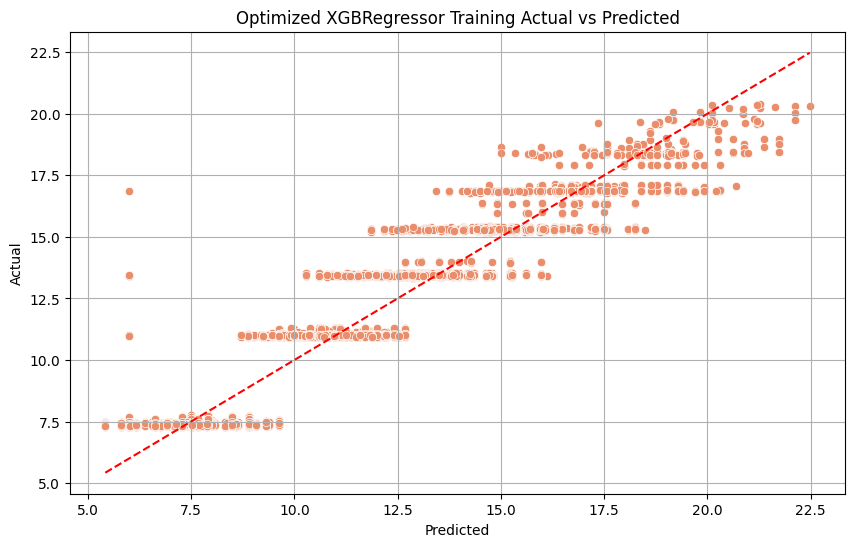

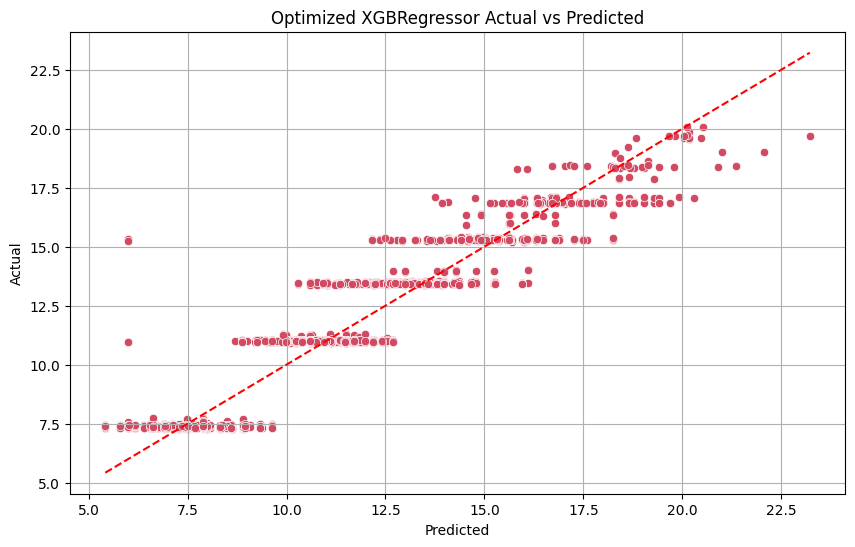

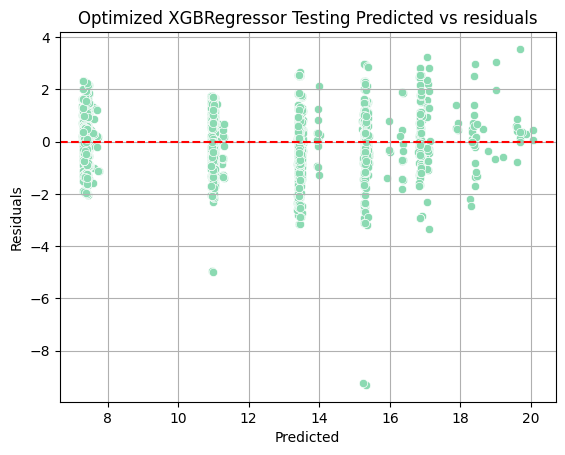

In [66]:
plt.figure(figsize = (10, 6))
sns.scatterplot(x = xgb_optimized["y_train"], y = xgb_optimized["y_pred_train"],  color = random.choice(sns.color_palette("flare")))
plt.plot([xgb_optimized["y_train"].min(), xgb_optimized["y_train"].max()], [xgb_optimized["y_train"].min(), xgb_optimized["y_train"].max()], "r--")
plt.title("Optimized XGBRegressor Training Actual vs Predicted")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.grid(True)
plt.show()

plt.figure(figsize = (10, 6))
sns.scatterplot(x = xgb_optimized["y_test"], y = xgb_optimized["y_pred_test"],  color = random.choice(sns.color_palette("flare")))
plt.plot([xgb_optimized["y_train"].min(), xgb_optimized["y_test"].max()], [xgb_optimized["y_test"].min(), xgb_optimized["y_test"].max()], "r--")
plt.title("Optimized XGBRegressor Actual vs Predicted")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.grid(True)
plt.show()

residuals = xgb_optimized["y_test"] - xgb_optimized["y_pred_test"]
sns.scatterplot(x = xgb_optimized["y_pred_test"], y = residuals, color = random.choice(palette))
plt.axhline(0, color = "red", linestyle = "--")
plt.xlabel("Predicted")
plt.ylabel("Residuals")
plt.title("Optimized XGBRegressor Testing Predicted vs residuals")
plt.grid(True)
plt.show()

## **Model Selection**

After carefully visualizing the residuals and fitted lines of Decision Trees and XGBoost. Decision Trees have won because it had less -ve residuals after optimizing its hyperparameters compared to all models including the optimized XGBoost Regressor. The The reason why the tree model performed better than the linear models, gradient boosting models and random forests  was because our data appears to be non-linear and when you train Linear Models with non-linear data, you introduce heteroskedasticity. In statistics, heteroskedasticity (or heteroscedasticity) happens when the standard deviations of a predicted variable, monitored over different values of an independent variable or as related to prior time periods, are non-constant. With heteroskedasticity, the tell-tale sign upon visual inspection of the residual errors is that they will tend to fan out over time, which what clearly happened when observing the visualizations of our Linear Models.

Tree Models capture non-linear data very well because Decision Trees naturally handle non-linearity. For Random Forest's case, each decision tree in a Random Forest splits data based on feature thresholds, creating piecewise constant approximations. These splits allow trees to model complex, non-linear relationships without assuming any specific functional form between inputs and outputs.

**Ensemble Learning Enhances Flexibility:**
Tree models builds multiple decision trees using different subsets of data and features (a process known as bagging). By averaging the predictions of these diverse trees, the model captures a wide range of patterns and reduces overfitting, leading to better generalization on unseen data.

**No Need for Manual Feature Engineering:**
Unlike linear models, which often require manual creation of interaction or polynomial terms to capture non-linearities, Tree models inherently models interactions between variables through its hierarchical tree structure. This reduces the need for extensive feature preprocessing.

**Robustness to Outliers and Noise**
The aggregation of multiple trees makes Tree Models robust to outliers and noisy data, which are common in real-world datasets. This robustness contributes to its strong performance on complex, non-linear problems.

On the other hand, when it comes to gradient boosting models, gradient boosting models have built in regularization paramets which are lambda for ridge and alpha for lasso. Due to the abscence of multicollinearity, XGBoost had larger errors between the range of 14-16 % interest rates compared to decision trees.

When it comes to random forests, random forests are the same as decision trees in terms of interpretability because they are built from deciison trees. However, their only main difference that instead of building just trees, alot of decision trees are built forming a forest and when you increase the iterations, you introduce new forests, which is why the computation time of random forests is significantly greater compared to the rest of the models that we have tested. The Reason why decision trees outperformed random forests was because the random forests had larger -ve residuals compared to decision trees. Also, due to the nature of our dataset, we do not have that many features. If we were to introduce alot more features or introduce alot more datapoints, then random forests would definitely outperform decision trees.

Therefore, **i can safely conclude that the model of choice when it comes to imputing our missing loan interest rates is going to be the Decision Trees.**

### **Feature Importances**

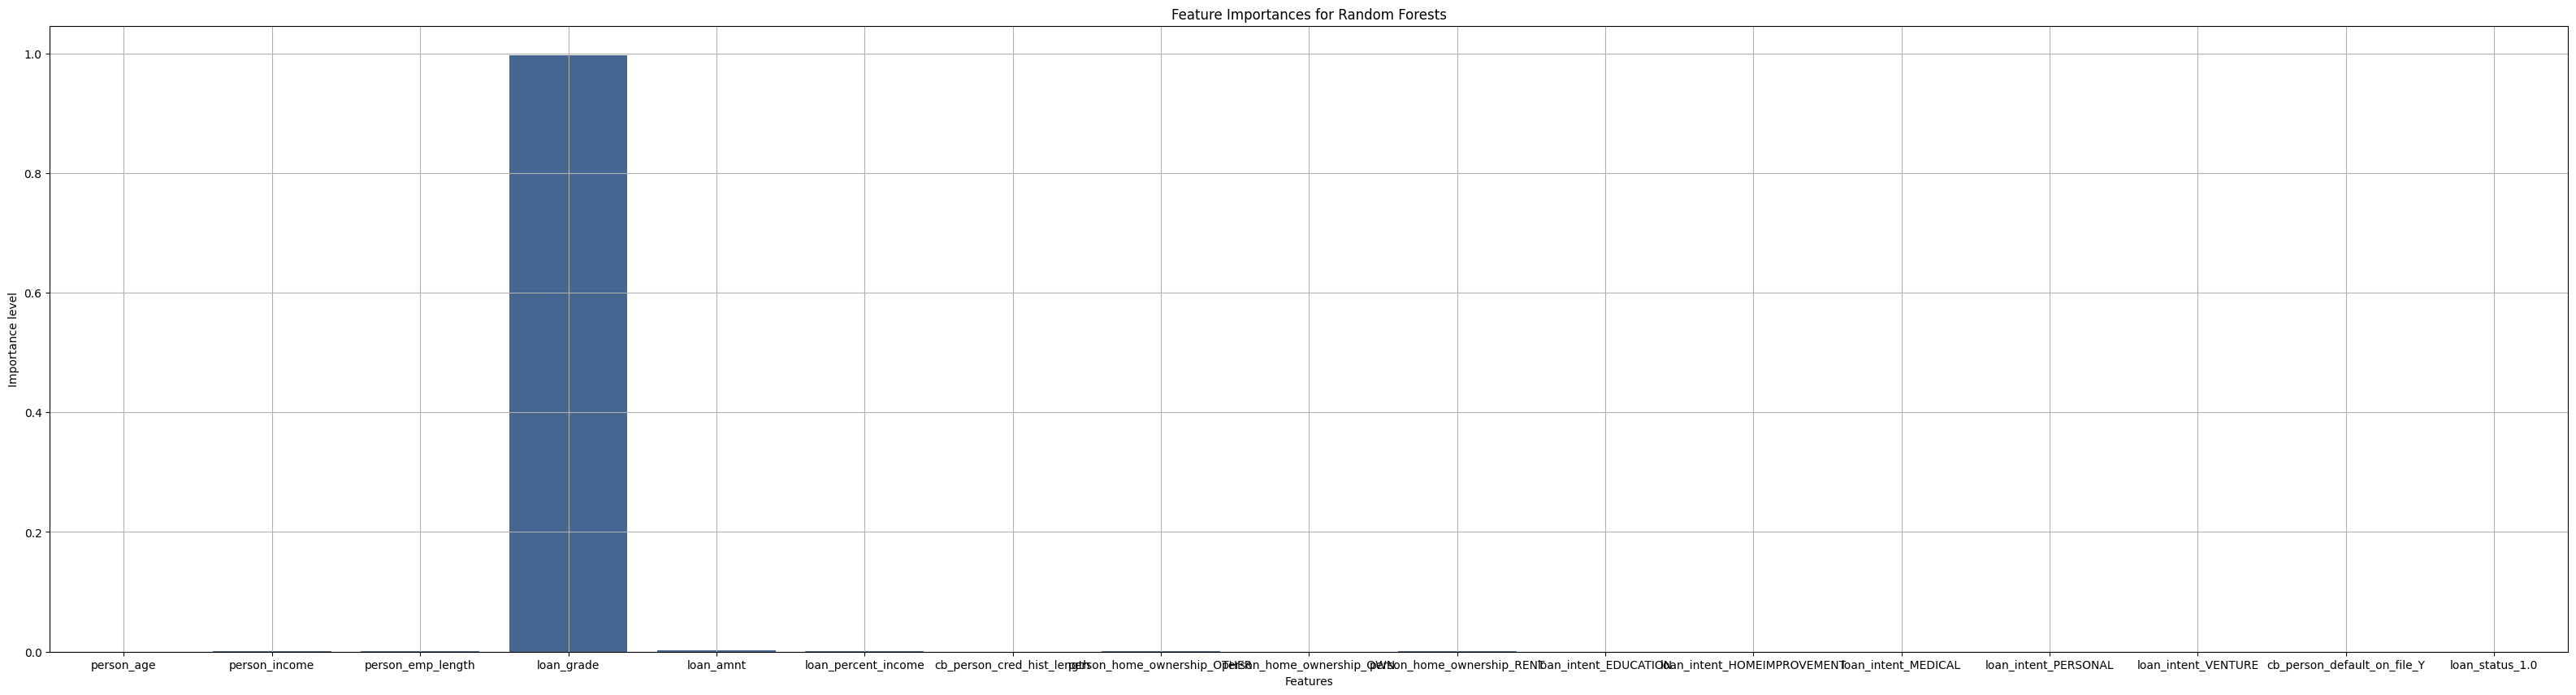

In [67]:
plt.figure(figsize = (40,10))
sns.barplot(y = best_tree.feature_importances_, x = rf_regress.feature_names_in_, color = random.choice(palette))
plt.title("Feature Importances for Random Forests")
plt.xlabel("Features")
plt.ylabel("Importance level")
plt.grid(True)
plt.show()

### **Imputing Missing Loan Interest Rates with Decision Trees**

In [68]:
#fill in the missing interest rates and non missing employment length with predictions 


target_prediction = credit_train[(credit_train["loan_int_rate"].isnull())]
target_prediction = target_prediction.drop(["loan_int_rate", "loan_clusters", "borrower_type"], axis = 1)

prediction = best_tree.predict(target_prediction)

print(len(credit_df))
credit_df["loan_int_rate"][(credit_df["loan_int_rate"].isnull())] = prediction
credit_df.head()
print(len(credit_df))

30924
30924


/tmp/ipykernel_235484/3121017275.py:10: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  credit_df["loan_int_rate"][(credit_df["loan_int_rate"].isnull())] = prediction
/tmp/ipykernel_235484/3121017275.py:10: SettingWithCopyWarning: 
A value is 

In [69]:
print(credit_df.isnull().sum())

person_age                    0
person_income                 0
person_home_ownership         0
person_emp_length             0
loan_intent                   0
loan_grade                    0
loan_amnt                     0
loan_int_rate                 0
loan_status                   0
loan_percent_income           0
cb_person_default_on_file     0
cb_person_cred_hist_length    0
loan_clusters                 0
borrower_type                 0
dtype: int64


### 📌 Conclusion

In this notebook, I tackled missing values in the dataset—specifically the missing `loan_int_rate` entries—by using supervised regression modeling. To ensure the effectiveness of my imputation strategy, I first performed a comprehensive data exploration with Boxplots and KMeans clustering to understand the structure of the data.

During the exploration phase, I identified several features that were non-unimodal, indicating the potential presence of distinct subpopulations. This insight led me to apply **KMeans clustering** on selected features to find opportunities to create new informative features. Before clustering, I addressed data quality issues by:
- **Handling anomalies** and outliers,
- Applying **RobustScaler** on `person_income` to mitigate the influence of extreme values, and
- Performing **power transformation** on all numerical features to reduce skewness and improve feature distributions.

Next, I used **Principal Component Analysis (PCA)** for dimensionality reduction to help identify optimal cluster structure in the numerical space. Based on this analysis, I created two new **ordinal features**:
- `loan_clusters`: capturing patterns in loan-related behavior,
- `borrower_type`: derived from clustering based on **credit history length**.

I followed up by encoding the categorical variables:
- **Nominal features**: using **One-Hot Encoding**,
- **Ordinal features** (including the new clusters): using **Label Encoding**.

I then ran a correlation test between the features and it turns out that the new ordinal features have no effect on predicting the loan interest rates and loan status but i managed to understand how the data are distributed thanks to KMeans.

With the dataset fully preprocessed, I moved on to modeling. I tested several regression models:
- **Linear Regression**
- **Ridge**
- **Lasso**
- **ElasticNet**
- **XGBoost Regression**
- **CatBoost Regression**
- **LightGBM Regression**
- **Decision Trees Regression**
- **Random Forest Regression**

After evaluating all models using both performance metrics and cross-validation, **Decision Trees** demonstrated the best results and generalizability after optimizing it. Therefore, it was selected as the final model to impute the missing loan interest rates.

---

### ⚠️ Final Reflection

Although one might consider extending this to **credit risk modeling**, the dataset lacks several **crucial features** typically required for such an analysis. In particular, the absence of:
- **Loan term** (e.g., 36 or 60 months),
- **Actual loan repayment status** (i.e., fully paid, charged off, or defaulted),
- **Scheduled monthly payment amount**, and
- **Loss Given Default (LGD)**.

makes it unsuitable for accurate and responsible credit risk assessment.

This limitation is not just technical—it **violates the fundamental law of credit risk modeling**, which defines **Expected Loss** as:

$$

\text{Expected Loss} = \text{PD} \times \text{EAD} \times \text{LGD}

$$

Without LGD and EAD (Exposure at Default), it is **impossible to calculate expected loss**, making any attempt at credit risk modeling on this dataset incomplete and misleading.

---

✅ This notebook highlights the importance of exploratory analysis, domain awareness, and ethical modeling practices when working with financial data.